In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import image.loadImage as loadImage
import gae.gae.optimizer as optimizer
import image.modelsCNN as modelsCNN

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [3]:
# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
use_cuda=True
fastmode=False #Validate during training pass
seed=3
epochs=10000
saveFreq=10
lr=0.0005 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=16

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
# randFeatureSubset=None
model_str='alexnet_regrs'

kernel_size=4
stride=2
padding=1

hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=512
hidden5=512
fc_dim1=512*25*25
fc_dim2=1024

pretrainedAE=None #{'name':'controlphy5XAbin_01_dca','epoch':9990}
# training_samples=['control13','disease13','disease8','control8']
training_samples=['disease13']
targetBatch=None
switchFreq=1
diamThresh_mul=800
minThresh_mul=12
overlap=int(diamThresh_mul*0.7)
areaThresh=diamThresh_mul*diamThresh_mul*0.7
plaqueMaskName='PlaqueMask'
plaqueMaskImg='Maskofplaque.tif'
name='disease13regrs_thresh25min12_overlap70area70_01'
logsavepath='/mnt/external_ssd/xinyi/log/train_cnnRegrs_starmap/'+name
modelsavepath='/mnt/external_ssd/xinyi/models/train_cnnRegrs_starmap/'+name
plotsavepath='/mnt/external_ssd/xinyi/plots/train_cnnRegrs_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


In [4]:
plaqueCentroids={}
plaqueCentroids['disease13']=pd.read_csv('/home/xinyiz/2021-01-13-mAD-test-dataset/AD_mouse9494/trimmed_images/'+plaqueMaskName+'.csv', header=0)
plaqueCentroids['disease8']=pd.read_csv('/home/xinyiz/2021-01-13-mAD-test-dataset/AD_mouse9723/trimmed_images/'+plaqueMaskName+'.csv', header=0)
maxArea=max(np.max(plaqueCentroids['disease13']['Area']),np.max(plaqueCentroids['disease8']['Area']))
plaqueCutoffRadius=max(int(np.sqrt(maxArea)/2),int(diamThresh_mul/2))
# plaqueSizeFactor=maxArea/100
plaqueSizeFactor=1

In [5]:
maxArea

91098

In [6]:
min(np.min(plaqueCentroids['disease13']['Area']),np.min(plaqueCentroids['disease8']['Area']))

30

In [7]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [8]:
s=training_samples[0]
trainInputnp, valInputnp, _,trainLabelsnp,valLabelsnp,_,_,_,_=loadImage.loadandsplitPlaque_overlap_regrs(plaqueMaskImg,plaqueSizeFactor,areaThresh,plaqueCentroids[s][['Y','X']].to_numpy().astype(int),plaqueCutoffRadius,sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,returnPos=True)

#all_thresh25min12_overlap70area70_04_shuffled only
trainInputnp=trainInputnp.astype('float32')
valInputnp=valInputnp.astype('float32')
for sidx in range(1,len(training_samples)):
    s=training_samples[sidx]
    if 'disease' in s:
        inputlist=loadImage.loadandsplitPlaque_overlap_regrs(plaqueMaskImg,plaqueSizeFactor,areaThresh,plaqueCentroids[s][['Y','X']].to_numpy().astype(int),plaqueCutoffRadius,sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,returnPos=True)
    if 'control' in s:
        inputlist=loadImage.loadandsplit(sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,clf=True,returnPos=True)
    trainInputnp=np.concatenate((trainInputnp,inputlist[0].astype('float32')),axis=0)
    valInputnp=np.concatenate((valInputnp,inputlist[1].astype('float32')),axis=0)
    trainLabelsnp=np.concatenate((trainLabelsnp,inputlist[3]),axis=0)
    valLabelsnp=np.concatenate((valLabelsnp,inputlist[4]),axis=0)
inputlist=None

sampleIdx=np.arange(trainInputnp.shape[0])
np.random.shuffle(sampleIdx)


plaque1959
no plaque2434


In [9]:
npos=0
nneg=0
npos=np.sum(trainLabelsnp!=0)
nneg=trainLabelsnp.shape[0]-npos
print(npos)
print(nneg)
negweight=(nneg+npos)/nneg
posweight=(nneg+npos)/npos

1663
2071


In [10]:
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='alexnet':
    model = modelsCNN.AlexNet(2)
    lossCE=torch.nn.CrossEntropyLoss(torch.tensor([negweight,posweight]).cuda().float())
if model_str=='alexnet_regrs':
    model = modelsCNN.AlexNet(1,regrs=True)
    lossCE=torch.nn.MSELoss(reduction='none')
    
# if model_str=='cnnvae_clf':
#     model = modelsCNN.CNN_VAE_clf(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
#     lossCE=torch.nn.CrossEntropyLoss(torch.tensor([1,imageslist['disease13'][3].shape[0]/np.sum(imageslist['disease13'][3])]).cuda().float())

if use_cuda:
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


In [ ]:
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(9360)+'.pt')))
# epochs=20000
if pretrainedAE:
    print('loading '+pretrainedAE['name']+' epoch '+str(pretrainedAE['epoch']))
    model.load_state_dict(torch.load(os.path.join('/mnt/xinyi/pamrats/models/train_gae_starmap/'+pretrainedAE['name'],str(pretrainedAE['epoch'])+'.pt')))
    
def train(epoch):
    t = time.time()
    model.train()
    
    loss_all=0
    for i in range(int(np.ceil(trainInputnp.shape[0]/batchsize))):
        trainIdx=sampleIdx[i*batchsize:min((i+1)*batchsize,trainInputnp.shape[0])]
        
        trainInput=trainInputnp[trainIdx]
        labels=trainLabelsnp[trainIdx]
        if use_cuda:
            trainInput=torch.tensor(trainInput).cuda().float()
            labels=torch.tensor(labels).cuda().float()
        optimizer.zero_grad()

        pred = model(trainInput)

        if 'regrs' in model_str:
            weight_curr=torch.where(labels==0,negweight,posweight)
            loss=torch.mean(lossCE(pred.flatten(),labels)*weight_curr)
            loss_all+=loss.item()
        else:
            loss=lossCE(pred,labels)
            loss_all+=loss.item()
        if i==0:
            print(pred.flatten())
            print(labels)
        loss.backward()
        optimizer.step()

#     print(pred.flatten())
#     print(labels)
    loss_all=loss_all/int(np.ceil(trainInputnp.shape[0]/batchsize))
    
    model.eval()
    loss_val_all=0
    for i in range(int(np.ceil(valInputnp.shape[0]/batchsize))):
        valInput=valInputnp[i*batchsize:min((i+1)*batchsize,valInputnp.shape[0])]
        labels=valLabelsnp[i*batchsize:min((i+1)*batchsize,valInputnp.shape[0])]
        if use_cuda:
            valInput=torch.tensor(valInput).cuda().float()
            labels=torch.tensor(labels).cuda().long()
        pred = model(valInput)

        if 'regrs' in model_str:
            weight_curr=torch.where(labels==0,negweight,posweight)
            loss_val_all+=torch.mean(lossCE(pred.flatten(),labels)*weight_curr).item()
        else:
            loss_val_all+=lossCE(pred,labels).item()
        if i==0:
            print(pred.flatten())
            print(labels)
        
#     print(pred.flatten())
#     print(labels)
    loss_val_all=loss_val_all/int(np.ceil(valInputnp.shape[0]/batchsize))
    
    print('Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_val: {:.4f}'.format(loss_val_all))
    return loss_all,loss_val_all
    
train_loss_ep=[None]*epochs
val_loss_ep=[None]*epochs
t_ep=time.time()

for ep in range(epochs):
# for ep in range(10000,20000):
    
    train_loss_ep[ep],val_loss_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


tensor([0.0105, 0.0112, 0.0128, 0.0088, 0.0086, 0.0064, 0.0121, 0.0089, 0.0100,
        0.0132, 0.0051, 0.0136, 0.0095, 0.0126, 0.0177, 0.0141],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([14140.0771, 18763.9922, 16344.4414, 13059.9297, 13807.2715, 16049.0498,
        15238.6611, 13950.1172, 19078.4062, 15364.1816, 15013.5537, 12603.8467,
        13854.9180, 16205.1875, 15400.6016, 15419.0557], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0000 loss_train: 958674167.0427 loss_val: 750378944.0000
tensor([14664.5625, 16623.7988, 13987.5215, 13822.8203, 13722.6699, 12785.5820,
        11533.5117, 14386.6865, 12383.7139, 13876.3643, 12082.6152, 13235.2793,
   

tensor([ 1757.0756, 44472.5938, 24611.1953,  7182.4067,    95.5737, 21204.4355,
        14503.8662,  8688.2051, 34299.0156, 16153.8506,   443.6516,  6272.8140,
         3594.5898, 10561.8682, 25522.8926, 21954.2578], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0009 loss_train: 697871715.6923 loss_val: 600600345.1429
tensor([15493.1260, 30388.9492, 19183.5449,     0.0000, 25100.2148, 16017.4883,
         3758.5554, 16617.9668,  4815.5132, 15488.4893,  4789.7998,  7689.7036,
        19866.1992, 20938.5430,  8212.0654, 17515.4277], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([ 1916.7449, 48286.9766, 24861.5117,  7186.5596,  1289.0293, 22292.9082,
        149

Epoch: 0018 loss_train: 470911229.3162 loss_val: 569728094.8571
tensor([ 9287.8125,  6154.6826, 25907.1504,     0.0000, 47372.7070,  8197.7715,
          489.7370, 29544.5059,  9010.7842, 26747.3789, 11947.8213,  5682.1064,
        33905.2461,  9707.8223, 14482.6611, 20166.5840], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([  901.7377, 95708.5938, 18068.0273, 10127.2969,     0.0000, 14667.6201,
         6314.4268, 17291.2793, 75087.3750,  7224.2188,     0.0000,  5279.3818,
         3016.5046, 12925.3047, 31445.9844, 23095.2637], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0019 loss_train: 439961058.9915 loss_val: 623673947.4286
tensor([10430.9160, 10082.1

Epoch: 0027 loss_train: 286091268.8846 loss_val: 568523683.4286
tensor([ 9441.4805,  3311.7805, 12678.2627,  3280.5596, 42788.8008,  5326.6787,
            0.0000, 31014.9180,  5742.3706, 24875.5020, 21814.7324,   770.9468,
        36222.4023,     0.0000, 10601.3682,  5916.9326], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 66359.3906,  5200.8174,  2564.6458,     0.0000,  7614.8975,
          865.2064,     0.0000, 42715.7344,  2196.2952,     0.0000,  2009.3615,
         1304.5547,  5561.7432, 19746.2871,  3266.1423], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0028 loss_train: 250771625.1966 loss_val: 607310046.8571
tensor([ 4604.3037,  3247.1

tensor([    0.0000, 52406.0273,  3717.6511,     0.0000,     0.0000,  2516.6155,
            0.0000,     0.0000, 35059.1406,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 12906.2461,   722.3904], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0037 loss_train: 165424596.7863 loss_val: 646205865.1429
tensor([ 5965.8047,     0.0000,  2816.2842,     0.0000, 60837.6719,     0.0000,
            0.0000, 30920.7090,  5043.7080, 18256.0430, 17988.9199,     0.0000,
        23695.2539,     0.0000, 31256.9707,  1739.3810], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 39996.2617,  5823.2593,     0.0000,     0.0000,  2228.3286,
           

Epoch: 0046 loss_train: 185214163.2735 loss_val: 556727665.1429
tensor([ 1461.1597,  3889.3345,  9485.7930,     0.0000, 46923.6836,  8618.2168,
            0.0000, 38527.2148, 24368.2637, 21860.4375, 19742.4414,     0.0000,
        27923.8086,  6356.5435, 33326.7344,  8226.6455], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 60510.6172, 13426.6416,  1465.8616,     0.0000,  5713.7695,
         6177.3354,     0.0000, 38736.8438,     0.0000,     0.0000,   559.8427,
          771.9161,  3418.0483, 23806.1387,  2981.8918], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0047 loss_train: 126330883.7009 loss_val: 540913419.4286
tensor([    0.0000,     0.0

tensor([0.0000e+00, 6.8475e+04, 1.3150e+04, 5.6868e+03, 0.0000e+00, 4.2531e+03,
        2.2980e+03, 0.0000e+00, 4.1989e+04, 0.0000e+00, 0.0000e+00, 2.8467e+01,
        4.7032e+02, 5.9488e+03, 2.5183e+04, 8.1939e+03], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0056 loss_train: 86731127.0630 loss_val: 532095186.2857
tensor([ 2118.0671,     0.0000,  8985.5977,     0.0000, 70785.7500,     0.0000,
            0.0000, 38354.8008, 13099.1953, 27353.8574, 19066.9961,     0.0000,
        27959.4434,     0.0000, 41114.0664,  9912.6084], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 63796.4688, 12404.1572,  2685.5291,     0.0000,  7625.6328,
         176

Epoch: 0065 loss_train: 74629680.9979 loss_val: 459102529.1429
tensor([ 3718.7893,  3219.0049, 17414.2949,     0.0000, 66375.6562,     0.0000,
            0.0000, 37175.4844,     0.0000, 24099.7480, 14856.6230,     0.0000,
        20243.5664,     0.0000, 29275.6406,  5371.2881], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 63898.5977, 13192.8320,  4239.5181,     0.0000,  3301.9492,
          649.7837,     0.0000, 34330.6875,     0.0000,     0.0000,     0.0000,
         1625.6627,  5652.4482, 23704.9453,  2036.4432], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0066 loss_train: 93354397.8045 loss_val: 491838186.2857
tensor([ 1446.8884,     0.000

tensor([ 2968.3081, 82976.6172, 32922.7461, 11503.4131,     0.0000, 21421.6523,
          571.4593,     0.0000, 57631.8789,  4008.4600,     0.0000,  1203.6012,
         2856.7556,  8233.8252, 40901.4688, 26273.2285], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0075 loss_train: 62774990.6517 loss_val: 540029238.8571
tensor([11148.8359,     0.0000,  5507.4673,  3129.5906, 68141.5078,     0.0000,
            0.0000, 50000.3359, 12109.7754, 27821.3750, 30834.0742,     0.0000,
        30026.1582,  3359.3633, 38091.4766, 13681.6689], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([ 3193.4824, 67643.9766, 30145.3105, 13663.0039,     0.0000, 22010.3730,
          70

Epoch: 0084 loss_train: 55334527.1944 loss_val: 451308473.1429
tensor([ 1365.6930,     0.0000,  1310.6564,  6295.1152, 62092.9141,     0.0000,
         1713.1429, 47631.3242, 21690.7480, 30934.6914, 28056.3945,     0.0000,
        39451.1211,     0.0000, 35249.1133, 10082.7207], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([ 2366.1975, 63288.6133, 15307.0811,   253.5479,     0.0000, 11344.8076,
            0.0000,     0.0000, 55397.5156,  6103.1011,     0.0000,  3469.3394,
         1654.1931, 10376.8438, 32856.8555,  6844.3252], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0085 loss_train: 58671766.3482 loss_val: 502767219.4286
tensor([  903.6927,     0.000

tensor([ 3917.4058, 80063.8359, 12169.6074,  4370.5522,     0.0000, 12090.9248,
        10511.6221,     0.0000, 48064.0938,  3772.6772,     0.0000,  4572.4321,
         1683.8223, 12456.3115, 41271.0312, 18715.3926], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0094 loss_train: 56902908.1645 loss_val: 490470475.4286
tensor([13313.8125,   182.2437,  2027.6472,  3261.8525, 74663.0234,     0.0000,
            0.0000, 34119.2500,     0.0000, 26306.7305, 25798.0488,     0.0000,
        21618.2090,     0.0000, 32960.4180,  6234.0630], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([ 2155.5518, 95328.0469, 21110.2480,  5300.7139,     0.0000, 11054.3652,
            

Epoch: 0103 loss_train: 43971058.7393 loss_val: 461380962.8571
tensor([ 1060.0593,     0.0000,  1103.4113,     0.0000, 75306.2188,     0.0000,
            0.0000, 67616.0078,     0.0000, 36642.4531, 25193.4180,     0.0000,
        19227.4277,     0.0000, 32311.7422,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 83601.0703, 18431.6680,  1440.0305,     0.0000, 11532.6807,
            0.0000,     0.0000, 46528.2695,  3563.7307,     0.0000,  2599.8052,
         2388.2583,  2615.5793, 30655.5703, 15177.5908], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0104 loss_train: 47501983.4486 loss_val: 451611299.4286
tensor([ 5134.1460,     0.000

tensor([    0.0000, 54706.0977, 11461.2891,  2950.7732,     0.0000,  7930.5137,
            0.0000,     0.0000, 33597.4688,  2118.5505,     0.0000,   810.1515,
         1230.3169,     0.0000, 19920.4727,  6348.3486], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0113 loss_train: 56810310.6015 loss_val: 518773316.5714
tensor([    0.0000,     0.0000,   330.7151,     0.0000, 67546.9609,     0.0000,
            0.0000, 34150.4180,     0.0000, 16058.2451, 16828.6094,     0.0000,
        19966.4531,     0.0000, 30887.9727,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 58674.9219,  9628.9160,  5647.0708,     0.0000,  6598.1914,
            

Epoch: 0122 loss_train: 38372247.5246 loss_val: 465023749.7143
tensor([ 2654.9302,     0.0000,  1753.8871,     0.0000, 72682.2266,     0.0000,
            0.0000, 53525.6016,     0.0000, 23726.5684, 38661.1328,     0.0000,
        25566.8125,     0.0000, 46944.7070,  1216.3113], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 63571.7070, 15963.5234,  8438.1641,     0.0000,  9591.2227,
            0.0000,     0.0000, 44091.3164,  4267.6099,     0.0000,  2564.5864,
         2560.3569,  1826.1549, 29815.1621, 28012.6934], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0123 loss_train: 39500486.3034 loss_val: 421628882.8571
tensor([    0.0000,     0.000

tensor([    0.0000, 62697.1406, 10985.8545,  7495.0547,     0.0000,  9147.2822,
            0.0000,     0.0000, 44516.4531,     0.0000,     0.0000,  2674.9900,
          511.6430,     0.0000, 33042.6797, 15074.2686], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0132 loss_train: 38645420.8504 loss_val: 422236217.7143
tensor([    0.0000,     0.0000,  3203.6292,     0.0000, 62480.7031,  6679.6133,
            0.0000, 60028.2969,     0.0000, 24322.3438, 34831.0508,     0.0000,
        33056.2578,     0.0000, 38291.2930,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 59415.4102, 12790.2158,  3610.1924,     0.0000,  9724.0117,
            

Epoch: 0141 loss_train: 35168072.3946 loss_val: 415469868.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 75806.1953,     0.0000,
            0.0000, 43997.8906,     0.0000, 29721.7773, 39769.8828,     0.0000,
        27870.7227,     0.0000, 27716.4863,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 76878.2422, 16273.7979,  7524.6299,     0.0000,  9875.3291,
            0.0000,     0.0000, 43096.1094,  3403.4980,     0.0000,  2587.3359,
         3466.8013,  1713.9658, 34882.8359, 29133.0664], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0142 loss_train: 42715260.1400 loss_val: 420171224.5714
tensor([    0.0000,  4484.000

tensor([    0.0000,     0.0000,  4641.4424,     0.0000, 65785.4531,     0.0000,
            0.0000, 45821.7539,     0.0000, 32112.6836, 29759.6582,     0.0000,
        32796.4531,     0.0000, 29260.8477,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 62284.6211, 11819.2686,  5005.5381,     0.0000,  7671.8765,
            0.0000,     0.0000, 38094.4961,     0.0000,     0.0000,   460.8063,
         1406.9788,     0.0000, 26552.0410,  8320.7061], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0151 loss_train: 28932829.4765 loss_val: 434539185.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 55947.7344,     0.0000,
            

tensor([0.0000e+00, 5.9350e+04, 8.3347e+03, 4.8570e+03, 0.0000e+00, 7.9985e+03,
        0.0000e+00, 0.0000e+00, 3.3950e+04, 2.8929e+02, 0.0000e+00, 3.6927e+01,
        0.0000e+00, 2.7799e+02, 2.5701e+04, 2.9045e+03], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0160 loss_train: 31292399.6859 loss_val: 447696787.4286
tensor([    0.0000,     0.0000,   682.7140,     0.0000, 66884.3359,     0.0000,
            0.0000, 42160.8906,     0.0000, 27002.7773, 29558.9648,     0.0000,
        29405.7676,     0.0000, 26285.5254,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 55616.2031, 11372.3965,  5271.8477,     0.0000,  9701.5039,
            

Epoch: 0169 loss_train: 30109431.9239 loss_val: 383897090.2857
tensor([ 1267.6724,     0.0000,     0.0000,     0.0000, 84584.6562,     0.0000,
            0.0000, 54830.4531,     0.0000, 29104.5254, 34114.7812,     0.0000,
        26963.1152,     0.0000, 32478.2930,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 64475.9961, 14340.1650, 10096.5352,     0.0000, 11241.1494,
            0.0000,     0.0000, 44282.6953,  3707.3145,     0.0000,  2221.5710,
            0.0000,     0.0000, 28004.6133, 10629.5674], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0170 loss_train: 27823147.9573 loss_val: 397066258.8571
tensor([    0.0000,     0.000

tensor([    0.0000, 69622.1953, 11823.1621,  4609.2354,     0.0000, 10348.2773,
            0.0000,     0.0000, 42467.6055,  6154.5933,     0.0000,  1785.2040,
         2427.5940,  5193.7305, 37485.7422, 15437.0137], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0179 loss_train: 31537176.1207 loss_val: 400168682.2857
tensor([    0.0000,     0.0000,  1192.6342,     0.0000, 72268.2031,     0.0000,
            0.0000, 56006.0898,     0.0000, 34179.4453, 24935.9570,     0.0000,
        24274.9141,     0.0000, 30899.1191,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74945.8828, 17112.0762,  5199.1006,     0.0000, 11083.2441,
            

Epoch: 0188 loss_train: 26401036.4655 loss_val: 382216655.4286
tensor([    0.0000,     0.0000,   498.4627,     0.0000, 66994.0625,     0.0000,
            0.0000, 48144.9453,     0.0000, 27925.8887, 30423.3027,     0.0000,
        22645.1426,     0.0000, 28538.3926,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 65873.7656, 14418.0176, 14497.3867,     0.0000, 11523.4932,
            0.0000,     0.0000, 37220.5742,  1646.2240,     0.0000,     0.0000,
          152.1623,   602.3731, 35827.6602,  2973.2517], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0189 loss_train: 23805815.1607 loss_val: 358178768.5714
tensor([    0.0000,     0.000

tensor([ 1093.6224, 64990.4844, 13824.7852, 10404.2061,     0.0000, 14992.2031,
            0.0000,     0.0000, 40788.0430,  3185.5283,     0.0000,  2291.1765,
         3118.0386,  2649.6665, 37361.2109,  4452.7056], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0198 loss_train: 23450103.7267 loss_val: 368545546.2857
tensor([    0.0000,     0.0000,  2015.4135,     0.0000, 62437.3867,     0.0000,
            0.0000, 44577.8242,     0.0000, 28722.5469, 31163.6680,     0.0000,
        24712.1152,     0.0000, 27281.2012,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69723.9062, 20699.2305,  8297.9512,     0.0000, 15078.0586,
            

Epoch: 0207 loss_train: 26323324.7369 loss_val: 392319220.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65266.1133,     0.0000,
            0.0000, 45753.0977,     0.0000, 27674.1309, 25902.4199,     0.0000,
        24086.0723,     0.0000, 43462.9805,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71567.2344, 15245.2812,  9046.3730,     0.0000, 10935.6230,
            0.0000,     0.0000, 40452.7695,  5004.5044,     0.0000,     0.0000,
         2303.6309,     0.0000, 29836.1680, 13888.1426], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0208 loss_train: 26292530.5052 loss_val: 389990110.8571
tensor([    0.0000,     0.000

tensor([    0.0000, 70323.1094, 15784.8486, 13658.6123,     0.0000, 10767.3262,
            0.0000,     0.0000, 41803.5000,  6175.0415,     0.0000,  3830.9043,
         3956.4761,     0.0000, 35965.6719, 21789.4902], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0217 loss_train: 25200072.0061 loss_val: 366504651.4286
tensor([    0.0000,     0.0000,  6223.5166,     0.0000, 74342.0703,     0.0000,
            0.0000, 53077.2344,     0.0000, 36085.4570, 37919.6211,     0.0000,
        27124.6699,     0.0000, 39770.1328,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 65208.8477, 17438.0527, 16973.3398,     0.0000, 11149.4570,
          50

Epoch: 0226 loss_train: 23677694.8698 loss_val: 380626814.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63543.1914,     0.0000,
            0.0000, 48368.4648,     0.0000, 26772.3320, 31483.1621,     0.0000,
        30172.2793,     0.0000, 42557.4492,  1354.3840], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68646.1016, 14259.1904, 15578.7373,     0.0000, 10637.9619,
            0.0000,     0.0000, 33297.0664,  3599.8669,     0.0000,   946.1075,
         1905.7965,     0.0000, 25235.9023, 14125.4414], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0227 loss_train: 21045680.8275 loss_val: 396528006.2857
tensor([    0.0000,     0.000

tensor([    0.0000, 65430.1680, 12192.7812, 18362.3105,     0.0000, 11330.6318,
            0.0000,     0.0000, 39385.5391,  5275.6177,     0.0000,  1827.8347,
         4485.1582,     0.0000, 39755.2148,  8345.6748], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0236 loss_train: 19768710.4671 loss_val: 370352613.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 80320.6797,     0.0000,
            0.0000, 51383.0977,     0.0000, 29896.3555, 20807.8652,     0.0000,
        21503.5703,     0.0000, 27001.9180,  1638.9528], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 65412.0195, 13415.3408, 21035.9941,     0.0000, 11176.5000,
            

Epoch: 0245 loss_train: 19996638.7209 loss_val: 358478526.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63951.2148,     0.0000,
            0.0000, 45268.3984,     0.0000, 27907.4297, 30888.0859,     0.0000,
        29882.8027,     0.0000, 35156.0078,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 66026.2422, 13199.6846,  9659.1250,     0.0000, 10208.3154,
            0.0000,     0.0000, 33750.4414,  1105.2474,     0.0000,  2027.1654,
         1579.6614,     0.0000, 37566.8359,  8595.6924], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0246 loss_train: 19298286.6513 loss_val: 382083355.1429
tensor([    0.0000,     0.000

tensor([    0.0000, 70744.3125, 19153.4355, 19854.3672,     0.0000, 10668.9678,
            0.0000,     0.0000, 40989.6133,  3782.7856,     0.0000,     0.0000,
         2281.3311,  4735.5410, 33941.9375,  5987.5229], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0255 loss_train: 21489992.2920 loss_val: 340304922.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 79329.2109,     0.0000,
            0.0000, 50743.8125,     0.0000, 29589.4980, 36105.1719,     0.0000,
        30990.5586,     0.0000, 37481.1914,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 57497.5586, 17069.6387, 17315.7324,     0.0000,  9959.7783,
            

Epoch: 0264 loss_train: 21776000.7756 loss_val: 367780726.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 84736.2500,     0.0000,
            0.0000, 36234.7383,     0.0000, 29975.1270, 32018.9102,     0.0000,
        27974.4570,     0.0000, 36008.9961,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72294.1172, 20266.4082, 13173.9619,     0.0000, 15027.3926,
            0.0000,     0.0000, 41298.2578,  3223.1553,     0.0000,  2825.3325,
         5134.7798,  8121.3052, 43721.6719, 10336.8145], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0265 loss_train: 23593004.6872 loss_val: 345447797.1429
tensor([    0.0000,     0.000

tensor([    0.0000, 67426.8125, 16459.0977, 22338.9766,     0.0000, 10592.0391,
            0.0000,     0.0000, 40447.7812,  2490.7393,     0.0000,     0.0000,
         5255.8887,     0.0000, 38619.1523, 21044.8848], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0274 loss_train: 21520410.0357 loss_val: 333721770.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 75054.6875,     0.0000,
            0.0000, 45677.7422,     0.0000, 31455.7539, 28074.3223,     0.0000,
        28140.1895,     0.0000, 36740.0039,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 64533.7500, 15338.2744, 16874.1074,     0.0000, 10772.5908,
            

Epoch: 0283 loss_train: 17585918.9193 loss_val: 350938737.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63414.4961,     0.0000,
            0.0000, 50715.2695,     0.0000, 24057.1602, 38213.4805,     0.0000,
        29847.6777,     0.0000, 31393.9121,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73749.0469, 21178.0234, 19192.6738,     0.0000, 15508.9248,
            0.0000,     0.0000, 47534.1602,  4200.5405,     0.0000,  3264.4297,
         4654.2837,  2560.8496, 44894.1094,  9304.6826], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0284 loss_train: 16926175.9663 loss_val: 354236241.1429
tensor([    0.0000,     0.000

tensor([    0.0000, 58117.5781, 13557.3379, 16715.6035,     0.0000, 10000.1982,
            0.0000,     0.0000, 37268.6055,  5917.5483,     0.0000,     0.0000,
         5205.7456,     0.0000, 34126.2383, 12056.8066], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0293 loss_train: 18308711.7661 loss_val: 364766759.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64853.7812,     0.0000,
            0.0000, 38496.8008,     0.0000, 24399.6328, 26708.3027,     0.0000,
        20718.4062,     0.0000, 28825.8438,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 66759.7812, 13505.3408, 14059.6104,     0.0000, 11147.3486,
            

Epoch: 0302 loss_train: 18962099.4108 loss_val: 345115499.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 73673.7500,     0.0000,
            0.0000, 51163.1562,     0.0000, 25508.5605, 29305.4980,     0.0000,
        28207.3340,     0.0000, 49726.6133,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69969.8750, 14224.5869, 12775.2246,     0.0000, 11504.2891,
            0.0000,     0.0000, 38335.0820,  5910.6768,     0.0000,     0.0000,
         1629.1562,     0.0000, 30992.0645,  6491.0391], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0303 loss_train: 16167262.8515 loss_val: 373185258.8571
tensor([    0.0000,     0.000

tensor([    0.0000, 71806.1250, 13957.0830, 22945.5801,     0.0000, 11026.6211,
            0.0000,     0.0000, 48530.1992,  1971.7495,     0.0000,     0.0000,
         3181.1428,     0.0000, 32085.8691,   397.5116], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0312 loss_train: 16261987.3719 loss_val: 317996213.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71753.3906,     0.0000,
            0.0000, 54787.5781,     0.0000, 28952.4434, 26746.0352,     0.0000,
        22329.0176,     0.0000, 33052.2422,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69774.6641, 14942.5225, 19902.0859,     0.0000, 11710.9102,
            

Epoch: 0321 loss_train: 16284737.8903 loss_val: 342936696.0000
tensor([    0.0000,     0.0000,  4972.1885,     0.0000, 60149.0547,     0.0000,
            0.0000, 44075.9180,     0.0000, 30260.0508, 25006.5156,     0.0000,
        26765.9219,     0.0000, 32042.6680,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 79914.5859, 15517.3447, 22563.1602,     0.0000, 12994.2646,
            0.0000,     0.0000, 54937.9883,  5285.7310,     0.0000,  3808.7490,
         5892.3921,     0.0000, 34208.9688, 26574.4062], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0322 loss_train: 18572475.5459 loss_val: 335266973.7143
tensor([    0.0000,     0.000

tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66457.2109,     0.0000,
            0.0000, 47688.6094,     0.0000, 26279.7324, 22777.6387,     0.0000,
        26388.6270,     0.0000, 35181.7500,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68023.3750, 12317.1445, 16140.5107,     0.0000, 11305.7090,
            0.0000,     0.0000, 43000.0859,  4184.3540,     0.0000,     0.0000,
         3486.3015,     0.0000, 37169.2773, 29314.5410], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0331 loss_train: 15228219.9710 loss_val: 347648249.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69874.1484,     0.0000,
            

tensor([    0.0000, 70073.0000, 13550.4229, 19208.5332,     0.0000, 11666.8242,
            0.0000,     0.0000, 36108.6641,  5047.5908,     0.0000,     0.0000,
         1223.3250,     0.0000, 31217.6328, 17533.8242], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0340 loss_train: 16568394.4794 loss_val: 321040703.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 76329.2812,     0.0000,
            0.0000, 49588.2305,     0.0000, 22985.3203, 33888.4492,     0.0000,
        22163.4238,     0.0000, 30027.6016,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 64756.4883, 12522.3057, 13860.9258,     0.0000, 11250.9502,
            

Epoch: 0349 loss_train: 15724611.7552 loss_val: 317910976.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66849.6250,     0.0000,
            0.0000, 51643.5898,     0.0000, 32909.3867, 37387.0664,     0.0000,
        23587.4121,     0.0000, 41227.9570,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 59811.5195, 19419.2324, 20026.8633,     0.0000, 13041.0283,
            0.0000,     0.0000, 38622.0234,  4756.9673,     0.0000,     0.0000,
         5653.0586,     0.0000, 37960.0586, 19734.4961], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0350 loss_train: 14724172.5551 loss_val: 315565615.4286
tensor([    0.0000,     0.000

tensor([0.0000e+00, 5.9587e+04, 1.8367e+04, 2.1013e+04, 0.0000e+00, 9.5980e+03,
        3.4132e+01, 0.0000e+00, 3.5588e+04, 4.4548e+03, 0.0000e+00, 5.4178e+02,
        2.9801e+03, 0.0000e+00, 2.9109e+04, 1.6277e+04], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0359 loss_train: 15889402.7340 loss_val: 324744696.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72244.9766,     0.0000,
            0.0000, 40651.4023,     0.0000, 32162.3965, 28952.1270,     0.0000,
        26147.8184,     0.0000, 29057.4062,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 61040.1289, 16057.0059, 19200.9824,     0.0000,  9588.8057,
            

Epoch: 0368 loss_train: 14706778.6480 loss_val: 321532694.8571
tensor([    0.0000,     0.0000,  3334.9531,     0.0000, 75410.5000,     0.0000,
            0.0000, 40661.8281,     0.0000, 30748.3379, 29288.5645,     0.0000,
        28101.8438,     0.0000, 40451.2266,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75996.8125, 14370.8926, 18929.5469,     0.0000, 11424.1113,
          669.8497,     0.0000, 54728.5664,  5860.9619,     0.0000,   415.1141,
         3635.9207,     0.0000, 44056.6133, 32210.7617], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0369 loss_train: 15116849.5415 loss_val: 310035112.0000
tensor([    0.0000,     0.000

tensor([    0.0000, 64449.8867, 13574.4561, 19954.6719,     0.0000,  9782.2803,
            0.0000,     0.0000, 37254.4844,  5233.6338,     0.0000,     0.0000,
         3789.5105,     0.0000, 38913.1758, 16163.4990], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0378 loss_train: 14586912.0394 loss_val: 326641597.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64811.1016,     0.0000,
            0.0000, 47278.1367,     0.0000, 26293.6816, 29605.4316,     0.0000,
        19241.7832,     0.0000, 31773.0273,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 62267.7695, 14047.5850, 21885.9824,     0.0000, 10440.1562,
            

Epoch: 0387 loss_train: 14264937.1239 loss_val: 342196592.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64168.7656,     0.0000,
            0.0000, 48382.1797,     0.0000, 29541.1348, 29889.5488,     0.0000,
        25135.2441,     0.0000, 32797.1172,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 63919.2266, 17349.2129, 18199.7598,     0.0000, 13124.3613,
            0.0000,     0.0000, 36767.9258,  5885.7881,     0.0000,     0.0000,
         2117.5728,     0.0000, 38621.8789, 24447.3125], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0388 loss_train: 13753663.5012 loss_val: 303818913.1429
tensor([    0.0000,     0.000

tensor([    0.0000, 68959.6719, 25480.7656, 24830.0000,     0.0000, 18055.9727,
            0.0000,     0.0000, 40328.6836,  5350.9766,     0.0000,     0.0000,
         3806.8621,   616.1545, 34934.2383, 20061.8477], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0397 loss_train: 16121309.4599 loss_val: 309437895.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71444.6406,     0.0000,
            0.0000, 47147.0898,     0.0000, 30702.3691, 31169.9316,     0.0000,
        30485.7969,     0.0000, 37245.0820,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 62736.7305, 21012.6992, 19064.7754,     0.0000, 11755.0557,
            

Epoch: 0406 loss_train: 14182790.9590 loss_val: 317447213.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72550.0391,     0.0000,
            0.0000, 54551.8164,     0.0000, 32641.0020, 28317.7266,     0.0000,
        28999.1113,     0.0000, 34051.8008,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 85047.9297, 23970.8125, 27489.0371,     0.0000, 17980.3359,
         4831.7847,     0.0000, 64735.1602,  7084.1382,     0.0000,  6688.8906,
         2179.1279, 10713.9219, 54473.1836, 29852.5938], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0407 loss_train: 14365051.7518 loss_val: 355528990.8571
tensor([    0.0000,     0.000

tensor([    0.0000, 70852.8203, 20356.9961, 21847.6094,     0.0000, 11111.9453,
            0.0000,     0.0000, 40742.1797,  1600.9182,     0.0000,     0.0000,
            0.0000,     0.0000, 35455.3203, 21118.5918], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0416 loss_train: 15950726.9752 loss_val: 336070433.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68050.5156,     0.0000,
            0.0000, 40996.0547,     0.0000, 24818.7480, 26404.2969,     0.0000,
        22200.8184,     0.0000, 35667.2188,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 66587.1250, 21528.4590, 22178.3145,     0.0000, 11325.9346,
            

Epoch: 0425 loss_train: 13783084.1172 loss_val: 308073878.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65512.5469,   876.7804,
            0.0000, 47661.6328,     0.0000, 27399.2480, 31276.0508,     0.0000,
        24866.4551,     0.0000, 35262.4688,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 63437.7578, 21622.3340, 14979.3711,     0.0000, 13539.6504,
            0.0000,     0.0000, 36989.2188,  6402.1416,     0.0000,     0.0000,
         1313.3154,  1769.7156, 41700.2852, 18169.4727], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0426 loss_train: 11972357.4629 loss_val: 324155802.8571
tensor([ 5977.6309,     0.000

tensor([    0.0000, 65488.2109, 23193.3301, 23525.4629,     0.0000, 13277.5557,
            0.0000,     0.0000, 53148.8203,  5806.5322,     0.0000,     0.0000,
         5516.7344,     0.0000, 38402.1523, 27036.3672], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0435 loss_train: 12827356.1071 loss_val: 279734788.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 73026.5000,     0.0000,
            0.0000, 53500.7188,     0.0000, 27299.1016, 33126.0820,     0.0000,
        30908.2637,     0.0000, 35787.1250,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 66623.1328, 20328.6445, 22224.2520,     0.0000, 10408.9453,
            

Epoch: 0444 loss_train: 12251785.1934 loss_val: 284588539.4286
tensor([    0.0000,     0.0000,   376.2103,     0.0000, 70920.4766,     0.0000,
            0.0000, 45401.2188,     0.0000, 27866.5488, 32425.2070,     0.0000,
        25768.4570,     0.0000, 27494.8809,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74079.8203, 18112.3262, 24947.0352,     0.0000, 11202.6611,
            0.0000,     0.0000, 48195.7891,  3573.3523,     0.0000,     0.0000,
         2156.1636,   358.4467, 41576.7656, 30704.7266], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0445 loss_train: 12404853.8160 loss_val: 288503973.7143
tensor([    0.0000,     0.000

tensor([    0.0000, 63712.2188, 20372.9375, 16336.0840,     0.0000, 12562.3633,
         1898.8208,     0.0000, 32895.5938,  3385.1584,     0.0000,     0.0000,
          946.8903,     0.0000, 35714.6758, 18298.7812], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0454 loss_train: 11128543.2357 loss_val: 324329321.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 59397.4297,     0.0000,
            0.0000, 49412.0195,     0.0000, 30775.4199, 31892.4688,     0.0000,
        21989.5684,     0.0000, 38372.8711,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 63587.3750, 17556.9648, 15412.2988,     0.0000, 11959.0732,
            

Epoch: 0463 loss_train: 12433084.1765 loss_val: 307035649.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68769.4219,     0.0000,
            0.0000, 52654.7305,     0.0000, 30927.6328, 33927.2422,     0.0000,
        25028.2207,     0.0000, 38032.2070,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 61642.8281, 21141.4355, 20228.4512,     0.0000, 12148.5293,
            0.0000,     0.0000, 36992.1328,  3822.5273,     0.0000,     0.0000,
         2177.6699,     0.0000, 37653.2852, 11482.0078], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0464 loss_train: 12374719.7392 loss_val: 321725637.1429
tensor([    0.0000,     0.000

tensor([    0.0000, 79505.6484, 30181.2871, 28634.9238,     0.0000, 16329.2881,
            0.0000,     0.0000, 54872.7617,  6721.4165,     0.0000,  3295.2554,
         2162.2178,     0.0000, 40199.6641, 36778.7578], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0473 loss_train: 11485726.1550 loss_val: 297814929.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 79902.1641,     0.0000,
            0.0000, 49466.6836,     0.0000, 30997.2812, 26309.6289,     0.0000,
        27355.7246,     0.0000, 34914.4102,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72546.1094, 24694.5898, 23960.2559,     0.0000, 16962.0840,
            

Epoch: 0482 loss_train: 14046649.9585 loss_val: 314513726.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69296.7812,     0.0000,
            0.0000, 50869.6562,     0.0000, 26073.1895, 31971.7773,     0.0000,
        31877.9551,     0.0000, 31170.9160,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73853.3047, 19413.2832, 25725.9824,     0.0000, 12315.2070,
            0.0000,     0.0000, 44979.4961,  5186.4688,     0.0000,   325.0747,
         4851.0234,     0.0000, 38987.1055, 27340.0039], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0483 loss_train: 13829359.8341 loss_val: 305910030.8571
tensor([    0.0000,     0.000

tensor([    0.0000, 70445.6094, 23741.0195, 21299.6270,     0.0000, 16802.2109,
            0.0000,     0.0000, 36117.5586,  3603.2664,     0.0000,  1323.8875,
            0.0000,     0.0000, 34325.0000, 22613.3711], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0492 loss_train: 11575192.8772 loss_val: 308217195.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64984.6992,     0.0000,
            0.0000, 49420.1953,     0.0000, 26576.0117, 29526.7324,     0.0000,
        24532.3438,     0.0000, 38380.8711,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68401.9531, 16977.1016, 24091.4648,     0.0000, 11564.1025,
            

Epoch: 0501 loss_train: 12877202.0549 loss_val: 280558267.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 75457.9141,     0.0000,
            0.0000, 45228.5703,     0.0000, 25694.0918, 34651.9766,     0.0000,
        28846.3789,     0.0000, 40456.9453,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 67272.5625, 26330.2910, 28831.4492,     0.0000, 12975.3916,
         3033.1270,     0.0000, 53837.9023,  8016.1670,     0.0000,  3074.2217,
         6947.9390,  1770.8274, 46244.9492, 29325.7539], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0502 loss_train: 12326198.7028 loss_val: 263780302.8571
tensor([    0.0000,     0.000

tensor([    0.0000,     0.0000,     0.0000,     0.0000, 76192.2891,     0.0000,
            0.0000, 39544.2305,  8581.9688, 29925.6035, 33708.2930,     0.0000,
        27296.2656,     0.0000, 38320.5586,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74728.4297, 27121.4473, 29217.7617,     0.0000, 13638.8486,
         2052.9448,     0.0000, 51121.7148,  5357.1475,     0.0000,  4799.1558,
         4866.6270,     0.0000, 42996.9688, 32374.2637], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0511 loss_train: 12460403.2881 loss_val: 280799449.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65349.2148,     0.0000,
            

tensor([    0.0000, 68799.9844, 20193.8320, 25501.0781,     0.0000, 19455.9883,
         4998.8774,     0.0000, 41863.3047,  5054.1079,     0.0000,     0.0000,
         4475.1479,  4422.5894, 38794.1875, 17874.7168], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0520 loss_train: 13251491.1085 loss_val: 279187317.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 57848.2383,     0.0000,
            0.0000, 46868.1523,     0.0000, 30981.9375, 28893.6172,     0.0000,
        26079.7344,     0.0000, 42156.9023,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 65457.6875, 16953.7617, 27989.0293,     0.0000, 13695.2324,
         103

Epoch: 0529 loss_train: 10885463.6335 loss_val: 273192857.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66718.1562,     0.0000,
            0.0000, 49130.9844,     0.0000, 26749.2090, 29747.2188,     0.0000,
        28184.6426,     0.0000, 30807.5762,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 63129.1289, 20852.2363, 22354.4766,     0.0000, 11954.7881,
            0.0000,     0.0000, 40821.3555,  6325.9341,     0.0000,     0.0000,
            0.0000,     0.0000, 39187.5508, 30517.9199], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0530 loss_train: 9741506.4301 loss_val: 288699215.0000
tensor([    0.0000,     0.0000

tensor([    0.0000, 78612.4766, 25849.0977, 28441.4746,     0.0000, 14884.6426,
          179.3052,     0.0000, 48834.6289,  2914.0210,     0.0000,     0.0000,
         5029.0728,     0.0000, 44774.2773, 10364.4600], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0539 loss_train: 11231057.5797 loss_val: 260133245.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 76159.6484,     0.0000,
            0.0000, 49410.4766,     0.0000, 29566.7168, 33519.1016,     0.0000,
        28975.7676,     0.0000, 39112.6836,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70603.2031, 24441.5352, 33763.8242,     0.0000, 12784.5068,
          74

Epoch: 0548 loss_train: 10624874.9702 loss_val: 287422303.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64703.4414,     0.0000,
            0.0000, 46068.2773,     0.0000, 24632.6152, 22923.1523,     0.0000,
        25920.8945,     0.0000, 34706.3750,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 76772.4219, 32768.6406, 32829.0039,     0.0000, 19173.0098,
          698.8790,     0.0000, 44719.1328,  3179.0664,     0.0000,     0.0000,
         4824.9961,     0.0000, 43850.2539, 32065.2031], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0549 loss_train: 9757569.8254 loss_val: 284445630.2857
tensor([    0.0000,     0.0000

tensor([    0.0000, 65129.6914, 21249.7266, 26675.5293,     0.0000, 13375.4111,
            0.0000,     0.0000, 41351.2734,  3171.6663,     0.0000,     0.0000,
         1551.6555,     0.0000, 40918.7148, 19562.8789], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0558 loss_train: 12076676.1818 loss_val: 272530049.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 78169.4141,     0.0000,
            0.0000, 52222.6016,     0.0000, 27538.3438, 26806.3379,     0.0000,
        21636.5371,     0.0000, 32446.1934,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68227.8203, 27553.5684, 30901.3477,     0.0000, 14951.2529,
            

Epoch: 0567 loss_train: 10215493.1221 loss_val: 270817519.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66401.1172,     0.0000,
            0.0000, 51757.3398,     0.0000, 31202.9297, 27759.6992,     0.0000,
        26630.8301,     0.0000, 30330.8223,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73273.2656, 18842.6836, 30277.6895,     0.0000, 13655.5049,
            0.0000,     0.0000, 54247.4648,  5272.5854,     0.0000,     0.0000,
         4982.4297,  1979.4639, 43737.9570, 26535.6582], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0568 loss_train: 10808417.4119 loss_val: 243857784.5714
tensor([    0.0000,     0.000

tensor([    0.0000, 76754.4609, 21600.9004, 29353.5488,     0.0000, 14942.3154,
           97.7214,     0.0000, 50190.7383,  1310.3586,     0.0000,     0.0000,
         6473.6865,  3514.8589, 40879.2969, 12663.3691], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0577 loss_train: 11264067.6927 loss_val: 279623848.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67000.7109,     0.0000,
            0.0000, 52013.7109,     0.0000, 29981.4746, 26930.5957,     0.0000,
        22904.7441,     0.0000, 32554.1816,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72714.3984, 23404.1699, 26855.0566,     0.0000, 18652.5156,
         522

Epoch: 0586 loss_train: 10645849.5992 loss_val: 278803313.7143
tensor([    0.0000,     0.0000,  4027.0969,     0.0000, 56113.0312,     0.0000,
            0.0000, 43519.2422,     0.0000, 29618.7559, 24486.4434,     0.0000,
        28548.9922,     0.0000, 40376.1055,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 56544.8164, 17305.5938, 29654.0508,     0.0000, 10058.0742,
            0.0000,     0.0000, 33181.6094,  6199.5078,     0.0000,     0.0000,
         4476.0625,     0.0000, 32018.3613, 19453.7559], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0587 loss_train: 10412382.4263 loss_val: 281872569.7143
tensor([    0.0000,     0.000

tensor([    0.0000, 78493.6875, 28632.3340, 35187.1094,     0.0000, 23138.6816,
        11767.3281,     0.0000, 59585.4648,  8572.1934,     0.0000,     0.0000,
         4840.1768, 12844.7744, 42755.8828, 23641.3242], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0596 loss_train: 10832595.5810 loss_val: 279863177.1429
tensor([ 5449.9634,     0.0000,     0.0000,     0.0000, 74616.3906,     0.0000,
            0.0000, 46881.0156,     0.0000, 32802.7656, 33791.6016,     0.0000,
        27974.2246,     0.0000, 38811.8164,  2858.3857], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 77572.1016, 30187.7305, 35102.6094,     0.0000, 18846.6797,
         800

Epoch: 0605 loss_train: 11090875.0501 loss_val: 279242304.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63092.6914,     0.0000,
            0.0000, 43351.2266,     0.0000, 31952.2227, 30098.9883,     0.0000,
        24374.9570,     0.0000, 37482.6562,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 61613.1211, 18793.5859, 28818.4375,     0.0000, 12572.6982,
            0.0000,     0.0000, 36713.4961,  4281.0981,     0.0000,     0.0000,
         4855.1270,  2652.3115, 41606.2461, 28134.9199], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0606 loss_train: 11966588.4712 loss_val: 269536633.7143
tensor([    0.0000,     0.000

tensor([    0.0000, 68801.2266, 18828.8320, 27693.7676,     0.0000, 13447.3945,
            0.0000,     0.0000, 47536.8906,  4736.1982,     0.0000,     0.0000,
         6738.6763,  7173.0674, 38051.9023, 16270.7480], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0615 loss_train: 8421717.9649 loss_val: 261985013.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 77262.2578,     0.0000,
            0.0000, 52245.2617,     0.0000, 30518.0996, 27673.9961,     0.0000,
        27835.4824,     0.0000, 37354.7734,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72665.7578, 24907.4180, 26451.6895,     0.0000, 11300.3174,
            0

Epoch: 0624 loss_train: 10365144.9475 loss_val: 268583276.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 75736.3516,     0.0000,
            0.0000, 45745.4766,     0.0000, 30503.8125, 32238.8594,     0.0000,
        28215.9922,     0.0000, 40222.1680,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75868.2188, 17300.4277, 23774.8770,     0.0000, 15785.5527,
            0.0000,     0.0000, 47582.7109,  4570.1528,     0.0000,     0.0000,
         6226.2622,     0.0000, 44197.6367,  7641.1694], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0625 loss_train: 9669664.5913 loss_val: 246401665.7143
tensor([    0.0000,     0.0000

tensor([    0.0000, 62341.1797, 19234.7773, 24901.2422,     0.0000, 19715.9004,
            0.0000,     0.0000, 39229.7656,  1239.2020,     0.0000,     0.0000,
         5812.0615,  3113.2012, 36251.6836, 29344.3262], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0634 loss_train: 9784167.5037 loss_val: 258796913.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64199.3828,     0.0000,
            0.0000, 49240.9258,     0.0000, 28192.2031, 29506.9336,     0.0000,
        22396.8594,     0.0000, 37910.2578,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 65208.6562, 16249.0645, 24236.9434,     0.0000, 13071.2764,
            0

Epoch: 0643 loss_train: 9045688.1174 loss_val: 238711784.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69671.4844,     0.0000,
            0.0000, 48815.6406,     0.0000, 30954.6602, 27328.0977,     0.0000,
        30388.5391,     0.0000, 36742.2773,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72288.9219, 31014.3496, 31905.9395,     0.0000, 14514.5361,
            0.0000,     0.0000, 56326.9102,  5676.3379,     0.0000,     0.0000,
         7527.2744,  9233.5020, 46076.2109, 16009.4268], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0644 loss_train: 9423666.7970 loss_val: 254575257.7143
tensor([    0.0000,     0.0000,

tensor([  559.9680, 78283.4609, 34929.9883, 31868.1797,     0.0000, 31001.3398,
         1248.7626,     0.0000, 51228.9883,  6799.8418,     0.0000,  6071.0718,
         8380.2256,  8493.0557, 51280.5273, 33964.2461], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0653 loss_train: 10335493.5586 loss_val: 312810970.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68274.3203,     0.0000,
            0.0000, 51149.0781,     0.0000, 28109.3379, 33861.6680,     0.0000,
        32146.2090,     0.0000, 38135.4414,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75453.6172, 23244.9551, 29453.7949,     0.0000, 16277.9746,
            

Epoch: 0662 loss_train: 8939827.8325 loss_val: 251399927.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67026.4609,     0.0000,
            0.0000, 50377.9102,     0.0000, 30913.5938, 27708.2793,     0.0000,
        26174.7441,     0.0000, 37081.9414,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 64129.3164, 27154.8203, 29540.4199,     0.0000, 18627.8340,
            0.0000,     0.0000, 44418.0391,  7397.9780,     0.0000,     0.0000,
         4483.5938,     0.0000, 40983.8672, 23303.2539], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0663 loss_train: 8523412.7886 loss_val: 253532667.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72232.2422, 26924.3594, 33527.3828,     0.0000, 12207.7148,
            0.0000,     0.0000, 50009.5820,  4543.9883,     0.0000,     0.0000,
         7180.1777,    87.8972, 43226.4883, 22701.2754], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0672 loss_train: 8565472.5938 loss_val: 243415718.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67158.0469,     0.0000,
            0.0000, 51385.9375,     0.0000, 28610.1387, 31614.0879,     0.0000,
        27715.6074,     0.0000, 38055.9961,  2389.2468], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68560.1328, 21820.2617, 32133.3848,     0.0000, 10181.5264,
            0

Epoch: 0681 loss_train: 8908202.8799 loss_val: 251073210.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 61777.1484,     0.0000,
            0.0000, 38660.6250,     0.0000, 29358.7168, 29643.5527,     0.0000,
        26326.4355,     0.0000, 31768.3438,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69002.9688, 26131.2754, 30948.6367,     0.0000, 11596.2188,
            0.0000,     0.0000, 46650.3633,  2600.5081,     0.0000,     0.0000,
         6309.6323,  1181.9369, 45292.0859, 28236.7734], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0682 loss_train: 8571109.1284 loss_val: 247436090.2857
tensor([    0.0000,     0.0000,

tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69075.6641,     0.0000,
            0.0000, 44640.5664,     0.0000, 30295.3711, 31382.2520,     0.0000,
        22109.4668,     0.0000, 37385.6719,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68082.7188, 21897.4766, 27471.7461,     0.0000,  9840.0029,
            0.0000,     0.0000, 42244.0469,  2774.6956,     0.0000,     0.0000,
         4872.3042,     0.0000, 40085.4062, 19244.5117], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0691 loss_train: 10828652.7989 loss_val: 251481355.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 61143.2812,     0.0000,
            

tensor([    0.0000, 64700.9688, 16971.6934, 34896.2969,     0.0000,  9763.1367,
            0.0000,     0.0000, 50231.4531,  7139.6118,     0.0000,     0.0000,
            0.0000,     0.0000, 37919.8281, 30827.2461], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0700 loss_train: 9136800.2857 loss_val: 297528807.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64491.5664,     0.0000,
            0.0000, 47549.7148,     0.0000, 27536.0000, 33388.7930,     0.0000,
        25446.0137,     0.0000, 32541.7227,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 65644.3359, 24449.2148, 30115.5098,     0.0000, 12476.2070,
            0

Epoch: 0709 loss_train: 9467687.8058 loss_val: 229336507.1429
tensor([    0.0000,     0.0000,  5111.1162,     0.0000, 66526.8594,     0.0000,
            0.0000, 48603.4492,     0.0000, 29953.6816, 31169.3379,     0.0000,
        26971.0801,     0.0000, 37638.4375,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74419.2969, 24955.6055, 35783.7109,     0.0000, 14933.1973,
            0.0000,     0.0000, 52431.6367,  9590.4297,     0.0000,     0.0000,
         7059.1216,  6234.4609, 54148.5469, 32012.1504], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0710 loss_train: 7809309.3543 loss_val: 221530550.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 76627.4297, 20012.4590, 29180.5215,     0.0000, 16263.0303,
            0.0000,     0.0000, 45351.6094,  3460.7429,     0.0000,     0.0000,
          343.4421,     0.0000, 44483.8242, 21727.9453], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0719 loss_train: 9437771.9624 loss_val: 237661758.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68347.2266,     0.0000,
            0.0000, 52855.2305,     0.0000, 31355.5039, 28479.3809,     0.0000,
        26860.1895,     0.0000, 37530.4453,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71014.8281, 29993.2578, 33354.3359,     0.0000, 16950.9277,
            0

Epoch: 0728 loss_train: 10555039.0246 loss_val: 267427301.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 62021.5508,     0.0000,
            0.0000, 41471.8320,     0.0000, 29098.3535, 27854.4863,     0.0000,
        27605.0996,     0.0000, 29989.6328,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 67356.4609, 23943.8418, 30826.0801,     0.0000, 11154.5850,
            0.0000,     0.0000, 50031.4336,  5364.7378,     0.0000,     0.0000,
         6184.1797,     0.0000, 37285.8516, 31451.7402], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0729 loss_train: 9565021.8046 loss_val: 221456231.4286
tensor([    0.0000,     0.0000

tensor([    0.0000, 69443.6719, 33290.2539, 33454.8555,     0.0000, 14701.8564,
            0.0000,     0.0000, 54657.9805,  6467.0166,     0.0000,     0.0000,
         5841.2500,  6887.1631, 40669.7656, 24202.4199], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0738 loss_train: 9347521.8640 loss_val: 240522191.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63580.0078,     0.0000,
            0.0000, 49872.9609,     0.0000, 31982.2070, 26832.6895,     0.0000,
        24078.8086,     0.0000, 36585.0977,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73196.8672, 32446.5840, 30001.5762,     0.0000, 15268.5459,
            0

Epoch: 0747 loss_train: 7758922.7077 loss_val: 252523383.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 62680.7539,     0.0000,
            0.0000, 46081.8086,     0.0000, 32753.3184, 32729.6270,     0.0000,
        25452.7891,     0.0000, 34724.8516,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71595.2188, 23749.6172, 26348.3906,     0.0000, 15034.9160,
            0.0000,     0.0000, 43068.0234,  4180.6963,     0.0000,     0.0000,
         6676.1782,     0.0000, 39145.4336, 29823.2676], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0748 loss_train: 10034524.5042 loss_val: 230668077.7143
tensor([    0.0000,     0.0000

tensor([    0.0000, 66931.5703, 20186.9180, 28740.6914,     0.0000,  9095.1123,
            0.0000,     0.0000, 43184.7539,  5373.6226,     0.0000,     0.0000,
         6548.7373,  5711.4248, 38286.5938, 34693.4727], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0757 loss_train: 8296021.1103 loss_val: 235720804.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71359.5234,     0.0000,
            0.0000, 51941.7227,     0.0000, 33001.0781, 33730.9062,     0.0000,
        26526.9824,     0.0000, 35128.6914,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 57786.9062, 14390.6621, 27977.7402,     0.0000,  8575.2471,
            0

Epoch: 0766 loss_train: 8701848.5813 loss_val: 255236542.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 60002.9336,     0.0000,
            0.0000, 48349.8203,     0.0000, 28167.8457, 28979.0605,     0.0000,
        28086.7207,     0.0000, 32132.2422,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70902.2812, 18953.5566, 29693.3223,     0.0000, 14465.2793,
            0.0000,     0.0000, 43454.9219,  5975.2310,     0.0000,     0.0000,
         7402.2178,     0.0000, 44404.2734, 27329.4863], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0767 loss_train: 8886826.5404 loss_val: 225270014.5714
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72247.6250, 23046.7891, 27533.1328,     0.0000, 11750.1172,
            0.0000,     0.0000, 40148.6328,  4795.8599,     0.0000,     0.0000,
         7814.9365,     0.0000, 36612.6445, 13094.1162], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0776 loss_train: 8598700.7224 loss_val: 249065134.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67872.4141,     0.0000,
            0.0000, 50319.1016,     0.0000, 34092.7461, 30721.8770,     0.0000,
        26182.2051,     0.0000, 35075.6211,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 76742.1094, 29731.0469, 27756.6074,     0.0000, 12721.6787,
            0

Epoch: 0785 loss_train: 8173374.7214 loss_val: 227515418.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67621.5938,     0.0000,
            0.0000, 51786.3242,     0.0000, 25786.6211, 29193.2871,     0.0000,
        25606.2148,     0.0000, 31747.9023,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70682.9766, 23974.8770, 32459.0254,     0.0000, 16766.6445,
            0.0000,     0.0000, 48921.8633,     0.0000,     0.0000,     0.0000,
         7631.0454,     0.0000, 44919.7500, 29934.4004], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0786 loss_train: 7920926.9937 loss_val: 207878524.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 74032.7031, 21267.3770, 29432.5703,     0.0000, 11945.0850,
            0.0000,     0.0000, 49435.8945,  4297.4346,     0.0000,  1348.2787,
         7107.0669,     0.0000, 41563.8164, 22540.2930], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0795 loss_train: 7845683.7553 loss_val: 218827873.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69047.1172,     0.0000,
            0.0000, 49095.2148,     0.0000, 30449.3672, 28976.0898,     0.0000,
        26878.4238,     0.0000, 32643.6562,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 78971.4062, 21256.4961, 32648.4883,     0.0000, 17778.5645,
            0

Epoch: 0804 loss_train: 8137048.4871 loss_val: 204940513.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67733.8594,     0.0000,
            0.0000, 47058.6484,     0.0000, 29551.8750, 30115.6191,     0.0000,
        20281.9023,     0.0000, 37441.4844,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71407.1406, 28638.4102, 30736.0449,     0.0000, 15545.0605,
            0.0000,     0.0000, 45675.2695,  2274.8677,     0.0000,     0.0000,
         6083.8276,  6052.9443, 44708.4688, 26584.9199], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0805 loss_train: 7941172.9363 loss_val: 207372448.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 64187.6367, 30098.1133, 29586.1504,     0.0000, 15963.7891,
            0.0000,     0.0000, 43093.4453,     0.0000,     0.0000,     0.0000,
         6720.8398,     0.0000, 39856.8711, 19820.7852], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0814 loss_train: 7903321.8709 loss_val: 231896622.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65852.7656,     0.0000,
            0.0000, 53413.6211,     0.0000, 31335.8535, 28037.4219,     0.0000,
        27375.7988,     0.0000, 31410.1738,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 66779.4219, 32688.9766, 32706.4238,     0.0000, 17949.3320,
            0

Epoch: 0823 loss_train: 8863883.3429 loss_val: 215548814.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64862.5469,     0.0000,
            0.0000, 47482.0859,     0.0000, 25471.3887, 31305.2109,     0.0000,
        22539.7539,     0.0000, 35612.4805,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72245.4531, 12061.1816, 33232.8047,     0.0000, 14755.7021,
            0.0000,     0.0000, 38581.7812,  3950.5740,     0.0000,  3072.1750,
         6516.9038,  7665.4980, 40008.3242, 19816.2148], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0824 loss_train: 20130724.8884 loss_val: 230791909.4286
tensor([    0.0000,     0.0000

tensor([    0.0000, 81294.8203, 25327.8750, 32913.4570,     0.0000, 14637.7197,
            0.0000,     0.0000, 48575.4531,  4488.4795,     0.0000,     0.0000,
         7524.4990,  6542.9033, 43024.4297, 19674.0430], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0833 loss_train: 9118399.0892 loss_val: 237464464.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71691.0781,     0.0000,
            0.0000, 45961.7227,     0.0000, 28652.7461, 27036.0820,     0.0000,
        25935.3984,     0.0000, 34116.8438,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 78439.8047, 20875.2559, 29547.4160,     0.0000, 12532.2021,
            0

Epoch: 0842 loss_train: 7067026.4894 loss_val: 223283819.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64277.4609,     0.0000,
            0.0000, 49371.7656,     0.0000, 28584.1191, 31176.6406,     0.0000,
        25122.8086,     0.0000, 36799.5859,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 67227.7656, 26977.3340, 35639.2930,     0.0000, 14899.0195,
            0.0000,     0.0000, 44698.1211,     0.0000,     0.0000,     0.0000,
         5740.5928,     0.0000, 38238.7617, 16837.3262], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0843 loss_train: 7951487.3908 loss_val: 216846630.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 75055.1172, 27037.4004, 33811.3438,     0.0000, 11554.7139,
            0.0000,     0.0000, 51897.0781,     0.0000,     0.0000,     0.0000,
         4602.8940,     0.0000, 40183.6758, 16767.6953], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0852 loss_train: 7565953.9118 loss_val: 194386054.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65523.2227,     0.0000,
            0.0000, 48881.7188,     0.0000, 28952.6738, 29597.8105,     0.0000,
        29691.8086,     0.0000, 35008.0078,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 77991.6797, 32792.4883, 39784.7422,     0.0000, 10890.3252,
            0

Epoch: 0861 loss_train: 7326820.9205 loss_val: 200062047.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64169.0859,  2628.2490,
            0.0000, 46702.1953,     0.0000, 31678.4473, 29256.0898,     0.0000,
        25656.7695,     0.0000, 35957.4648,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 77156.4219, 29983.1992, 37024.6875,     0.0000, 14548.5645,
            0.0000,     0.0000, 54003.1055,  4174.3335,     0.0000,     0.0000,
         7809.3989,     0.0000, 48610.8281, 28032.1504], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0862 loss_train: 8349727.4181 loss_val: 211456065.1429
tensor([    0.0000,     0.0000,

tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70583.3984, 21912.3672, 37863.9570,     0.0000, 11778.6357,
            0.0000,     0.0000, 45728.7578,  3235.8157,     0.0000,     0.0000,
         7756.9946,     0.0000, 46680.5938, 31522.6602], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0871 loss_train: 8349495.9296 loss_val: 204385633.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68264.1562,     0.0000,
            0.0000, 49263.8711,     0.0000, 24348.8867, 31840.0938,     0.0000,
        26727.7090,     0.0000, 38602.2656,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446

tensor([    0.0000, 66522.4609, 29269.7793, 34955.3398,     0.0000, 14850.8545,
            0.0000,     0.0000, 50698.5391,  5582.5586,     0.0000,     0.0000,
         7289.6274,     0.0000, 43076.3711, 35207.6406], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0880 loss_train: 7437143.8420 loss_val: 206504398.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69812.2656,     0.0000,
            0.0000, 45438.1016,     0.0000, 30998.7422, 30097.0820,     0.0000,
        23828.0156,     0.0000, 32630.9531,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72713.3906, 33229.3867, 37906.5156,     0.0000, 15139.0059,
            0

Epoch: 0889 loss_train: 8398673.0508 loss_val: 215638164.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 78761.8594,     0.0000,
            0.0000, 48352.3438,     0.0000, 27202.8105, 31406.4492,     0.0000,
        25473.4062,     0.0000, 36416.2148,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70829.1406, 24034.0605, 35608.9219,     0.0000, 10297.7939,
            0.0000,     0.0000, 46253.2539,   117.1038,     0.0000,     0.0000,
         3145.3442,  1555.2361, 40215.4883, 24213.7559], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0890 loss_train: 8374654.6663 loss_val: 214963814.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 67370.2344, 27149.6934, 28846.9844,     0.0000, 16306.7383,
            0.0000,     0.0000, 47504.4219,  2517.0823,     0.0000,     0.0000,
         5231.8633,  4113.5557, 41340.9883, 19516.2012], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0899 loss_train: 7009069.4645 loss_val: 230374194.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 59209.3047,     0.0000,
            0.0000, 43227.6680,     0.0000, 31150.5703, 27854.3848,     0.0000,
        25450.9668,     0.0000, 34702.0117,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([0.0000e+00, 6.9219e+04, 2.5192e+04, 2.5939e+04, 0.0000e+00, 1.3599e+04,
        0.000

Epoch: 0908 loss_train: 9082578.4669 loss_val: 203792032.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65589.4219,     0.0000,
            0.0000, 48675.6406,     0.0000, 29809.6641, 24724.1406,     0.0000,
        25114.7031,     0.0000, 29062.0410,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73909.1953, 21234.3926, 32499.3652,     0.0000, 10172.3359,
            0.0000,     0.0000, 44245.1562,  2130.6816,     0.0000,     0.0000,
         6630.0034,  4041.5994, 38916.8711,  9623.9023], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0909 loss_train: 7648858.9894 loss_val: 222444281.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72419.5312, 25629.7305, 29746.5195,     0.0000, 10946.9893,
            0.0000,     0.0000, 52048.3633,  2293.3257,     0.0000,     0.0000,
         5824.1284,     0.0000, 47673.6094, 25957.3770], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0918 loss_train: 7967912.2254 loss_val: 201397766.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66443.8438,     0.0000,
            0.0000, 47135.3750,     0.0000, 30670.7363, 33401.2734,     0.0000,
        30677.5430,     0.0000, 35683.9609,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72516.3281, 29848.2559, 34676.3047,     0.0000, 12956.7246,
            0

Epoch: 0927 loss_train: 6741548.1360 loss_val: 199997210.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68795.3516,     0.0000,
            0.0000, 44832.6875,     0.0000, 27193.7500, 31178.4180,     0.0000,
        25986.3789,     0.0000, 31071.7461,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74009.2266, 29759.2852, 34676.4180,     0.0000, 13584.1328,
            0.0000,     0.0000, 53765.4141,  2626.3679,     0.0000,     0.0000,
         7507.9106,     0.0000, 48940.1055, 33150.9453], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0928 loss_train: 7214534.6670 loss_val: 208866190.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 69447.1250, 29203.5840, 32617.8711,     0.0000, 13938.5088,
            0.0000,     0.0000, 39894.7812,  1841.3212,     0.0000,     0.0000,
         6912.8223,   133.7157, 44846.1680, 18226.2988], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0937 loss_train: 6771452.9324 loss_val: 209574986.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72473.4141,     0.0000,
            0.0000, 51696.0938,     0.0000, 30672.7422, 29052.5625,     0.0000,
        25587.8262,     0.0000, 36306.9102,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 67841.4141, 31944.9238, 38028.0469,     0.0000, 11860.9639,
         1158

Epoch: 0946 loss_train: 6396000.9048 loss_val: 215619470.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65825.0859,     0.0000,
            0.0000, 44650.2734,     0.0000, 28912.2910, 26607.0391,     0.0000,
        23948.7871,     0.0000, 30643.2930,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69360.1719, 28978.9473, 33621.5938,     0.0000, 16409.6348,
            0.0000,     0.0000, 53690.3438,  2221.9893,     0.0000,  3358.7451,
         8847.4941,  4338.7339, 45492.1914, 32338.6250], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0947 loss_train: 6635708.4469 loss_val: 221840701.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 76582.3125, 36586.4180, 42705.3281,     0.0000, 12195.7422,
         7868.7275,     0.0000, 57009.7188,  4783.2539,     0.0000,  5722.0469,
         9111.6426,  6380.6045, 50198.1602, 27002.5312], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0956 loss_train: 8052366.6862 loss_val: 225992115.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69489.9062,     0.0000,
            0.0000, 52854.0586,     0.0000, 28421.8867, 32204.4785,     0.0000,
        28367.8887,     0.0000, 36779.1172,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70183.7578, 25259.7480, 37927.6367,     0.0000,  9375.6729,
         1477

Epoch: 0965 loss_train: 7930452.6889 loss_val: 208501984.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71789.8438,     0.0000,
            0.0000, 43015.0664,     0.0000, 28283.8887, 32919.5938,     0.0000,
        26983.2949,     0.0000, 33786.6758,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 65373.4375, 35248.4219, 39296.5703,     0.0000, 13819.5156,
            0.0000,     0.0000, 47017.6602,     0.0000,     0.0000,     0.0000,
         6312.7856,     0.0000, 48052.7539, 31089.7168], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0966 loss_train: 7088379.6181 loss_val: 219059033.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 65578.7109, 23715.7988, 31984.2695,     0.0000,  7844.7622,
            0.0000,     0.0000, 44453.6523,     0.0000,     0.0000,     0.0000,
         6284.2915,     0.0000, 37883.0664, 22062.3633], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0975 loss_train: 6921209.4727 loss_val: 223717375.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66651.5156,     0.0000,
            0.0000, 39619.8789,     0.0000, 29768.4668, 28296.9941,     0.0000,
        24721.9590,     0.0000, 31574.4453,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68542.4453, 28129.9238, 34741.7344,     0.0000,  7634.9634,
            0

Epoch: 0984 loss_train: 6528910.1942 loss_val: 182844384.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65624.4688,     0.0000,
            0.0000, 45523.9414,     0.0000, 28450.6875, 28397.4668,     0.0000,
        25241.9785,     0.0000, 34784.2148,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75979.6875, 30736.2441, 37866.8125,     0.0000,  8291.7422,
            0.0000,     0.0000, 52198.0977,     0.0000,     0.0000,     0.0000,
          301.1118,     0.0000, 40667.3906, 12321.9170], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0985 loss_train: 7572167.8272 loss_val: 201430174.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 73140.4609, 31222.7500, 33972.3398,     0.0000, 17557.2695,
         2137.3635,     0.0000, 47501.6133,     0.0000,     0.0000,     0.0000,
         7088.6465,     0.0000, 42660.6406, 30342.0664], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 0994 loss_train: 6718367.1203 loss_val: 205390555.4286
tensor([    0.0000,     0.0000,   726.4117,     0.0000, 68363.8594,     0.0000,
            0.0000, 48538.2188,     0.0000, 28276.6758, 27737.8555,     0.0000,
        27277.0371,     0.0000, 33347.0078,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69051.4375, 32849.9844, 35836.5195,     0.0000, 19122.7539,
            0

Epoch: 1003 loss_train: 6584506.0145 loss_val: 180584514.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71074.8984,     0.0000,
            0.0000, 50480.8398,     0.0000, 23712.1738, 28911.1348,     0.0000,
        23416.8770,     0.0000, 30359.4434,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71361.5859, 32993.3398, 40647.3086,     0.0000, 16447.2656,
            0.0000,     0.0000, 53549.7344,  4106.6323,     0.0000,     0.0000,
         8318.3887,     0.0000, 47525.6211, 25540.9258], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1004 loss_train: 7038431.9728 loss_val: 203340575.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 69837.1641, 32093.3965, 40647.9727,     0.0000, 10044.3037,
            0.0000,     0.0000, 52027.2227,  2482.1887,     0.0000,     0.0000,
         8019.8018,     0.0000, 46758.9180, 34627.3789], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1013 loss_train: 7537076.2110 loss_val: 185272358.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67553.5391,     0.0000,
            0.0000, 51920.7617,     0.0000, 32125.6387, 31513.6406,     0.0000,
        25141.9688,     0.0000, 29769.5176,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68091.6875, 28579.9551, 37623.4922,     0.0000,  9357.1641,
            0

Epoch: 1022 loss_train: 7309707.6858 loss_val: 184437252.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 79384.1094,     0.0000,
            0.0000, 45029.0117,     0.0000, 32214.0078, 30088.9141,     0.0000,
        30095.1934,     0.0000, 33663.6875,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73825.1016, 37241.7383, 41697.9727,     0.0000, 15878.2783,
         4459.2432,     0.0000, 59368.5586,  4690.4043,     0.0000,     0.0000,
         7334.5605,     0.0000, 51943.9258, 22146.5957], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1023 loss_train: 7589805.0440 loss_val: 191253169.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 70781.0000, 29967.8730, 41727.4141,     0.0000, 16339.3975,
            0.0000,     0.0000, 51724.0859,  3623.2764,     0.0000,     0.0000,
         7488.0654,     0.0000, 46583.0195, 34441.0820], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1032 loss_train: 6582882.7644 loss_val: 195908135.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68851.1094,     0.0000,
            0.0000, 46350.2422,     0.0000, 28273.9531, 28263.2168,     0.0000,
        26187.1582,     0.0000, 32035.1582,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68650.5000, 26254.3379, 35619.5391,     0.0000, 13765.7852,
            0

Epoch: 1041 loss_train: 6224879.1848 loss_val: 189807571.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72706.5000,     0.0000,
            0.0000, 49780.1602,     0.0000, 27417.8555, 29444.6895,     0.0000,
        26576.5645,     0.0000, 33935.6289,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 66984.4531, 28306.9062, 41791.8477,     0.0000, 15931.9189,
            0.0000,     0.0000, 52962.1094,     0.0000,     0.0000,     0.0000,
         7826.7246,  2625.3345, 45484.8594, 21831.7734], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1042 loss_train: 6435297.9522 loss_val: 191037287.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65329.3633,     0.0000,
            0.0000, 52751.1680,     0.0000, 28205.9590, 29236.7324,     0.0000,
        26410.3750,     0.0000, 37306.5586,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69914.7500, 27238.4629, 39363.9062,     0.0000, 11959.7715,
            0.0000,     0.0000, 46175.1406,     0.0000,     0.0000,     0.0000,
         5474.4907,     0.0000, 39430.3516,  8335.1279], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1051 loss_train: 6607138.9197 loss_val: 196580951.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65238.6094,     0.0000,
            0

tensor([0.0000e+00, 7.1120e+04, 2.9824e+04, 4.0474e+04, 0.0000e+00, 1.4877e+04,
        4.5919e+01, 0.0000e+00, 4.9600e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.8731e+03, 0.0000e+00, 4.0982e+04, 1.0719e+04], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1060 loss_train: 7587723.8943 loss_val: 201566294.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 59288.3086,     0.0000,
            0.0000, 47958.3633,     0.0000, 30406.7168, 25917.6914,     0.0000,
        26750.4043,     0.0000, 33195.6719,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74593.9922, 35053.8320, 47281.8711,     0.0000, 14992.7148,
         5323

Epoch: 1069 loss_train: 6639252.5041 loss_val: 200851165.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71040.7969,     0.0000,
            0.0000, 54058.5156,     0.0000, 30191.7500, 32566.8887,     0.0000,
        26289.9746,     0.0000, 37773.3047,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68126.3594, 24424.8574, 38543.9141,     0.0000, 15111.4775,
         3113.8818,     0.0000, 46491.5078,  2131.5884,     0.0000,     0.0000,
         6778.2612,     0.0000, 46063.1250, 10195.5049], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1070 loss_train: 6698376.0036 loss_val: 206268568.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71754.7109, 31783.6523, 43969.8945,     0.0000, 11468.3730,
            0.0000,     0.0000, 51135.0898,  7091.9785,     0.0000,     0.0000,
         7157.7808,     0.0000, 45861.5391, 23861.6934], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1079 loss_train: 7752303.3558 loss_val: 182101313.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 77964.4609,     0.0000,
            0.0000, 54356.2227,     0.0000, 31698.2266, 32483.9180,     0.0000,
        25975.2812,     0.0000, 36326.9922,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72555.2344, 32992.8086, 41820.1523,     0.0000, 15865.1426,
            0

Epoch: 1088 loss_train: 7402203.8325 loss_val: 190774996.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 74883.5234,     0.0000,
            0.0000, 45568.5742,     0.0000, 27836.8750, 31693.7637,     0.0000,
        26113.5625,     0.0000, 37298.0039,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 78159.2656, 37912.2344, 41202.9492,     0.0000, 15649.4385,
         3412.8318,     0.0000, 53958.7852,  4347.4834,     0.0000,     0.0000,
         7664.1748,     0.0000, 47537.9219, 25159.0430], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1089 loss_train: 6498096.3206 loss_val: 188325857.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000, 69506.4297, 26140.3984, 37677.5938,     0.0000,  8560.0107,
            0.0000,     0.0000, 48698.7578,  2002.8622,     0.0000,     0.0000,
         7074.5596,     0.0000, 44724.2695, 19010.7520], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1098 loss_train: 7830089.5394 loss_val: 199299617.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 75780.8438,     0.0000,
            0.0000, 51641.2344,     0.0000, 30515.8066, 32747.3047,     0.0000,
        28410.0410,     0.0000, 36338.5430,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69409.9375, 29996.9082, 37839.2852,     0.0000,  8895.9756,
            0

Epoch: 1107 loss_train: 6189546.7143 loss_val: 181992463.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68710.2188,     0.0000,
            0.0000, 51074.3477,     0.0000, 28971.2949, 32190.8340,     0.0000,
        25648.4551,     0.0000, 36221.1250,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68180.4688, 30572.9844, 39976.9883,     0.0000,  8912.8496,
            0.0000,     0.0000, 54275.9258,  6690.8433,     0.0000,     0.0000,
         7402.8223,     0.0000, 47366.0000, 27032.0703], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1108 loss_train: 5909858.0049 loss_val: 200493720.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 67086.2031, 30094.7500, 42082.3477,     0.0000,  8061.0317,
            0.0000,     0.0000, 43405.8438,  3385.0862,     0.0000,     0.0000,
         7097.8115,     0.0000, 40432.3711, 13966.7129], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1117 loss_train: 6938042.9622 loss_val: 184366178.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70378.1719,     0.0000,
            0.0000, 42827.9023,     0.0000, 26167.4102, 31651.8477,     0.0000,
        25950.3789,     0.0000, 36003.0898,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69496.9062, 31192.9219, 41355.0664,     0.0000,  9163.3174,
            0

Epoch: 1126 loss_train: 7909322.3028 loss_val: 201986422.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67325.5078,     0.0000,
            0.0000, 49982.9453,     0.0000, 27308.3965, 29548.1270,     0.0000,
        24218.3945,     0.0000, 34294.4219,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 63938.6094, 29997.2578, 41881.0234,     0.0000, 15286.1855,
            0.0000,     0.0000, 46595.3828,  2745.8855,     0.0000,     0.0000,
         6829.9058,     0.0000, 43218.9062, 25609.0742], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1127 loss_train: 6186755.0149 loss_val: 185949865.7143
tensor([    0.0000,     0.0000,

tensor([0.0000e+00, 6.9407e+04, 2.8105e+04, 4.0399e+04, 0.0000e+00, 1.2635e+04,
        0.0000e+00, 0.0000e+00, 4.7237e+04, 1.4508e+01, 0.0000e+00, 0.0000e+00,
        6.5997e+03, 0.0000e+00, 4.2217e+04, 1.1163e+04], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1136 loss_train: 7222052.6214 loss_val: 185446495.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65952.7422,     0.0000,
            0.0000, 47984.6836,     0.0000, 25647.6074, 31143.9941,     0.0000,
        25253.5879,     0.0000, 30841.3945,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71312.2578, 30717.1289, 40443.0703,     0.0000, 20612.6230,
            0

Epoch: 1145 loss_train: 6040724.3501 loss_val: 165155263.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67201.3281,     0.0000,
            0.0000, 47755.6016,     0.0000, 30941.7852, 30826.4570,     0.0000,
        27548.3809,     0.0000, 37372.5547,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72525.3906, 36805.2734, 45163.7812,     0.0000, 11007.9971,
            0.0000,     0.0000, 48868.0625,  5845.3184,     0.0000,     0.0000,
         6489.9902,     0.0000, 49066.1211, 31403.6699], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1146 loss_train: 5423885.5361 loss_val: 174178752.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 69454.3203, 30889.7070, 40393.8398,     0.0000, 11663.3936,
            0.0000,     0.0000, 49155.4453,  2623.2690,     0.0000,     0.0000,
         7433.2100,     0.0000, 46662.0781, 31591.0938], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1155 loss_train: 6695863.9051 loss_val: 181059807.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63610.4922,     0.0000,
            0.0000, 49815.3555,     0.0000, 33745.5430, 30270.2715,     0.0000,
        28523.9492,     0.0000, 30226.8066,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71326.1484, 30091.5938, 38872.1719,     0.0000, 12002.8652,
            0

Epoch: 1164 loss_train: 6105086.9517 loss_val: 185217430.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63154.0781,     0.0000,
            0.0000, 49829.6133,     0.0000, 28572.1348, 27413.8613,     0.0000,
        27331.7148,     0.0000, 33047.9102,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70851.3125, 40520.3477, 44370.7227,     0.0000, 13309.6562,
            0.0000,     0.0000, 51317.3867,  3168.8308,     0.0000,     0.0000,
         7331.8232,     0.0000, 48239.6484, 29443.5391], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1165 loss_train: 6186349.1675 loss_val: 185372613.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 70577.3672, 33144.9883, 41908.5312,     0.0000, 13165.1182,
          996.1144,     0.0000, 57048.8711,  2203.6077,     0.0000,     0.0000,
         6631.2100,     0.0000, 48119.9414, 20709.3477], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1174 loss_train: 6481679.1233 loss_val: 173507300.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66198.9688,     0.0000,
            0.0000, 51329.8086,     0.0000, 26046.2031, 30665.4688,     0.0000,
        27103.7637,     0.0000, 31057.4980,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68742.5391, 35274.4961, 41797.9844,     0.0000, 12022.7080,
         3405

Epoch: 1183 loss_train: 6874147.5674 loss_val: 169912088.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64848.2812,     0.0000,
            0.0000, 52112.6211,     0.0000, 31213.1328, 32552.5977,     0.0000,
        26080.8379,     0.0000, 36689.4180,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72950.8516, 28463.5605, 36711.3359,     0.0000, 12570.8232,
         6672.3931,     0.0000, 48520.9219,  2300.7231,     0.0000,     0.0000,
         7179.7505,     0.0000, 41670.8477, 18396.7090], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1184 loss_train: 7055256.4575 loss_val: 180699122.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 75024.2500, 33506.6992, 39924.5859,     0.0000, 22068.3613,
            0.0000,     0.0000, 51398.4609,   698.6709,     0.0000,     0.0000,
         5006.7178,     0.0000, 39807.3477, 15429.9580], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1193 loss_train: 5737924.2330 loss_val: 178690024.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66621.3125,     0.0000,
            0.0000, 49612.8359,     0.0000, 28207.9531, 31108.0840,     0.0000,
        26311.9785,     0.0000, 35964.2266,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74496.5000, 33708.5508, 40693.1094,     0.0000, 20798.7109,
            0

Epoch: 1202 loss_train: 6689494.3457 loss_val: 186257050.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66866.0312,     0.0000,
            0.0000, 46487.9297,     0.0000, 29822.2695, 30421.8340,     0.0000,
        23991.4863,     0.0000, 29291.6133,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 64640.8398, 32180.3691, 37973.8633,     0.0000, 12186.2744,
            0.0000,   592.1304, 43679.1172,     0.0000,     0.0000,     0.0000,
         5637.3345,     0.0000, 41001.4648, 19785.7031], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1203 loss_train: 8339803.6973 loss_val: 192365231.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71299.5703, 16789.3398, 34953.9062,     0.0000,  8688.4971,
            0.0000,     0.0000, 45412.8438,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000, 42630.7930,  8983.5928], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1212 loss_train: 6592610.6328 loss_val: 194156361.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65285.0078,     0.0000,
            0.0000, 49629.4062,     0.0000, 29958.5996, 28010.4336,     0.0000,
        28136.1562,     0.0000, 38014.6523,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73100.3828, 26400.0938, 41244.9023,     0.0000,  8938.2842,
            0

Epoch: 1221 loss_train: 6029450.6101 loss_val: 168830507.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72256.7422,     0.0000,
            0.0000, 51650.6055,     0.0000, 29948.7305, 27059.4453,     0.0000,
        27869.3574,     0.0000, 29895.7930,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 77534.7344, 36528.0117, 45207.1016,     0.0000, 24166.0312,
            0.0000,     0.0000, 48046.3242,  4429.1816,     0.0000,     0.0000,
         7422.3364,     0.0000, 42662.3828, 28066.6211], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1222 loss_train: 6850756.6851 loss_val: 185601160.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65021.8867,     0.0000,
            0.0000, 46425.1133,     0.0000, 29876.4473, 31619.9824,     0.0000,
        29038.8457,     0.0000, 30816.1191,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74142.7109, 30879.8164, 44436.7734,     0.0000, 16637.3262,
            0.0000,     0.0000, 48649.1797,  2130.4839,     0.0000,     0.0000,
         7651.7314,     0.0000, 45785.3711, 26931.7402], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1231 loss_train: 6099584.9006 loss_val: 178582722.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69757.3203,     0.0000,
            0

tensor([    0.0000, 67743.9766, 33118.9805, 39962.6641,     0.0000, 12246.2695,
            0.0000,     0.0000, 50587.5586,  3440.3250,     0.0000,     0.0000,
         6217.5957,     0.0000, 43002.9219, 21360.6758], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1240 loss_train: 7042473.3114 loss_val: 162074526.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67708.1172,     0.0000,
            0.0000, 50584.8906,     0.0000, 25438.9941, 30223.1758,     0.0000,
        24900.6387,     0.0000, 32903.5781,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72333.1172, 39430.4531, 40604.7578,     0.0000, 12867.0576,
            0

Epoch: 1249 loss_train: 6366203.9819 loss_val: 197922351.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66518.5859,     0.0000,
            0.0000, 54784.9219,     0.0000, 30028.3672, 31373.6309,     0.0000,
        24879.3613,     0.0000, 36449.4258,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([0.0000e+00, 7.2524e+04, 3.2374e+04, 4.6803e+04, 0.0000e+00, 1.3832e+04,
        3.6110e+01, 0.0000e+00, 5.7215e+04, 2.1348e+03, 0.0000e+00, 0.0000e+00,
        7.8962e+03, 0.0000e+00, 4.6245e+04, 3.5283e+04], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1250 loss_train: 6010207.0306 loss_val: 188947411.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000, 69322.7344, 29825.3223, 41127.6016,     0.0000, 14851.1074,
            0.0000,     0.0000, 50768.8008,     0.0000,     0.0000,     0.0000,
         7111.9482,     0.0000, 41333.0078, 13423.7207], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1259 loss_train: 5735909.1756 loss_val: 169033812.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71633.3828,     0.0000,
            0.0000, 51382.6094,     0.0000, 28499.8652, 28982.1309,     0.0000,
        24334.9473,     0.0000, 34673.2461,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68944.8125, 32424.7480, 41169.6953,     0.0000, 12615.0391,
            0

Epoch: 1268 loss_train: 6202254.1208 loss_val: 191586608.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65581.9297,    97.7771,
            0.0000, 51316.2891,     0.0000, 32803.3320, 32712.8633,     0.0000,
        25951.5703,     0.0000, 33804.3438,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 63937.5078, 31246.0918, 39247.9375,     0.0000,  8085.0747,
            0.0000,     0.0000, 42519.1680,     0.0000,     0.0000,     0.0000,
         4659.0142,     0.0000, 44299.9609, 31080.8652], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1269 loss_train: 6943986.3149 loss_val: 195428395.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 67269.8984, 26908.8281, 40038.2969,     0.0000,  8468.6602,
            0.0000,     0.0000, 49439.3242,     0.0000,     0.0000,     0.0000,
         5623.8647,     0.0000, 45885.0352, 24268.2734], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1278 loss_train: 7849565.9392 loss_val: 174253500.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64124.1719,     0.0000,
            0.0000, 50029.0156,     0.0000, 26387.2480, 25822.9434,     0.0000,
        25774.3750,     0.0000, 34481.4609,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69593.2812, 32278.7598, 44154.7852,     0.0000,  9444.7783,
            0

Epoch: 1287 loss_train: 6567892.8840 loss_val: 177755191.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63233.4688,     0.0000,
            0.0000, 51177.1172,     0.0000, 30761.8965, 29393.0078,     0.0000,
        27253.1914,     0.0000, 34203.9375,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70101.6953, 33876.0117, 43592.7188,     0.0000, 12245.6680,
            0.0000,     0.0000, 44619.2266,     0.0000,     0.0000,     0.0000,
         4490.4453,     0.0000, 41714.8477, 22298.6289], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1288 loss_train: 6955292.5003 loss_val: 186195093.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000, 69698.8125, 27543.0410, 41182.0938,     0.0000, 14334.0029,
            0.0000,     0.0000, 48327.7617,     0.0000,     0.0000,     0.0000,
         7083.4194,     0.0000, 45261.8320, 14813.3809], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1297 loss_train: 5678461.4897 loss_val: 173194365.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65014.8008,     0.0000,
            0.0000, 51159.7109,     0.0000, 29823.4023, 27156.5879,     0.0000,
        24089.2227,     0.0000, 32948.0156,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72208.6562, 33623.7383, 39473.7617,     0.0000, 18624.8906,
            0

Epoch: 1306 loss_train: 6630071.7318 loss_val: 168960797.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68887.6406,     0.0000,
            0.0000, 49542.7383,     0.0000, 31249.2734, 28414.7832,     0.0000,
        27475.9492,     0.0000, 34515.0938,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 78008.3750, 39239.7617, 49116.6445,     0.0000, 19567.2988,
         2978.7939,  8352.7695, 64965.2305,  5019.7749,     0.0000,     0.0000,
         7791.6294,     0.0000, 56067.9883, 38237.7695], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1307 loss_train: 6073654.6857 loss_val: 191510427.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72976.8125, 30000.4883, 43611.6328,     0.0000, 12986.1035,
         2585.1199,     0.0000, 53467.3594,  4560.8823,     0.0000,     0.0000,
         5869.7295,     0.0000, 44322.3555, 24773.6992], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1316 loss_train: 6767883.9387 loss_val: 179821991.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 60577.7188,     0.0000,
            0.0000, 46785.6484,     0.0000, 27902.4238, 29163.9551,     0.0000,
        24515.0742,     0.0000, 36587.2148,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75049.2656, 31634.7344, 42807.6562,     0.0000, 11612.9180,
            0

Epoch: 1325 loss_train: 6455538.3227 loss_val: 174354321.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65944.9766,     0.0000,
            0.0000, 53100.0195,     0.0000, 30352.9883, 28181.3867,     0.0000,
        26480.5273,     0.0000, 37484.8711,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71913.5469, 33846.6523, 42708.4961,     0.0000,  9697.4902,
         1429.5907,     0.0000, 59802.6836,  2965.9104,     0.0000,   290.8107,
         6335.5430,     0.0000, 41943.5938, 24800.5234], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1326 loss_train: 5563554.2463 loss_val: 167133092.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 69984.7734, 32710.8691, 47822.6562,     0.0000, 10704.7246,
         3004.7310,     0.0000, 57414.1836,  1588.4718,     0.0000,     0.0000,
         6532.1631,     0.0000, 46793.2891, 27021.3926], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1335 loss_train: 5814539.2531 loss_val: 172603768.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68883.4453,     0.0000,
            0.0000, 45398.4883,     0.0000, 29314.9766, 32685.4199,     0.0000,
        25875.0020,     0.0000, 34292.9531,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71560.2422, 34272.6250, 45859.1289,     0.0000,  9728.7207,
         4426

Epoch: 1344 loss_train: 6331840.8929 loss_val: 180535998.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 62151.2500,     0.0000,
            0.0000, 45824.2812,     0.0000, 29007.1914, 28950.1797,     0.0000,
        24038.4258,     0.0000, 29440.8105,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71101.5938, 32841.5703, 45125.1758,     0.0000, 12401.0996,
            0.0000,     0.0000, 54062.3086,     0.0000,     0.0000,     0.0000,
         6594.7168,     0.0000, 44068.1094, 32454.0723], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1345 loss_train: 6043301.2008 loss_val: 172216434.5714
tensor([    0.0000,     0.0000,

tensor([    0.0000, 67404.1484, 29579.8242, 39977.3867,     0.0000,  8089.7578,
            0.0000,     0.0000, 50310.1680,     0.0000,     0.0000,     0.0000,
         1348.5110,     0.0000, 41686.2773,  9493.9023], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1354 loss_train: 6035443.3533 loss_val: 181302814.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70702.1719,     0.0000,
            0.0000, 43895.7734,     0.0000, 25688.1660, 28727.1191,     0.0000,
        24782.7207,     0.0000, 30333.6641,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72703.2188, 22221.8438, 40117.3008,     0.0000, 10519.5410,
            0

Epoch: 1363 loss_train: 5811685.8716 loss_val: 178418669.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71264.3438,     0.0000,
            0.0000, 46480.2695,     0.0000, 28836.9727, 30007.0488,     0.0000,
        28268.7305,     0.0000, 32854.0039,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72632.1328, 30793.5469, 43743.3750,     0.0000, 10898.5166,
            0.0000,     0.0000, 59500.0234,     0.0000,     0.0000,     0.0000,
         5610.7803,     0.0000, 46590.9609, 14618.2207], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1364 loss_train: 5756860.1088 loss_val: 160272348.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 75185.4609, 31515.9062, 37653.5820,     0.0000,  9784.1963,
            0.0000,     0.0000, 60519.6250,  2376.3298,     0.0000,     0.0000,
         5463.7476,     0.0000, 47212.4453, 20330.1172], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1373 loss_train: 5737426.2822 loss_val: 175166053.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68466.1484,     0.0000,
            0.0000, 49039.5586,     0.0000, 28010.3359, 28485.1113,     0.0000,
        24873.6953,     0.0000, 34394.9297,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74190.3828, 34829.2773, 38947.8867,     0.0000,  9292.0977,
            0

Epoch: 1382 loss_train: 6145569.7812 loss_val: 182424862.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63987.9141,  1301.6301,
            0.0000, 51022.4336,     0.0000, 30741.0195, 29016.5508,     0.0000,
        27354.3105,     0.0000, 34073.1562,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73705.0000, 36678.6211, 43764.2930,     0.0000, 14777.6143,
            0.0000,     0.0000, 64683.8359,  3362.5222,     0.0000,     0.0000,
         7662.2026,     0.0000, 49625.6641, 30848.9551], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1383 loss_train: 6234876.8383 loss_val: 217819912.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 70629.0703, 31842.4570, 44594.4062,     0.0000, 10654.5195,
            0.0000,     0.0000, 59577.5547,  1244.7205,     0.0000,     0.0000,
         7926.3159,     0.0000, 49987.1875, 29903.9473], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1392 loss_train: 5305719.8131 loss_val: 180605025.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66147.6641,     0.0000,
            0.0000, 46939.4102,     0.0000, 29383.9004, 27696.1543,     0.0000,
        24642.5840,     0.0000, 33492.5312,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71283.4688, 28888.2207, 42076.8906,     0.0000, 11496.0117,
            0

Epoch: 1401 loss_train: 5852988.4130 loss_val: 169342747.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72327.3281,     0.0000,
            0.0000, 52140.7500,     0.0000, 30626.4434, 33177.1328,     0.0000,
        24902.4941,     0.0000, 33586.7422,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 67081.5234, 29602.1484, 41217.7148,     0.0000, 10225.9375,
            0.0000,     0.0000, 53697.7461,  3181.1326,     0.0000,     0.0000,
         7084.2642,     0.0000, 45723.8516, 31038.4863], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1402 loss_train: 6506872.0487 loss_val: 192812482.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000,     0.0000,     0.0000,     0.0000, 74412.7266,     0.0000,
            0.0000, 48435.9414,     0.0000, 31217.2559, 30042.6055,     0.0000,
        26476.4902,     0.0000, 35498.1680,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69186.4766, 30309.9570, 43136.7578,     0.0000, 15436.2588,
          265.5668,     0.0000, 56600.0391,     0.0000,     0.0000,     0.0000,
         7666.0933,     0.0000, 44802.4766, 20417.8477], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1411 loss_train: 5587084.3032 loss_val: 186326056.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71355.9219,     0.0000,
            0

tensor([    0.0000, 70782.3750, 29987.6484, 44756.2695,     0.0000,  8771.6719,
         2271.3770,     0.0000, 51803.0664,  1714.4905,     0.0000,     0.0000,
         7550.5303,     0.0000, 45200.1445, 30451.5391], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1420 loss_train: 5608694.8577 loss_val: 161357644.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64992.2422,     0.0000,
            0.0000, 50634.4102,     0.0000, 27871.4141, 30965.7402,     0.0000,
        28057.8789,     0.0000, 33492.1797,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68739.7656, 31172.4043, 43825.2891,     0.0000,  8452.3447,
            0

Epoch: 1429 loss_train: 6325765.5753 loss_val: 171857246.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69584.9688,     0.0000,
            0.0000, 47834.4727,     0.0000, 32402.9473, 29272.5918,     0.0000,
        24555.4238,     0.0000, 33167.8281,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 67593.2344, 28294.0078, 43957.8828,     0.0000, 12802.7490,
            0.0000,     0.0000, 51234.0391,   268.0751,     0.0000,     0.0000,
         8288.8008,     0.0000, 43268.6094, 24947.8750], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1430 loss_train: 5097800.4140 loss_val: 180599432.5714
tensor([    0.0000,     0.0000,

tensor([    0.0000, 74051.9531, 35461.8984, 47105.2812,     0.0000, 11112.6221,
            0.0000,     0.0000, 58306.6680,  4062.8516,     0.0000,     0.0000,
         8312.3359,     0.0000, 48955.0312, 33796.8711], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1439 loss_train: 5703796.6935 loss_val: 179750441.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 74220.3125,     0.0000,
            0.0000, 51963.0430,     0.0000, 32400.6816, 30238.5605,     0.0000,
        27940.0352,     0.0000, 39336.7695,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71320.4922, 26760.8574, 41755.1250,     0.0000, 10583.4658,
            0

Epoch: 1448 loss_train: 5923092.2693 loss_val: 177942388.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 74530.0156,     0.0000,
            0.0000, 53022.1953,     0.0000, 29317.3008, 27018.5703,     0.0000,
        27571.3125,     0.0000, 32280.8125,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 80229.7578, 33473.0352, 48995.3594,     0.0000, 18486.5527,
         8245.3516,     0.0000, 55364.1484,  7182.5830,     0.0000,     0.0000,
         8034.7217,     0.0000, 52593.6523, 35766.5742], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1449 loss_train: 6808040.4996 loss_val: 197469699.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 67814.5000, 23267.0176, 42897.1016,     0.0000, 11028.5537,
         1402.1049,     0.0000, 51286.4727,  5266.4214,     0.0000,     0.0000,
         7758.3745,     0.0000, 47133.3164, 29152.2461], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1458 loss_train: 5312604.8537 loss_val: 165861073.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67562.2578,     0.0000,
            0.0000, 49653.9453,     0.0000, 26873.2559, 32684.6562,     0.0000,
        26254.6992,     0.0000, 33126.3242,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71397.5703, 21668.5508, 35961.2891,     0.0000, 12433.7158,
            0

Epoch: 1467 loss_train: 5625268.2081 loss_val: 167793239.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68491.1250,     0.0000,
            0.0000, 46647.4062,     0.0000, 29127.2129, 29899.3828,     0.0000,
        27730.5801,     0.0000, 31876.3594,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68135.0703, 34698.9844, 42830.2617,     0.0000, 14752.6924,
         3569.6711,     0.0000, 54723.2812,     0.0000,     0.0000,     0.0000,
         8010.2744,     0.0000, 44612.3438, 27921.1660], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1468 loss_train: 5833256.7638 loss_val: 172831372.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 69767.1562, 32974.6445, 46471.3008,     0.0000, 10360.7080,
         3106.1965,     0.0000, 57615.9141,  1132.0859,     0.0000,     0.0000,
         8365.1162,     0.0000, 44176.1289, 34189.9336], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1477 loss_train: 6954690.8732 loss_val: 211581377.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 62782.5195,     0.0000,
            0.0000, 50154.2070,     0.0000, 28478.3516, 28036.1074,     0.0000,
        28631.3477,     0.0000, 33713.8281,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 67208.9531, 24675.7441, 41787.0469,     0.0000, 10726.6152,
            0

Epoch: 1486 loss_train: 5661503.9229 loss_val: 186503802.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69095.1562,     0.0000,
            0.0000, 51095.7617,     0.0000, 28892.1680, 29688.6133,     0.0000,
        27536.1152,     0.0000, 35135.5156,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 66506.3750, 29634.8867, 42717.7852,     0.0000,  9358.1758,
          378.5866,     0.0000, 47132.2188,  3432.8564,     0.0000,     0.0000,
         7776.9614,     0.0000, 46559.0742, 29636.8379], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1487 loss_train: 5307587.9987 loss_val: 182747911.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 74910.1797, 35434.0898, 48356.4805,     0.0000, 13040.1289,
         6190.4805,     0.0000, 53405.7578,     0.0000,     0.0000,     0.0000,
         8423.7510,     0.0000, 43576.5312, 18650.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1496 loss_train: 6172796.9467 loss_val: 177197974.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68887.8125,     0.0000,
            0.0000, 53088.0625,     0.0000, 31106.1328, 29026.0352,     0.0000,
        25586.0840,     0.0000, 32416.6934,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72662.1953, 38169.2773, 48368.9297,     0.0000, 14369.6611,
         3088

Epoch: 1505 loss_train: 5193994.0834 loss_val: 163472957.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67190.3359,     0.0000,
            0.0000, 47531.5352,     0.0000, 30925.4570, 29753.8203,     0.0000,
        26045.0586,     0.0000, 38682.0430,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 76013.4609, 33153.2930, 49313.1445,     0.0000, 13231.6377,
         6149.0449,     0.0000, 53629.5977,  2649.6179,     0.0000,     0.0000,
         9617.7734,     0.0000, 43779.1875, 33798.2617], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1506 loss_train: 5296039.1419 loss_val: 171087804.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71141.7734, 38110.6875, 49329.8398,     0.0000, 10325.1299,
         7821.3579,     0.0000, 53451.3633,     0.0000,     0.0000,     0.0000,
         6807.7275,     0.0000, 48523.2461, 31364.3730], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1515 loss_train: 6048082.4052 loss_val: 165074799.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65712.0547,     0.0000,
            0.0000, 47027.9180,     0.0000, 30382.0996, 30519.5391,     0.0000,
        28060.1406,     0.0000, 38929.2539,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69665.2500, 36174.2656, 47678.0547,     0.0000,  9217.5371,
         6475

Epoch: 1524 loss_train: 5129505.4299 loss_val: 160198485.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69171.6328,     0.0000,
            0.0000, 46880.2461,     0.0000, 29767.3711, 28822.6270,     0.0000,
        26487.7578,     0.0000, 35057.0117,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70100.5938, 31838.8770, 43723.3906,     0.0000, 11052.2080,
         6872.4517,     0.0000, 54416.9922,  5345.1094,     0.0000,     0.0000,
         5829.8472,     0.0000, 41477.3047, 26210.3301], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1525 loss_train: 4541130.6786 loss_val: 149592590.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 66091.7891, 29976.5684, 41867.4141,     0.0000,  9972.5703,
         2736.9702,     0.0000, 53151.1328,   963.5575,     0.0000,     0.0000,
         4705.1851,     0.0000, 43923.7422, 29555.4961], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1534 loss_train: 5967767.5834 loss_val: 179308023.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65125.8125,     0.0000,
            0.0000, 50344.8789,     0.0000, 33027.2695, 28932.1641,     0.0000,
        27338.6953,     0.0000, 32487.9062,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68183.4141, 33273.1055, 44341.0312,     0.0000, 14887.9521,
         2523

Epoch: 1543 loss_train: 5634179.5611 loss_val: 179695697.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70211.7891,     0.0000,
            0.0000, 48183.7500,     0.0000, 28539.5840, 29355.3477,     0.0000,
        26391.0156,     0.0000, 33768.3594,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 66251.8828, 31007.0898, 40901.1992,     0.0000, 10187.4482,
         4549.5674,     0.0000, 52660.4648,     0.0000,     0.0000,     0.0000,
         7349.8179,     0.0000, 38058.8984, 24403.8574], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1544 loss_train: 5800711.1017 loss_val: 189243434.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 70089.7656, 34304.9297, 44377.9258,     0.0000,  9324.5762,
         5302.4912,     0.0000, 55885.7539,   512.9885,     0.0000,     0.0000,
         7066.6143,     0.0000, 44879.1250, 27839.5508], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1553 loss_train: 6083764.2922 loss_val: 175808381.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 61706.2539,     0.0000,
            0.0000, 47746.6328,     0.0000, 28081.3242, 29331.9863,     0.0000,
        25104.5957,     0.0000, 29242.9805,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68846.2891, 23883.7715, 47237.1680,     0.0000,  8335.9023,
            0

Epoch: 1562 loss_train: 5305693.5184 loss_val: 165283727.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 78586.1953,     0.0000,
            0.0000, 51503.4336,     0.0000, 34218.9141, 27774.6719,     0.0000,
        26734.4414,     0.0000, 32476.6816,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 77366.7578, 35366.8672, 45562.4570,     0.0000, 20378.3457,
         9282.2598,     0.0000, 61230.0703,   882.7964,     0.0000,     0.0000,
         8788.7129,     0.0000, 48574.3164, 31666.6289], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1563 loss_train: 5108410.2348 loss_val: 191029819.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000, 69674.1172, 35510.5898, 43747.6211,     0.0000, 11124.9189,
         6580.0781,     0.0000, 60256.5898,   105.2353,     0.0000,     0.0000,
         8068.9136,     0.0000, 50062.3086, 33228.0117], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1572 loss_train: 5481125.2464 loss_val: 179529084.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67966.6172,     0.0000,
            0.0000, 51336.2422,     0.0000, 34229.5391, 29614.8516,     0.0000,
        26485.7090,     0.0000, 40219.1250,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70486.7500, 32722.5371, 44561.3164,     0.0000, 11111.6924,
         4323

Epoch: 1581 loss_train: 5661412.4268 loss_val: 163808944.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64282.9297,     0.0000,
            0.0000, 48444.3906,     0.0000, 30179.5801, 28761.6875,     0.0000,
        26431.3008,     0.0000, 35503.6055,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68334.2734, 31992.7090, 44173.8164,     0.0000, 11112.0342,
         2939.2629,     0.0000, 57634.2969,     0.0000,     0.0000,     0.0000,
         6848.2646,     0.0000, 47924.6484, 30420.4102], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1582 loss_train: 5387993.1989 loss_val: 161833867.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72402.5312,     0.0000,
            0.0000, 50150.8477,     0.0000, 32281.0215, 30397.0312,     0.0000,
        27191.6895,     0.0000, 36013.4961,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 67829.5703, 32296.1914, 45365.1992,     0.0000, 10522.8232,
         4913.1006,     0.0000, 52286.9023,     0.0000,     0.0000,  3198.5840,
         7370.3979,     0.0000, 50782.0547, 34945.9531], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1591 loss_train: 5889646.2994 loss_val: 179259390.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68684.8438,     0.0000,
            0

tensor([    0.0000, 71914.9219, 32158.7773, 45344.6680,     0.0000, 10524.6875,
         3647.5674,     0.0000, 53022.5430,  3466.0337,     0.0000,     0.0000,
         7249.5933,     0.0000, 44893.7070, 35863.7227], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1600 loss_train: 5149884.0665 loss_val: 184978740.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70517.0859,     0.0000,
            0.0000, 49838.0938,     0.0000, 29531.8535, 30999.7148,     0.0000,
        25172.9375,     0.0000, 35285.7539,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69833.1172, 23126.9395, 42592.9180,     0.0000,  8637.0674,
            0

Epoch: 1609 loss_train: 4956151.4247 loss_val: 172728832.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66821.5781,     0.0000,
            0.0000, 47889.5664,     0.0000, 29638.5879, 32073.6465,     0.0000,
        26322.7129,     0.0000, 33917.7852,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71374.2500, 31713.5176, 43255.7031,     0.0000, 12271.3047,
         3667.2200,     0.0000, 49041.6641,     0.0000,     0.0000,     0.0000,
         7488.8066,     0.0000, 43233.9648, 29302.4902], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1610 loss_train: 5309832.0238 loss_val: 176630692.2857
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72612.3828, 36141.1367, 48769.7227,     0.0000,  8800.1875,
         4561.3652,     0.0000, 56341.2109,  4528.3652,     0.0000,     0.0000,
         7651.9419,     0.0000, 51149.4141, 31631.4160], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1619 loss_train: 9000691.4839 loss_val: 176361594.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 73024.7266,     0.0000,
            0.0000, 50893.5078,     0.0000, 29883.0312, 30006.1953,     0.0000,
        26603.2969,     0.0000, 34371.1836,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73202.7578, 31555.6309, 47317.9375,     0.0000,  8617.9531,
         3431

Epoch: 1628 loss_train: 5080526.6741 loss_val: 163769841.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 60754.9336,     0.0000,
            0.0000, 49616.4766,     0.0000, 28658.2715, 29299.0449,     0.0000,
        25952.8164,     0.0000, 34043.5430,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 76132.3672, 32967.8047, 44002.3945,     0.0000,  9526.9287,
         5304.4487,     0.0000, 56879.3711,     0.0000,     0.0000,  1003.1553,
         6650.6294,     0.0000, 48453.1836, 25077.6387], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1629 loss_train: 4686951.0949 loss_val: 175431752.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 75737.3438, 30260.6641, 46494.1484,     0.0000, 10485.0908,
            0.0000,     0.0000, 53911.6953,     0.0000,     0.0000,     0.0000,
         6658.2212,     0.0000, 43517.7266, 20914.7637], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1638 loss_train: 5450810.6855 loss_val: 154856472.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69381.3438,     0.0000,
            0.0000, 49929.5430,     0.0000, 29993.9336, 33963.5195,     0.0000,
        26933.9141,     0.0000, 37378.0117,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73016.4922, 30863.3340, 43635.3320,     0.0000, 10826.3340,
            0

Epoch: 1647 loss_train: 5465601.2282 loss_val: 166822028.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66437.4375,     0.0000,
            0.0000, 43958.3164,     0.0000, 30098.5938, 26917.3262,     0.0000,
        25701.0273,     0.0000, 31305.8594,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73435.0234, 30766.5781, 43274.0547,     0.0000,  9233.3525,
            0.0000,     0.0000, 51370.4570,  3923.2253,     0.0000,     0.0000,
         4044.9062,     0.0000, 44560.3594, 21344.0879], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1648 loss_train: 6132690.3147 loss_val: 166539566.5714
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71417.6406, 27252.0332, 45088.6836,     0.0000, 10240.3203,
          655.2922,     0.0000, 56538.1914,  3053.7146,     0.0000,     0.0000,
         6157.3833,     0.0000, 43494.8672, 22599.4980], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1657 loss_train: 6680609.9615 loss_val: 168136299.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71267.4297,     0.0000,
            0.0000, 43550.4883,     0.0000, 28351.9277, 27547.9082,     0.0000,
        26042.4297,     0.0000, 34995.9805,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71540.8750, 27400.1758, 46010.9297,     0.0000,  9166.6875,
         1043

Epoch: 1666 loss_train: 5184682.9883 loss_val: 173829362.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70177.6328,     0.0000,
            0.0000, 51968.2773,     0.0000, 29006.2500, 33015.2305,     0.0000,
        27877.0781,     0.0000, 35060.8672,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73366.2188, 29252.8672, 43469.3789,     0.0000, 19925.3555,
            0.0000,     0.0000, 49896.8086,     0.0000,     0.0000,     0.0000,
         6884.0000,     0.0000, 47976.2812, 21975.6270], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1667 loss_train: 5361665.6314 loss_val: 166309897.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72680.0156, 27097.7500, 41274.8281,     0.0000, 17974.9785,
            0.0000,     0.0000, 48604.6797,     0.0000,     0.0000,     0.0000,
         7280.3774,     0.0000, 49782.7539, 30918.4121], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1676 loss_train: 5847254.3910 loss_val: 178683998.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 61550.8984,     0.0000,
            0.0000, 48971.8477,     0.0000, 29839.1895, 33424.5312,     0.0000,
        26257.6230,     0.0000, 38172.6680,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69864.1719, 30110.4570, 45152.4727,     0.0000, 11909.8691,
            0

Epoch: 1685 loss_train: 5481909.0095 loss_val: 164030038.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68518.0859,     0.0000,
            0.0000, 49929.6680,     0.0000, 27040.7129, 26290.8105,     0.0000,
        26535.6465,     0.0000, 35035.4102,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 77435.5156, 29966.3965, 48605.8750,     0.0000,  9887.3330,
         5128.4136,     0.0000, 58094.0547,     0.0000,     0.0000,     0.0000,
         6933.7534,     0.0000, 50524.5938, 29994.4336], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1686 loss_train: 5311568.2889 loss_val: 157385142.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 75420.9375, 29957.6016, 46623.7461,     0.0000, 11537.4863,
         4852.9346,     0.0000, 55148.9141,     0.0000,     0.0000,  4223.3213,
         8140.0679,     0.0000, 51576.8750, 29914.9121], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1695 loss_train: 4724119.7113 loss_val: 172963909.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72710.0234,     0.0000,
            0.0000, 43823.5000,     0.0000, 26567.9219, 27814.7578,     0.0000,
        27208.1621,     0.0000, 32860.8984,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75493.0078, 31157.8438, 48112.5898,     0.0000, 11942.2715,
         2830

Epoch: 1704 loss_train: 5834302.9524 loss_val: 162278832.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68434.5625,     0.0000,
            0.0000, 48753.5977,     0.0000, 27870.9551, 32030.1992,     0.0000,
        28407.4473,     0.0000, 36834.5547,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70999.2500, 25990.0000, 44026.3867,     0.0000, 10959.0566,
         3983.0618,     0.0000, 51282.8086,     0.0000,     0.0000,  1459.1674,
         7090.4214,     0.0000, 45773.7227, 24823.4941], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1705 loss_train: 4956385.0042 loss_val: 159605415.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 74513.5156, 33742.6953, 45465.9570,     0.0000, 13819.7539,
          158.4131,     0.0000, 54866.6758,  2309.6475,     0.0000,  2551.4568,
         7454.1934,     0.0000, 49007.9492, 31909.7363], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1714 loss_train: 6120074.4987 loss_val: 158936430.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71112.2578,     0.0000,
            0.0000, 50500.0352,     0.0000, 27532.6484, 29018.0820,     0.0000,
        28761.4023,     0.0000, 34841.9258,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70047.4531, 31876.4062, 45016.8086,     0.0000, 16201.3486,
         3295

Epoch: 1723 loss_train: 5133757.1100 loss_val: 167752510.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69522.3203,     0.0000,
            0.0000, 46971.5938,     0.0000, 30445.9941, 31286.5977,     0.0000,
        25922.4844,     0.0000, 37117.7617,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75204.4453, 26925.2344, 45667.3281,     0.0000, 13421.0342,
         1462.0508,     0.0000, 57719.2422,     0.0000,     0.0000,     0.0000,
         8083.2065,     0.0000, 49448.2539, 26352.4277], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1724 loss_train: 4938040.8555 loss_val: 155813485.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000, 73243.8828, 22694.5293, 44220.8203,     0.0000, 12049.5107,
            0.0000,     0.0000, 50516.2148,     0.0000,     0.0000,     0.0000,
         7018.9756,     0.0000, 38737.9844, 23512.9785], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1733 loss_train: 4905815.1034 loss_val: 169209593.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66839.2500,     0.0000,
            0.0000, 49949.6328,     0.0000, 26741.5801, 28694.9746,     0.0000,
        26563.9805,     0.0000, 32943.2109,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68168.5391, 20443.9121, 42638.7266,     0.0000, 10355.8232,
            0

Epoch: 1742 loss_train: 4992332.2532 loss_val: 175381293.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70477.6328,     0.0000,
            0.0000, 52820.6875,     0.0000, 28027.0176, 26839.7930,     0.0000,
        26786.2246,     0.0000, 32097.7949,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68966.7578, 27899.0430, 46097.3008,     0.0000, 12460.2207,
            0.0000,     0.0000, 51726.5820,     0.0000,     0.0000,     0.0000,
         6770.2344,     0.0000, 46848.0938, 24409.3809], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1743 loss_train: 4913197.2851 loss_val: 166934876.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 75103.0078, 30075.5723, 48432.4492,     0.0000,  8571.7129,
         1340.3969,     0.0000, 58269.2578,  2379.3955,     0.0000,  5159.0371,
         7647.0020,     0.0000, 52665.5547, 26784.9883], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1752 loss_train: 5046467.5227 loss_val: 176437496.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67703.4297,     0.0000,
            0.0000, 48648.7266,     0.0000, 27776.6543, 28843.1797,     0.0000,
        25696.5312,     0.0000, 35076.6250,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 76781.1719, 25916.3184, 51087.5430,     0.0000, 11071.0635,
         5807

Epoch: 1761 loss_train: 6846731.3353 loss_val: 165652472.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70979.1797,     0.0000,
            0.0000, 45540.5586,     0.0000, 29001.3457, 31052.0000,     0.0000,
        26128.8145,     0.0000, 36853.4805,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71923.1719, 27568.4512, 43406.3828,     0.0000,  8189.6699,
         2503.8423,     0.0000, 51480.9570,     0.0000,     0.0000,     0.0000,
         7188.1597,     0.0000, 50679.0117, 22500.0449], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1762 loss_train: 4730096.4807 loss_val: 159930857.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67636.6719,     0.0000,
            0.0000, 49268.9102,     0.0000, 28434.8379, 32096.5996,     0.0000,
        25894.8242,     0.0000, 35878.5000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70098.1797, 34465.3789, 44573.4258,     0.0000,  9295.4990,
            0.0000,     0.0000, 56516.8008,     0.0000,     0.0000,     0.0000,
         7092.9707,     0.0000, 48792.6094, 24711.1816], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1771 loss_train: 5491715.9761 loss_val: 167480822.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72706.5703,     0.0000,
            0

tensor([    0.0000, 70863.1484, 33786.1797, 46185.9023,     0.0000, 17234.7344,
         4120.4419,     0.0000, 56815.8555,     0.0000,     0.0000,     0.0000,
         7679.3569,     0.0000, 50271.1953, 30741.0020], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1780 loss_train: 4575357.8010 loss_val: 172026313.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68429.1016,     0.0000,
            0.0000, 48597.9414,     0.0000, 30154.0430, 31839.4922,     0.0000,
        26053.8789,     0.0000, 34854.8711,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73216.1484, 28277.2441, 46528.6406,     0.0000, 12089.0137,
         6393

Epoch: 1789 loss_train: 5076801.8984 loss_val: 180064924.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69992.4922,     0.0000,
            0.0000, 48828.5391,     0.0000, 30436.2773, 31339.0938,     0.0000,
        26689.8809,     0.0000, 40019.4648,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74581.9297, 30238.8105, 46714.2422,     0.0000, 11737.1484,
         2515.3232,     0.0000, 55659.2422,  1488.5927,     0.0000,     0.0000,
         8315.7637,     0.0000, 47278.2227, 32109.8730], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1790 loss_train: 4572837.3405 loss_val: 158800999.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 70390.5625, 19282.4004, 45356.1328,     0.0000,  8294.1123,
         2175.4319,     0.0000, 54717.0703,   980.2776,     0.0000,  1039.0259,
         7295.7622,     0.0000, 44330.4414, 17321.9766], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1799 loss_train: 4766952.7782 loss_val: 157691356.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70055.1406,     0.0000,
            0.0000, 46949.1406,     0.0000, 28332.8203, 25906.4980,     0.0000,
        27516.7891,     0.0000, 33357.8789,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70940.7969, 33969.4844, 48727.0977,     0.0000, 16802.8555,
          218

Epoch: 1808 loss_train: 3913796.2431 loss_val: 146999269.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63979.4844,     0.0000,
            0.0000, 46610.4297,     0.0000, 29416.1797, 32497.0469,     0.0000,
        28694.2832,     0.0000, 33411.6445,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71679.3750, 23450.1680, 40851.6094,     0.0000,  7911.4316,
            0.0000,     0.0000, 44464.9570,     0.0000,     0.0000,     0.0000,
         6456.5420,     0.0000, 38285.2461, 11650.7920], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1809 loss_train: 5024603.5890 loss_val: 176945679.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 73449.6016, 34089.9844, 46920.3828,     0.0000, 13252.3916,
          234.8794,     0.0000, 56455.5195,  1590.2396,     0.0000,     0.0000,
         6766.2114,     0.0000, 50420.7188, 17562.3438], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1818 loss_train: 5624869.8463 loss_val: 161187375.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67331.6172,     0.0000,
            0.0000, 49414.9844,     0.0000, 31525.8555, 28014.1309,     0.0000,
        29101.0977,     0.0000, 34319.9961,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74798.4062, 31899.2012, 46863.9609,     0.0000, 16749.7148,
            0

Epoch: 1827 loss_train: 5176209.9806 loss_val: 168826592.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70099.3047,     0.0000,
            0.0000, 50209.0078,     0.0000, 28869.4219, 31301.0742,     0.0000,
        24035.4863,     0.0000, 35112.9336,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70547.2812, 29115.0684, 44939.7422,     0.0000, 11810.8740,
         3399.9675,     0.0000, 53772.2656,     0.0000,     0.0000,     0.0000,
         7015.6816,     0.0000, 48682.1914, 25266.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1828 loss_train: 4458616.9445 loss_val: 165663714.2857
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72949.3281, 33583.9414, 44886.4062,     0.0000, 13685.1133,
         2630.8179,     0.0000, 53878.8867,     0.0000,     0.0000,     0.0000,
         6447.1826,     0.0000, 47032.2422, 22288.1797], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1837 loss_train: 5205297.3248 loss_val: 156270202.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67017.7031,     0.0000,
            0.0000, 51207.3125,     0.0000, 26850.0762, 30578.6973,     0.0000,
        24786.4531,     0.0000, 32748.4766,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72845.9062, 36198.0469, 45225.1641,     0.0000, 10408.9688,
         3604

Epoch: 1846 loss_train: 4509056.0428 loss_val: 158169912.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68428.1406,     0.0000,
            0.0000, 50019.3359,     0.0000, 28244.7344, 31643.7207,     0.0000,
        27738.2520,     0.0000, 34653.8086,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75456.0703, 34063.2773, 46747.9375,     0.0000,  9224.1582,
            0.0000,     0.0000, 54846.1445,     0.0000,     0.0000,     0.0000,
         7441.9595,     0.0000, 46780.5000, 16683.5234], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1847 loss_train: 4843495.5445 loss_val: 144247645.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 78492.5547, 32343.6992, 50267.5312,     0.0000, 11779.5771,
         4595.6548,     0.0000, 62590.4492,  4996.7227,     0.0000,     0.0000,
         8413.9238,     0.0000, 56907.8008, 21390.0547], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1856 loss_train: 5092075.2067 loss_val: 151117891.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69206.1641,     0.0000,
            0.0000, 44274.9922,     0.0000, 28836.0469, 27948.4531,     0.0000,
        27893.7383,     0.0000, 36079.7383,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72652.7578, 31906.2012, 47087.1719,     0.0000, 13798.9678,
         2557

Epoch: 1865 loss_train: 4857624.1710 loss_val: 151478243.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64992.1875,     0.0000,
            0.0000, 47169.8242,     0.0000, 29268.5977, 32106.2969,     0.0000,
        27248.1133,     0.0000, 31778.1309,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71076.8516, 32700.7305, 47697.1641,     0.0000, 14842.4961,
            0.0000,     0.0000, 45090.0156,  1238.9895,     0.0000,     0.0000,
         7026.6099,     0.0000, 51743.6094, 14190.2842], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1866 loss_train: 4919269.5797 loss_val: 134157580.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 70128.6719, 31700.0605, 46968.7461,     0.0000,  9466.2295,
         2681.4290,     0.0000, 52249.6797,     0.0000,     0.0000,     0.0000,
         7928.4292,     0.0000, 47954.2773, 23970.2539], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1875 loss_train: 4457261.1626 loss_val: 148999420.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69696.0859,     0.0000,
            0.0000, 47821.2812,     0.0000, 29975.4062, 29806.7559,     0.0000,
        27366.0449,     0.0000, 37631.4336,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69971.1016, 35921.0938, 47419.9688,     0.0000, 10292.8154,
         2789

Epoch: 1884 loss_train: 5516759.6876 loss_val: 157010072.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72826.8750,     0.0000,
            0.0000, 45723.8516,     0.0000, 32233.4219, 31065.1562,     0.0000,
        29945.0547,     0.0000, 36183.6133,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74076.8438, 30894.6484, 50611.1562,     0.0000,  9483.4385,
            0.0000,     0.0000, 55395.1250,  1960.2827,     0.0000,     0.0000,
         6882.8857,     0.0000, 51501.9336, 14034.8975], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1885 loss_train: 5129914.6379 loss_val: 145811305.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 70537.4531, 34446.4961, 43576.7734,     0.0000, 13495.6328,
            0.0000,     0.0000, 51756.8906,     0.0000,     0.0000,     0.0000,
         6663.2988,     0.0000, 44050.4102, 15354.0176], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1894 loss_train: 5630716.6925 loss_val: 161553692.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65965.1328,     0.0000,
            0.0000, 46717.3555,     0.0000, 28790.6289, 28101.2695,     0.0000,
        27359.6582,     0.0000, 30928.2500,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73497.3203, 36949.1641, 45661.0625,     0.0000,  9743.6367,
         4551

Epoch: 1903 loss_train: 5602770.3405 loss_val: 155700529.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68559.9219,     0.0000,
            0.0000, 53055.1562,     0.0000, 29833.8535, 31449.7695,     0.0000,
        26610.4297,     0.0000, 34798.1602,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69706.6016, 35874.1875, 45758.5156,     0.0000,  9707.4922,
            0.0000,     0.0000, 55698.3711,  4805.2173,     0.0000,  5063.9888,
         7042.2358,     0.0000, 39529.6328, 10059.3594], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1904 loss_train: 5835005.1694 loss_val: 153100125.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 74852.9531, 37087.2773, 45845.0898,     0.0000, 10430.8799,
          790.6172,     0.0000, 62531.5742,  1322.9160,     0.0000,     0.0000,
         7027.4946,     0.0000, 47912.4922, 13528.6172], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1913 loss_train: 4657842.2901 loss_val: 143882125.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67146.8359,     0.0000,
            0.0000, 49437.8633,     0.0000, 26962.2500, 29113.2754,     0.0000,
        27877.6836,     0.0000, 34740.4258,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([0.0000e+00, 7.5173e+04, 4.0248e+04, 4.7925e+04, 0.0000e+00, 1.0303e+04,
        5.422

Epoch: 1922 loss_train: 10996944.5924 loss_val: 182938495.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65042.2578,     0.0000,
            0.0000, 45639.0664,     0.0000, 27164.5449, 29225.4375,     0.0000,
        27880.1602,     0.0000, 33323.4648,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71745.1328, 36961.1953, 44514.9219,     0.0000, 15350.0020,
         1590.6183,     0.0000, 54518.7812,  1076.2610,     0.0000,     0.0000,
         6908.6680,     0.0000, 45632.7188, 10023.6973], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1923 loss_train: 5384523.3830 loss_val: 166152636.0000
tensor([    0.0000,     0.0000

tensor([    0.0000, 73137.8359, 36872.1992, 49386.7539,     0.0000, 10686.1201,
            0.0000,     0.0000, 60318.2188,   770.2723,     0.0000,     0.0000,
         7339.3975,     0.0000, 45222.8594, 11856.1055], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1932 loss_train: 4556070.7316 loss_val: 143136194.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67036.0312,     0.0000,
            0.0000, 50961.7617,     0.0000, 29953.3477, 29083.5332,     0.0000,
        25523.7500,     0.0000, 34792.1367,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73895.7422, 39033.5312, 48239.6328,     0.0000, 11869.8809,
            0

Epoch: 1941 loss_train: 4556408.8492 loss_val: 157465712.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69780.3203,     0.0000,
            0.0000, 55343.8594,     0.0000, 25727.7871, 27680.1738,     0.0000,
        24816.6855,     0.0000, 32774.3281,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71552.1094, 36122.6523, 48005.8242,     0.0000, 15678.9365,
         1349.8066,     0.0000, 59606.4258,  5036.2480,     0.0000,     0.0000,
         6887.6289,     0.0000, 52214.7383, 27107.6016], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1942 loss_train: 5090118.8620 loss_val: 169485593.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000,     0.0000,     0.0000,     0.0000, 60639.5625,     0.0000,
            0.0000, 46042.0078,     0.0000, 33781.7773, 34351.9062,     0.0000,
        25351.6543,     0.0000, 33502.9336,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71131.0625, 34764.8906, 46796.3125,     0.0000, 10873.8018,
         2791.0764,     0.0000, 56745.3047,     0.0000,     0.0000,     0.0000,
         7589.0278,     0.0000, 45810.1250, 15318.2607], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1951 loss_train: 4707331.9971 loss_val: 157154004.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69633.1328,     0.0000,
            0

tensor([    0.0000, 71173.2969, 37648.6211, 46819.6094,     0.0000,  9132.9570,
         1738.9982,     0.0000, 51773.7930,     0.0000,     0.0000,     0.0000,
         6047.9595,     0.0000, 46212.4180, 11327.9570], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1960 loss_train: 4752507.8212 loss_val: 145218119.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71084.0859,     0.0000,
            0.0000, 50195.3359,     0.0000, 28957.5176, 30658.1348,     0.0000,
        25710.1719,     0.0000, 34134.4258,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73151.5078, 35688.5000, 44427.0117,     0.0000, 13165.3096,
         2995

Epoch: 1969 loss_train: 4923007.8779 loss_val: 153984700.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67091.6797,     0.0000,
            0.0000, 48418.8945,     0.0000, 30435.4473, 30365.0918,     0.0000,
        27409.9805,     0.0000, 35252.9844,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 66884.4297, 40445.5938, 48044.5859,     0.0000, 17938.6738,
         5758.4390,     0.0000, 55201.8164,     0.0000,     0.0000,  1554.9767,
         8385.3008,     0.0000, 49536.9648, 32458.8125], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1970 loss_train: 5403185.1643 loss_val: 181519490.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 73258.5156, 34892.5586, 45922.5781,     0.0000, 12994.3184,
         5370.1230,     0.0000, 56174.2969,   737.2886,     0.0000,     0.0000,
         6711.1162,     0.0000, 51955.6953, 16476.4062], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1979 loss_train: 4502738.2571 loss_val: 149528786.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66466.8125,     0.0000,
            0.0000, 48078.9180,     0.0000, 30067.5234, 29291.7676,     0.0000,
        30110.6348,     0.0000, 33588.5312,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75392.6797, 38760.2148, 47946.1445,     0.0000, 11771.8926,
         8329

Epoch: 1988 loss_train: 5202531.4774 loss_val: 153880493.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71608.0547,     0.0000,
            0.0000, 47311.8711,     0.0000, 27568.3438, 28298.7852,     0.0000,
        26435.4902,     0.0000, 29531.1719,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70810.1328, 35227.0039, 46889.0898,     0.0000, 11501.1240,
          588.7354,     0.0000, 52789.3281,     0.0000,     0.0000,     0.0000,
         2267.8062,     0.0000, 46351.9062, 19545.5879], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1989 loss_train: 4822442.9676 loss_val: 159091449.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71126.8281, 37437.3867, 47176.8477,     0.0000, 12722.1074,
          289.5082,     0.0000, 51530.3164,     0.0000,     0.0000,     0.0000,
         6313.7954,     0.0000, 45779.7148, 25089.8750], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 1998 loss_train: 5002619.7322 loss_val: 153138122.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63075.5898,     0.0000,
            0.0000, 51427.5781,     0.0000, 29109.1152, 27424.4082,     0.0000,
        25560.6270,     0.0000, 35458.7148,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70909.2031, 35505.2031, 47392.1328,     0.0000, 12750.2705,
         2108

Epoch: 2007 loss_train: 5144761.6675 loss_val: 158642495.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64555.8867,     0.0000,
            0.0000, 49003.6602,     0.0000, 29145.5781, 30803.8477,     0.0000,
        26850.4805,     0.0000, 34024.9922,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74101.2734, 28979.3242, 46151.3320,     0.0000, 10986.3965,
            0.0000,     0.0000, 57435.0352,  4231.6528,     0.0000,     0.0000,
         6197.9263,     0.0000, 50515.0156, 13661.4453], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2008 loss_train: 4495526.6586 loss_val: 141729281.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72632.8047, 34360.8242, 45338.7812,     0.0000, 14591.4316,
            0.0000,     0.0000, 53345.5195,     0.0000,     0.0000,  1124.3911,
         7027.9028,     0.0000, 50400.3555, 11854.1641], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2017 loss_train: 4428700.6143 loss_val: 155358023.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64594.5156,     0.0000,
            0.0000, 46914.2109,     0.0000, 28460.8125, 30153.1582,     0.0000,
        25404.7480,     0.0000, 33926.3789,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74160.2969, 35490.5117, 46335.5078,     0.0000, 12520.6650,
          895

Epoch: 2026 loss_train: 4955400.8641 loss_val: 161005406.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69394.7031,     0.0000,
            0.0000, 48691.6367,     0.0000, 27209.7578, 33915.3477,     0.0000,
        24928.8242,     0.0000, 32744.3320,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68858.4844, 31867.8613, 46228.6250,     0.0000, 12052.7393,
            0.0000,     0.0000, 46082.3555,     0.0000,     0.0000,     0.0000,
         6747.7124,     0.0000, 46655.5430, 14545.0283], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2027 loss_train: 5433414.2026 loss_val: 150949164.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 74483.6094, 35942.2266, 51094.5391,     0.0000, 13099.0586,
         1774.7900,     0.0000, 59504.1055,  1939.4047,     0.0000,     0.0000,
         8639.3652,     0.0000, 54121.9570, 30398.4922], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2036 loss_train: 4722621.1521 loss_val: 157953206.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 75232.1953,     0.0000,
            0.0000, 50260.6445,     0.0000, 30362.9805, 33458.1094,     0.0000,
        26508.0352,     0.0000, 37206.5195,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70689.6953, 31162.8555, 49025.9844,     0.0000,  8756.3438,
            0

Epoch: 2045 loss_train: 4557835.5475 loss_val: 153008666.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70068.5078,     0.0000,
            0.0000, 46693.2109,     0.0000, 31545.0117, 30535.8027,     0.0000,
        25513.0312,     0.0000, 32346.0898,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72927.5078, 31380.9922, 47781.7500,     0.0000, 10733.9062,
         5199.5962,     0.0000, 58679.2266,  3262.9089,     0.0000,     0.0000,
         8202.4873,     0.0000, 53156.2227, 30577.8027], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2046 loss_train: 4372954.0347 loss_val: 158053008.2857
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71734.8828, 32302.2930, 49094.4414,     0.0000, 14928.6035,
         8632.4531,     0.0000, 55170.0078,  3343.2886,     0.0000,  3205.9736,
         7949.5601,     0.0000, 53126.1641, 26619.3887], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2055 loss_train: 4290653.9798 loss_val: 156079971.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69959.6406,     0.0000,
            0.0000, 45159.2070,     0.0000, 28333.0117, 31835.9297,     0.0000,
        30005.5527,     0.0000, 33248.3047,  1965.9141], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 76515.1953, 34258.1719, 48094.3672,     0.0000, 10420.3779,
            0

Epoch: 2064 loss_train: 4973010.3621 loss_val: 141868182.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66568.0234,     0.0000,
            0.0000, 48769.3086,     0.0000, 30559.0352, 27350.6211,     0.0000,
        25651.7949,     0.0000, 33734.3555,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71429.2891, 30110.9688, 45878.0078,     0.0000, 10834.3135,
         1709.7437,     0.0000, 56342.5234,  1063.3696,     0.0000,  1244.1731,
         6174.9116,     0.0000, 45971.6328, 16644.5098], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2065 loss_train: 5235678.4579 loss_val: 131156587.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000, 73222.0156, 31417.1719, 48345.4727,     0.0000, 11583.0996,
         3386.3818,     0.0000, 53359.2031,  2526.2744,     0.0000,  1781.1949,
         6201.1074,     0.0000, 46399.0859, 12909.2051], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2074 loss_train: 5095819.7457 loss_val: 141624016.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64579.6172,     0.0000,
            0.0000, 47137.9766,     0.0000, 31385.6289, 28266.0762,     0.0000,
        25798.7383,     0.0000, 37753.3984,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74558.3516, 37193.9531, 51192.3984,     0.0000, 15458.5811,
         3955

Epoch: 2083 loss_train: 4926692.3344 loss_val: 149677297.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66010.1406,     0.0000,
            0.0000, 48998.0664,     0.0000, 29903.6953, 30043.0449,     0.0000,
        25098.1484,     0.0000, 28917.1094,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68929.6719, 31488.1250, 48332.9258,     0.0000, 12068.3184,
            0.0000,     0.0000, 43383.7930,     0.0000,     0.0000,     0.0000,
         6262.8965,     0.0000, 46769.9102, 18247.2500], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2084 loss_train: 5275239.5382 loss_val: 155684654.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 70499.3203, 32620.8438, 46704.9258,     0.0000,  8938.2471,
            0.0000,     0.0000, 47613.9766,  3123.5134,     0.0000,   775.6953,
         6912.7446,     0.0000, 47660.3203, 11926.2627], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2093 loss_train: 4484232.1530 loss_val: 154741579.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72129.8125,     0.0000,
            0.0000, 50647.3125,     0.0000, 28185.5723, 28764.0625,     0.0000,
        25372.5410,     0.0000, 34901.7617,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74209.1953, 35777.3359, 46863.3477,     0.0000, 14902.6367,
         4368

Epoch: 2102 loss_train: 4403306.8694 loss_val: 150951708.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67715.5312,     0.0000,
            0.0000, 49710.7773,     0.0000, 28813.6348, 28165.7891,     0.0000,
        24277.2188,     0.0000, 36084.6875,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 76262.8750, 34731.6406, 48077.3828,     0.0000, 13374.0049,
          468.5490,     0.0000, 55855.4258,  6321.9209,     0.0000,     0.0000,
         7026.8198,     0.0000, 50067.9844, 29792.4492], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2103 loss_train: 4068238.2209 loss_val: 152425620.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71623.6641, 33204.0195, 44436.0391,     0.0000, 14845.9072,
            0.0000,     0.0000, 52774.8711,   958.4035,     0.0000,     0.0000,
         7206.6416,     0.0000, 44817.1602, 14663.1797], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2112 loss_train: 4125509.4655 loss_val: 154785275.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64489.6992,     0.0000,
            0.0000, 48759.8398,     0.0000, 32151.4473, 32002.8418,     0.0000,
        27857.0215,     0.0000, 33991.9844,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71121.7266, 33238.1445, 47036.9414,     0.0000, 13275.3535,
            0

Epoch: 2121 loss_train: 4207815.4582 loss_val: 150107380.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69909.6641,     0.0000,
            0.0000, 52315.6406,     0.0000, 29580.0137, 30485.4492,     0.0000,
        24839.4824,     0.0000, 32914.5820,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72833.8438, 20974.8359, 49191.4727,     0.0000, 16915.6992,
         5054.7432,     0.0000, 52259.8320,  2841.6682,     0.0000,  2442.3379,
         9254.1455,     0.0000, 48545.1602, 15021.3164], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2122 loss_train: 4459978.9935 loss_val: 142654665.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65943.2266,     0.0000,
            0.0000, 49754.0664,     0.0000, 30898.5703, 29316.7168,     0.0000,
        26359.3125,     0.0000, 34755.5000,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74769.9062, 36044.9922, 47651.9453,     0.0000, 16492.3633,
         5397.1948,     0.0000, 56499.7266,  2975.6206,     0.0000,     0.0000,
         7069.9258,     0.0000, 46359.9609, 11685.4316], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2131 loss_train: 4082122.2816 loss_val: 133699435.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71349.7344,     0.0000,
            0

tensor([    0.0000, 70622.0000, 32840.9961, 43854.6328,     0.0000, 16202.2920,
         3302.2476,     0.0000, 55991.4922,  4194.4253,     0.0000,     0.0000,
         8205.6094,     0.0000, 52515.1211, 10835.0537], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2140 loss_train: 4113627.8701 loss_val: 146989688.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64797.7070,     0.0000,
            0.0000, 50729.7695,     0.0000, 29421.2031, 31625.8828,     0.0000,
        25156.3125,     0.0000, 33011.7070,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70243.3906, 26153.7930, 44478.5391,     0.0000, 12821.8936,
            0

Epoch: 2149 loss_train: 4265085.5247 loss_val: 131287417.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70780.6797,     0.0000,
            0.0000, 48239.3438,     0.0000, 29581.6641, 29234.6914,     0.0000,
        27768.0566,     0.0000, 33281.6562,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72561.6484, 34152.7305, 42585.0078,     0.0000,  9105.3164,
         6874.9639,     0.0000, 56292.0938,  3216.3098,     0.0000,     0.0000,
         7465.2129,     0.0000, 46778.7930, 24476.7773], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2150 loss_train: 4772037.8469 loss_val: 146714292.5714
tensor([    0.0000,     0.0000,

tensor([    0.0000, 73726.5703, 29506.9824, 48873.8359,     0.0000, 11802.4658,
         2146.0676,     0.0000, 61942.1172,  3053.4604,     0.0000,     0.0000,
         6215.5996,     0.0000, 49925.3672, 21330.8613], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2159 loss_train: 4305661.5045 loss_val: 133495025.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65942.8438,     0.0000,
            0.0000, 47956.8516,     0.0000, 28087.4883, 30642.8164,     0.0000,
        22838.7480,     0.0000, 35449.1328,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 76079.3594, 31523.4297, 49426.6953,     0.0000, 15924.1846,
            0

Epoch: 2168 loss_train: 5014016.4455 loss_val: 140671658.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68999.2656,     0.0000,
            0.0000, 49313.4805,     0.0000, 28394.4648, 31452.7871,     0.0000,
        27935.3535,     0.0000, 30979.0547,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([0.0000e+00, 6.9579e+04, 3.0180e+04, 4.6136e+04, 0.0000e+00, 2.0068e+04,
        1.3261e+01, 0.0000e+00, 5.1479e+04, 7.4558e+02, 0.0000e+00, 5.0533e+03,
        6.7095e+03, 0.0000e+00, 4.7964e+04, 2.4246e+04], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2169 loss_train: 4425255.1971 loss_val: 146986547.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71368.3203, 36263.5156, 45523.1719,     0.0000, 18934.5586,
         6359.5820,     0.0000, 60161.9375,  4193.7412,     0.0000,  5656.1396,
         7515.5811,     0.0000, 49150.0039, 28438.9238], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2178 loss_train: 4710362.4660 loss_val: 158898527.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 74073.3750,     0.0000,
            0.0000, 50254.7461,     0.0000, 28396.3691, 34309.5469,     0.0000,
        29940.4551,     0.0000, 36169.5859,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72016.6172, 33296.4883, 47856.0547,     0.0000, 15588.5244,
          668

Epoch: 2187 loss_train: 4189512.2066 loss_val: 126051977.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69890.2422,     0.0000,
            0.0000, 51312.1406,     0.0000, 31047.1855, 29969.6816,     0.0000,
        26798.9707,     0.0000, 34301.5352,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73492.0781, 29266.4609, 47679.2383,     0.0000,  9978.1318,
         3370.9722,     0.0000, 52811.6914,   498.4459,     0.0000,     0.0000,
         2029.5222,     0.0000, 50952.2695, 29944.3984], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2188 loss_train: 4879390.2433 loss_val: 133059656.5714
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72659.4062, 30782.6777, 47832.1289,     0.0000, 13578.1797,
         1837.0249,     0.0000, 56643.8086,   455.1533,     0.0000,  3831.6038,
         7764.2866,     0.0000, 49038.5508, 13153.6426], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2197 loss_train: 4219435.8824 loss_val: 145464395.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66622.4609,     0.0000,
            0.0000, 47942.0195,     0.0000, 28215.9805, 30451.3965,     0.0000,
        28597.2070,     0.0000, 37388.6992,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73505.4062, 35707.8047, 49793.1719,     0.0000, 11316.4688,
         5318

Epoch: 2206 loss_train: 4209107.2751 loss_val: 151768355.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67199.0781,     0.0000,
            0.0000, 56015.2695,     0.0000, 29772.2090, 29577.8359,     0.0000,
        25471.7988,     0.0000, 30670.3164,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 76044.0312, 32942.4375, 45519.9883,     0.0000, 16925.0684,
         3379.5774,     0.0000, 53253.9414,     0.0000,     0.0000,     0.0000,
         6834.7397,     0.0000, 46848.8320, 24846.1895], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2207 loss_train: 4518208.5000 loss_val: 143304077.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 75027.2812, 32951.1797, 48291.4766,     0.0000, 13487.3408,
         6898.4897,     0.0000, 60630.2891,     0.0000,     0.0000,     0.0000,
         6514.8125,     0.0000, 47656.7734, 27706.7246], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2216 loss_train: 4869609.8370 loss_val: 143516066.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67534.3594,     0.0000,
            0.0000, 51620.7930,     0.0000, 29807.3691, 32623.1328,     0.0000,
        27086.4941,     0.0000, 35078.6055,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72591.5078, 34022.9023, 51294.1914,     0.0000, 15981.0762,
         8409

Epoch: 2225 loss_train: 4308725.0048 loss_val: 145658682.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68757.0000,     0.0000,
            0.0000, 49400.1797,     0.0000, 29483.4316, 31127.9688,     0.0000,
        28140.3438,     0.0000, 31851.8887,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71460.7500, 35097.8672, 48107.7578,     0.0000, 11565.2432,
         1702.9902,     0.0000, 60031.0391,   894.5228,     0.0000,     0.0000,
         8954.0225,     0.0000, 47524.3867, 17450.8828], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2226 loss_train: 4922478.8505 loss_val: 129047454.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 73172.7422, 34221.3594, 47143.2734,     0.0000, 14200.9111,
         4332.6035,     0.0000, 49804.4688,     0.0000,     0.0000,     0.0000,
         8483.4463,     0.0000, 48736.5508, 23498.0059], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2235 loss_train: 4134773.2233 loss_val: 140727986.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69087.1250,     0.0000,
            0.0000, 50386.8789,     0.0000, 29416.7285, 28458.8965,     0.0000,
        22989.5918,     0.0000, 33514.8438,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73913.2031, 31910.6074, 45417.6484,     0.0000, 13749.4160,
         1299

Epoch: 2244 loss_train: 4066108.0465 loss_val: 152327553.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69680.3750,     0.0000,
            0.0000, 51056.3828,     0.0000, 30667.5840, 30819.4473,     0.0000,
        25255.3945,     0.0000, 30661.4062,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71426.0391, 30264.5059, 45012.1953,     0.0000, 16228.6416,
         5053.1060,     0.0000, 55101.9414,     0.0000,     0.0000,     0.0000,
         7379.7729,     0.0000, 49718.4180, 27902.0684], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2245 loss_train: 4407632.1597 loss_val: 145111377.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000, 74521.0547, 38697.3633, 50127.3438,     0.0000, 14470.5703,
         5209.1611,     0.0000, 56601.9180,     0.0000,     0.0000,     0.0000,
         8277.1611,     0.0000, 49701.8320, 17817.3789], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2254 loss_train: 4544349.6136 loss_val: 132940792.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68870.0000,     0.0000,
            0.0000, 48190.5156,     0.0000, 28102.5039, 31406.0781,     0.0000,
        28535.3613,     0.0000, 36704.8633,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75932.1641, 35216.1445, 50133.8398,     0.0000, 13513.1699,
         2543

Epoch: 2263 loss_train: 3958741.0982 loss_val: 171046760.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 60481.3398,     0.0000,
            0.0000, 49096.2305,     0.0000, 30886.2949, 29853.5039,     0.0000,
        26544.3164,     0.0000, 29760.2598,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73754.1484, 34832.0820, 50219.2852,     0.0000, 12638.6270,
         4258.4146,     0.0000, 51901.8359,   786.9901,     0.0000,     0.0000,
         8189.1982,     0.0000, 51013.3555, 29305.9375], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2264 loss_train: 4793992.4712 loss_val: 149186982.5714
tensor([    0.0000,     0.0000,

tensor([    0.0000, 74549.8984, 36871.8672, 46642.3281,     0.0000, 15349.5361,
         4080.7085,     0.0000, 50939.1875,  2167.1213,     0.0000,     0.0000,
         6825.8486,     0.0000, 48153.6719, 26707.6504], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2273 loss_train: 4499948.8624 loss_val: 138663099.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72410.4922,     0.0000,
            0.0000, 52867.7695,     0.0000, 27243.1484, 31680.5645,     0.0000,
        26609.5449,     0.0000, 35308.6719,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74717.0391, 28076.8008, 47263.6211,     0.0000, 14436.8291,
         3188

Epoch: 2282 loss_train: 4496526.3550 loss_val: 130489882.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69808.4531,     0.0000,
            0.0000, 46404.6602,     0.0000, 30331.4707, 29518.1406,     0.0000,
        29529.9531,     0.0000, 36165.6211,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70668.6406, 32394.2012, 50164.7031,     0.0000, 10203.6465,
         6492.7246,     0.0000, 60255.9883,   212.8229,     0.0000,   648.8873,
         8641.2051,     0.0000, 44577.8711, 23251.1074], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2283 loss_train: 4841862.1592 loss_val: 143907656.5714
tensor([    0.0000,     0.0000,

tensor([    0.0000, 70976.7344, 36603.7695, 48784.8711,     0.0000, 10322.3857,
         5257.4268,     0.0000, 54373.2344,  2557.6770,     0.0000,     0.0000,
         8170.0308,     0.0000, 57353.9219, 31834.1191], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2292 loss_train: 4712866.3394 loss_val: 155543744.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68566.3672,     0.0000,
            0.0000, 50394.8242,     0.0000, 27604.0723, 28135.8711,     0.0000,
        26062.7168,     0.0000, 34816.7852,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70891.8047, 34026.2773, 50312.4805,     0.0000, 10886.3037,
         3631

Epoch: 2301 loss_train: 4383452.2566 loss_val: 147508594.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66966.6250,     0.0000,
            0.0000, 48489.0508,     0.0000, 27985.9375, 29869.9746,     0.0000,
        28230.2441,     0.0000, 33951.7773,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 66166.8594, 36882.4766, 49960.3086,     0.0000, 13314.4658,
         1037.4221,     0.0000, 54534.4414,     0.0000,     0.0000,     0.0000,
         9369.3496,     0.0000, 49985.5078, 26203.4121], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2302 loss_train: 4208426.1758 loss_val: 137324689.1429
tensor([    0.0000,     0.0000,

       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73314.5859, 29302.9395, 46656.1641,     0.0000, 14386.9863,
            0.0000,     0.0000, 51278.5977,     0.0000,     0.0000,     0.0000,
         7260.3848,     0.0000, 49324.2930, 12096.5322], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2311 loss_train: 4890255.3264 loss_val: 143096879.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69219.2656,     0.0000,
            0.0000, 50316.1016,     0.0000, 27657.6973, 30835.4629,     0.0000,
        24371.0566,     0.0000, 35137.8906,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0.

tensor([    0.0000, 74504.0781, 33999.8672, 50587.5352,     0.0000, 15406.3711,
         3899.7407,     0.0000, 52512.5625,     0.0000,     0.0000,  6096.6001,
         8601.6699,     0.0000, 52143.7812, 26773.1191], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2320 loss_train: 3944114.7004 loss_val: 145961770.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64499.5430,     0.0000,
            0.0000, 49572.1523,     0.0000, 31157.2109, 32006.1094,     0.0000,
        25514.4746,     0.0000, 36201.5117,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70693.3516, 30245.1484, 46962.3281,     0.0000,  8853.5205,
         4724

Epoch: 2329 loss_train: 4340929.4940 loss_val: 140384940.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66422.0156,     0.0000,
            0.0000, 50455.7461,     0.0000, 31188.3125, 32008.9082,     0.0000,
        27469.4434,     0.0000, 35505.5586,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75434.0078, 36336.0703, 48223.0234,     0.0000, 16185.2959,
         3406.5659,     0.0000, 59848.4453,     0.0000,     0.0000,     0.0000,
         8077.7944,     0.0000, 50505.9141, 23184.5176], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2330 loss_train: 4495699.9992 loss_val: 155101922.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71853.9844, 37967.3125, 48922.9844,     0.0000, 13335.3594,
         2508.1543,     0.0000, 49630.2109,     0.0000,     0.0000,     0.0000,
         7834.1045,     0.0000, 48562.5898, 26122.8691], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2339 loss_train: 3774074.8786 loss_val: 137794803.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70576.3359,     0.0000,
            0.0000, 51725.2070,     0.0000, 31457.5957, 26946.5000,     0.0000,
        26386.5820,     0.0000, 35052.2266,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74816.7344, 37219.4883, 49756.3086,     0.0000, 15069.3682,
         3826

Epoch: 2348 loss_train: 4841652.8913 loss_val: 136291663.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71706.3828,     0.0000,
            0.0000, 45628.2500,     0.0000, 29023.2461, 32380.2109,     0.0000,
        25729.7461,     0.0000, 36639.7422,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 78015.8438, 39770.1602, 50247.1836,     0.0000, 19970.5371,
         5271.1357,     0.0000, 62442.7344,   470.4329,     0.0000,  5075.7368,
         8239.5137,     0.0000, 51302.3047, 20820.1816], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2349 loss_train: 4244167.5983 loss_val: 143158446.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 74553.7422, 38575.4180, 50132.7695,     0.0000, 17277.9453,
         4925.8433,     0.0000, 59417.2656,     0.0000,     0.0000,     0.0000,
         9038.0283,     0.0000, 53439.4219, 20619.9883], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2358 loss_train: 4707528.0085 loss_val: 146818486.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67470.6016,     0.0000,
            0.0000, 51933.7188,     0.0000, 30104.6953, 29243.8438,     0.0000,
        27424.1133,     0.0000, 36885.8359,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([0.0000e+00, 7.4745e+04, 3.8418e+04, 5.0466e+04, 0.0000e+00, 1.1619e+04,
        7.062

Epoch: 2367 loss_train: 4771162.9382 loss_val: 152010776.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 73983.8359,     0.0000,
            0.0000, 45761.8242,     0.0000, 27293.6602, 33488.3242,     0.0000,
        28391.6523,     0.0000, 33448.2109,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74121.6562, 35580.1289, 48186.6719,     0.0000, 17420.2676,
         6773.6880,     0.0000, 57690.1680,  3717.6416,     0.0000,  3256.1130,
         7286.7422,     0.0000, 43404.1719, 22561.8496], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2368 loss_train: 4198819.1808 loss_val: 139067780.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71157.1094, 40192.6719, 47874.6719,     0.0000, 21080.4121,
         6230.4932,     0.0000, 59577.4805,     0.0000,     0.0000,     0.0000,
         7086.6704,     0.0000, 47465.8906, 23317.3066], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2377 loss_train: 4008643.8744 loss_val: 163542908.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69659.8984,     0.0000,
            0.0000, 50560.0703,     0.0000, 29026.7637, 30697.5820,     0.0000,
        24498.2969,     0.0000, 34379.9961,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70809.2656, 36643.9766, 46518.7344,     0.0000,  8853.2510,
            0

Epoch: 2386 loss_train: 3718791.3373 loss_val: 154381845.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66415.8203,     0.0000,
            0.0000, 46646.7891,     0.0000, 29426.0977, 31372.6230,     0.0000,
        26411.7891,     0.0000, 31506.3340,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69282.6875, 32787.4414, 48518.0039,     0.0000, 16335.6582,
         3528.1357,     0.0000, 51799.9766,   106.8623,     0.0000,     0.0000,
         7337.7739,     0.0000, 45810.1484, 23242.7598], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2387 loss_train: 4089673.1425 loss_val: 148779251.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71824.1797, 37847.9062, 51026.5078,     0.0000, 17498.1211,
         5574.3896,     0.0000, 51146.7422,     0.0000,     0.0000,     0.0000,
         7467.3447,     0.0000, 49371.5703, 32086.1562], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2396 loss_train: 4047080.5462 loss_val: 154135336.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64959.1797,     0.0000,
            0.0000, 50689.1484,     0.0000, 31509.0801, 28368.5234,     0.0000,
        26179.7891,     0.0000, 34592.5859,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72384.1172, 38374.4375, 49295.9883,     0.0000, 15339.6162,
         3207

Epoch: 2405 loss_train: 3961493.6715 loss_val: 144106933.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64219.8594,     0.0000,
            0.0000, 48740.8828,     0.0000, 29923.0352, 30209.1406,     0.0000,
        26792.7344,     0.0000, 35229.0547,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72105.8828, 32428.4336, 51036.3086,     0.0000,  9308.0820,
         6589.6587,     0.0000, 55604.5352,   411.6542,     0.0000,     0.0000,
         6168.8145,     0.0000, 48031.8906, 17871.4414], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2406 loss_train: 4195437.7705 loss_val: 139078340.2857
tensor([    0.0000,     0.0000,

tensor([    0.0000, 77087.0156, 32639.1367, 48262.8438,   864.5631,  8857.2012,
         9290.7832,     0.0000, 60231.8359,  3160.7246,     0.0000,     0.0000,
         6214.0928,     0.0000, 51446.4258, 13965.4424], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2415 loss_train: 4386726.8208 loss_val: 124982790.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 74164.1406,     0.0000,
            0.0000, 47243.1055,     0.0000, 30041.5020, 27109.7773,     0.0000,
        27722.2539,     0.0000, 36990.3633,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75229.8672, 32917.3984, 48942.7305,  1458.1732, 10280.9414,
         8046

Epoch: 2424 loss_train: 4624603.2157 loss_val: 151611394.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70795.3359,     0.0000,
            0.0000, 52522.2539,     0.0000, 30682.4727, 31644.8359,     0.0000,
        27117.2188,     0.0000, 33429.7070,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([0.0000e+00, 7.2339e+04, 3.0169e+04, 5.0678e+04, 0.0000e+00, 9.5843e+03,
        2.2774e+03, 0.0000e+00, 5.6561e+04, 4.3203e+01, 0.0000e+00, 0.0000e+00,
        7.3519e+03, 0.0000e+00, 4.6343e+04, 2.2907e+04], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2425 loss_train: 4220381.9073 loss_val: 129828235.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 69357.3984, 27517.8418, 52494.5703,     0.0000,  9460.6963,
         2617.7395,     0.0000, 53792.6484,     0.0000,     0.0000,     0.0000,
         5549.7275,     0.0000, 46400.2617, 19811.0469], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2434 loss_train: 4023939.1185 loss_val: 135474725.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69707.8047,     0.0000,
            0.0000, 54924.3828,     0.0000, 28037.0625, 28522.2441,     0.0000,
        25250.4434,     0.0000, 33102.7812,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72179.3828, 34501.6602, 52297.1133,     0.0000, 10046.6455,
         5175

Epoch: 2443 loss_train: 3791205.4089 loss_val: 131306208.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66670.1250,     0.0000,
            0.0000, 40635.7305,     0.0000, 30030.8457, 30725.4922,     0.0000,
        25745.8535,     0.0000, 36434.0820,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72114.0156, 33471.6250, 50896.1445,     0.0000,  8733.0762,
         2338.4055,     0.0000, 51959.8945,     0.0000,     0.0000,     0.0000,
         6230.3374,     0.0000, 50922.4336, 17094.6445], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2444 loss_train: 4204482.8860 loss_val: 130274956.2857
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71716.0469, 31000.1445, 49985.2031,     0.0000, 10892.6602,
          763.9202,     0.0000, 55480.0391,     0.0000,     0.0000,     0.0000,
         6903.7881,     0.0000, 43603.4258, 20820.3379], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2453 loss_train: 4123096.5663 loss_val: 139325075.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71616.6484,     0.0000,
            0.0000, 47553.3633,     0.0000, 30134.5391, 29669.3613,     0.0000,
        25983.1426,     0.0000, 34197.5547,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([0.0000e+00, 7.1814e+04, 3.2969e+04, 4.7846e+04, 0.0000e+00, 9.4191e+03,
        5.150

Epoch: 2462 loss_train: 3938065.0419 loss_val: 142671616.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63350.9453,     0.0000,
            0.0000, 50069.2852,     0.0000, 26356.9707, 27340.2520,     0.0000,
        25953.7734,     0.0000, 33961.2891,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71616.0312, 30332.9277, 48326.0664,     0.0000, 14822.8633,
         4222.2056,     0.0000, 51161.8398,     0.0000,     0.0000,     0.0000,
         5711.0771,     0.0000, 45784.6836, 12909.7773], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2463 loss_train: 3981252.9105 loss_val: 150445344.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 69662.8203, 31551.4297, 46951.8867,     0.0000,  9974.3389,
         2816.3474,     0.0000, 50873.3320,   881.3367,     0.0000,     0.0000,
         6827.2896,     0.0000, 42894.4258, 14967.7803], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2472 loss_train: 4515231.6817 loss_val: 139358762.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 61841.1523,     0.0000,
            0.0000, 49109.4883,     0.0000, 29330.5527, 29837.1230,     0.0000,
        28143.0391,     0.0000, 36388.0898,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72611.8828, 34526.8125, 48938.8008,     0.0000, 13025.7734,
         2370

Epoch: 2481 loss_train: 4315132.9023 loss_val: 141040104.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 62727.5664,     0.0000,
            0.0000, 46718.8281,     0.0000, 29399.0566, 31295.6621,     0.0000,
        28911.5723,     0.0000, 35282.1328,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72609.7188, 40072.3789, 50627.9922,     0.0000,  9425.6826,
         5212.4292,     0.0000, 56378.4102,   533.1057,     0.0000,     0.0000,
         6712.4233,     0.0000, 48141.5703, 18044.3242], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2482 loss_train: 4114708.6625 loss_val: 131326210.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69573.2031,     0.0000,
            0.0000, 45620.9258,     0.0000, 34164.2344, 29279.3223,     0.0000,
        27458.6035,     0.0000, 36086.4688,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 76038.5312, 39157.9062, 51092.2305,     0.0000, 11640.0889,
         4018.5059,     0.0000, 59053.8516,  1201.4015,     0.0000,     0.0000,
         7499.0635,     0.0000, 49026.8672, 28808.6777], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2491 loss_train: 4308585.3659 loss_val: 151413617.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67304.9844,     0.0000,
            0

tensor([    0.0000, 73762.7109, 40332.0586, 49365.4180,     0.0000, 17043.8223,
         2627.3132,     0.0000, 54583.0781,  2440.9121,     0.0000,   490.7083,
         6406.2251,     0.0000, 53126.4805, 22400.4004], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2500 loss_train: 4247473.0035 loss_val: 148330072.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67207.3359,     0.0000,
            0.0000, 49872.6680,     0.0000, 28649.9863, 29555.3223,     0.0000,
        29100.6367,     0.0000, 36925.3672,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71072.6719, 35447.0273, 49700.4922,     0.0000, 15146.9463,
         2819

Epoch: 2509 loss_train: 4485011.4164 loss_val: 126011243.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68217.4688,     0.0000,
            0.0000, 48493.7422,     0.0000, 27426.7227, 29829.0195,     0.0000,
        27167.0859,     0.0000, 38319.4102,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 65895.7344, 31318.5801, 48609.5234,     0.0000,  9854.1719,
         3508.7646,     0.0000, 54725.1875,     0.0000,     0.0000,     0.0000,
         6172.0635,     0.0000, 47386.3398, 11783.6982], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2510 loss_train: 4124964.2179 loss_val: 130573870.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72959.5000, 32120.0801, 49527.0469,     0.0000, 14436.3750,
         2158.5713,     0.0000, 62608.8984,     0.0000,     0.0000,  1292.5762,
         5991.4697,     0.0000, 51074.7969, 14962.1621], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2519 loss_train: 4346848.9963 loss_val: 130808502.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69867.9219,     0.0000,
            0.0000, 53971.0977,     0.0000, 30474.3730, 31086.5723,     0.0000,
        26717.0918,     0.0000, 37854.9375,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68195.7109, 35326.4570, 51233.2734,     0.0000, 14614.6006,
         3671

Epoch: 2528 loss_train: 4105524.9322 loss_val: 150915569.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70367.4844,     0.0000,
            0.0000, 48103.6445,     0.0000, 30283.6133, 29373.1348,     0.0000,
        27399.8730,     0.0000, 34015.6406,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69113.2891, 30327.5703, 48998.7539,     0.0000, 14356.7695,
         3277.1799,     0.0000, 61124.9570,   919.1006,     0.0000,     0.0000,
         5754.1318,     0.0000, 48201.0000, 23230.8262], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2529 loss_train: 3795324.9571 loss_val: 151645049.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000, 70025.4609, 32221.8359, 49192.4609,     0.0000, 15894.1826,
         4515.0371,     0.0000, 52097.2109,  2157.0920,     0.0000,     0.0000,
         6555.8965,     0.0000, 42010.1328, 17709.5840], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2538 loss_train: 4491555.9038 loss_val: 147618640.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65618.6406,     0.0000,
            0.0000, 46510.8242,     0.0000, 30645.1445, 29925.3555,     0.0000,
        26341.8496,     0.0000, 35405.4258,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 66998.4375, 35214.6367, 47369.8594,     0.0000, 15921.4648,
         2458

Epoch: 2547 loss_train: 3921766.2951 loss_val: 147116136.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 61601.8125,     0.0000,
            0.0000, 48725.3242,     0.0000, 29224.5293, 29724.6230,     0.0000,
        24930.1875,     0.0000, 31361.6406,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 66182.1797, 35680.3164, 47371.1133,     0.0000, 16845.7148,
         2241.9973,     0.0000, 49107.2539,     0.0000,     0.0000,     0.0000,
         6390.7988,     0.0000, 45727.6875, 18270.7363], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2548 loss_train: 4016216.1253 loss_val: 150667707.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72345.1562, 33728.5625, 49506.5859,     0.0000, 14142.0576,
         5458.9248,     0.0000, 55567.1562,  1042.2295,     0.0000,     0.0000,
         6689.9678,     0.0000, 46559.4922, 15998.8457], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2557 loss_train: 4276183.0163 loss_val: 128037106.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70386.1406,     0.0000,
            0.0000, 51015.7188,     0.0000, 29705.0977, 28528.2246,     0.0000,
        23754.9512,     0.0000, 32290.2480,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71813.1719, 37370.2109, 49402.5352,     0.0000, 15610.5225,
         5434

Epoch: 2566 loss_train: 3960686.5671 loss_val: 119670427.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68961.5312,     0.0000,
            0.0000, 51459.1445,     0.0000, 29919.6582, 32418.8516,     0.0000,
        29211.0742,     0.0000, 33332.9688,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73669.1016, 36229.9297, 52053.4727,     0.0000, 19028.4219,
         7481.3252,     0.0000, 57843.2383,   914.8652,     0.0000,  5630.3809,
         6420.6328,     0.0000, 51947.7031, 23485.8164], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2567 loss_train: 3924354.3246 loss_val: 137165755.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000, 76395.1797, 35439.6641, 48027.3867,     0.0000, 15214.4648,
         3274.5654,     0.0000, 54079.1992,  2931.1187,     0.0000,  5177.4990,
         6322.6758,     0.0000, 39799.9258, 22258.5156], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2576 loss_train: 4710809.4064 loss_val: 141958671.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71480.0469,     0.0000,
            0.0000, 49677.4883,     0.0000, 28200.7598, 27477.2754,     0.0000,
        23004.1445,     0.0000, 32457.5703,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72886.3672, 38964.9648, 51069.8008,     0.0000, 13679.4805,
         4935

Epoch: 2585 loss_train: 4239724.2222 loss_val: 138595053.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66612.8516,     0.0000,
            0.0000, 46098.3203,     0.0000, 31398.3047, 30851.6641,     0.0000,
        26001.1777,     0.0000, 32439.8574,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74132.1562, 29763.3223, 47315.4102,     0.0000, 16858.9785,
         2827.0852,     0.0000, 56234.4258,  3812.8159,     0.0000,     0.0000,
         6654.3799,     0.0000, 45122.6797, 17059.1797], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2586 loss_train: 4816855.9073 loss_val: 144405024.0000
tensor([    0.0000,     0.0000,

tensor([0.0000e+00, 7.4932e+04, 3.9922e+04, 5.3584e+04, 0.0000e+00, 1.7056e+04,
        8.2209e+03, 0.0000e+00, 5.6051e+04, 6.6629e+01, 0.0000e+00, 0.0000e+00,
        8.2534e+03, 0.0000e+00, 5.2518e+04, 3.4650e+04], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2595 loss_train: 5049667.8627 loss_val: 146809200.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72712.3281,     0.0000,
            0.0000, 50289.3203,     0.0000, 29157.4668, 30042.9473,     0.0000,
        27126.8262,     0.0000, 35536.2422,   162.9643], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73687.2344, 37080.3633, 49211.5273,     0.0000, 13386.8086,
         5223

Epoch: 2604 loss_train: 4695907.1925 loss_val: 165996697.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63112.7539,     0.0000,
            0.0000, 46407.7227,     0.0000, 30374.1133, 26817.7910,     0.0000,
        25475.8516,     0.0000, 33907.7773,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68692.5078, 36649.5156, 46270.4844,     0.0000, 13736.4287,
         3053.0874,     0.0000, 58066.1289,  3421.4639,     0.0000,     0.0000,
         6189.4800,     0.0000, 42252.2227, 13469.1582], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2605 loss_train: 4730021.6117 loss_val: 142217655.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 68171.3125, 39020.3789, 52056.3477,     0.0000, 11426.8242,
         1406.6129,     0.0000, 58407.2578,     0.0000,     0.0000,     0.0000,
         7259.7749,     0.0000, 47057.3516, 26864.5898], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2614 loss_train: 4520110.5922 loss_val: 155922865.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 61004.8125,     0.0000,
            0.0000, 49798.9531,     0.0000, 30678.2871, 29661.8281,     0.0000,
        26782.5938,     0.0000, 33308.2578,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68309.3438, 32159.1445, 48434.7852,     0.0000, 12437.6113,
         5791

Epoch: 2623 loss_train: 4641222.3166 loss_val: 156911300.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69502.3047,     0.0000,
            0.0000, 43625.4375,     0.0000, 29641.9746, 27778.8066,     0.0000,
        26992.2500,     0.0000, 37462.5156,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72247.2891, 37359.7461, 51200.8906,     0.0000,  8475.4268,
          317.7682,     0.0000, 60079.7305,  3610.9517,     0.0000,     0.0000,
         5622.1255,     0.0000, 43528.0156, 22248.3887], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2624 loss_train: 4033614.9800 loss_val: 147081011.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 74916.4297, 33617.9102, 49284.9141,     0.0000,  9816.0820,
        10255.0225,     0.0000, 54520.6680,  2684.2981,     0.0000,     0.0000,
         5787.8408,     0.0000, 47819.9062, 21198.1797], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2633 loss_train: 4561375.3798 loss_val: 140718353.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67672.3281,     0.0000,
            0.0000, 51546.0898,     0.0000, 29033.7012, 28696.0332,     0.0000,
        28407.2871,     0.0000, 33192.6719,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73002.6641, 36852.5039, 51115.8242,     0.0000, 12581.1387,
         3009

Epoch: 2642 loss_train: 4471044.1738 loss_val: 135352106.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 73730.0781,     0.0000,
            0.0000, 47598.2891,     0.0000, 31158.3574, 34862.4258,     0.0000,
        28072.1523,     0.0000, 36565.8984,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75060.4766, 35215.3594, 50420.6523,     0.0000, 10307.3828,
         3394.2964,     0.0000, 57392.0391,  3136.4111,     0.0000,     0.0000,
         6053.6631,     0.0000, 50701.5586, 25875.4199], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2643 loss_train: 4360543.5056 loss_val: 142458393.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71260.1406, 38281.6172, 53605.4219,     0.0000, 13152.1240,
         5082.2827,     0.0000, 61207.3008,  3342.3267,     0.0000,     0.0000,
         5829.1899,     0.0000, 44722.2227, 32164.0234], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2652 loss_train: 4266420.8616 loss_val: 135134614.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66391.7031,     0.0000,
            0.0000, 42590.3086,     0.0000, 28881.1035, 32424.0879,     0.0000,
        25191.1738,     0.0000, 35995.6680,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70722.7422, 36309.8945, 51201.9883,     0.0000, 11268.9824,
        10249

Epoch: 2661 loss_train: 3688383.1403 loss_val: 147596550.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67394.2500,     0.0000,
            0.0000, 46554.5156,     0.0000, 26278.7949, 30627.6348,     0.0000,
        26743.6602,     0.0000, 33378.7930,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70494.9297, 35999.1719, 52530.2617,     0.0000, 11577.2510,
         4285.7856,     0.0000, 53946.8672,  1744.1570,     0.0000,  1772.6671,
         5534.7212,     0.0000, 48309.9609, 22217.1465], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2662 loss_train: 3627855.5885 loss_val: 132366220.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 68064.6094, 35801.4570, 49887.5898,     0.0000, 12053.1680,
         3444.5103,     0.0000, 54656.9375,  3620.9177,     0.0000,     0.0000,
         6738.8218,     0.0000, 50179.8008, 19997.6641], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2671 loss_train: 4417654.3857 loss_val: 140264685.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68562.3516,     0.0000,
            0.0000, 46651.9414,     0.0000, 29090.6777, 28134.0156,     0.0000,
        25209.8613,     0.0000, 31789.8516,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68696.1250, 39513.8555, 49766.1953,     0.0000, 19138.2441,
         4904

Epoch: 2680 loss_train: 5210327.1654 loss_val: 163189658.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72332.8281,     0.0000,
            0.0000, 50279.8477,     0.0000, 32552.9727, 31477.2363,     0.0000,
        25907.6641,     0.0000, 35874.3477,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69765.8047, 33613.8516, 50344.2734,     0.0000,  8893.3789,
         6106.8594,     0.0000, 55868.2227,  3149.9148,     0.0000,     0.0000,
         6817.7842,     0.0000, 48596.3398, 30255.0117], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2681 loss_train: 4809558.0720 loss_val: 152911861.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000, 70078.5000, 35035.4180, 50773.9531,     0.0000, 10398.2637,
         2689.8455,     0.0000, 53454.6016,  2101.7661,     0.0000,     0.0000,
         6681.4365,     0.0000, 49659.2695, 25856.2266], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2690 loss_train: 4029653.5951 loss_val: 142271886.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68483.6172,     0.0000,
            0.0000, 46118.4727,     0.0000, 28151.7070, 31568.6426,     0.0000,
        29916.1641,     0.0000, 34432.3789,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75340.9609, 35201.6250, 50409.3828,     0.0000, 14060.5293,
         5461

Epoch: 2699 loss_train: 4771699.4233 loss_val: 143053569.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68180.0547,     0.0000,
            0.0000, 53523.9336,     0.0000, 28467.4258, 28213.3906,     0.0000,
        24857.6504,     0.0000, 35896.0938,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74357.9922, 33759.1445, 51108.4023,     0.0000,  9584.7715,
         4621.8027,     0.0000, 50676.8867,   212.6401,     0.0000,     0.0000,
         5862.2144,     0.0000, 48406.7852, 18624.5645], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2700 loss_train: 4617826.7958 loss_val: 148294911.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 70239.9453, 31556.8906, 48302.5078,     0.0000,  9362.2305,
          750.0892,     0.0000, 53482.6641,  4664.5664,     0.0000,     0.0000,
         5240.7007,     0.0000, 48737.6094, 24057.9766], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2709 loss_train: 4351841.9616 loss_val: 154773465.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66754.3750,     0.0000,
            0.0000, 49726.8477,     0.0000, 28035.8496, 31966.0723,     0.0000,
        25578.9922,     0.0000, 34704.7812,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71611.6641, 34850.0859, 50427.7930,     0.0000, 10594.4756,
         2450

Epoch: 2718 loss_train: 4132700.7185 loss_val: 135419792.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71832.4375,     0.0000,
            0.0000, 45383.8281,     0.0000, 29318.8574, 29614.1113,     0.0000,
        25789.8691,     0.0000, 34623.1406,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72757.8984, 38862.9531, 49241.1289,     0.0000, 10421.5674,
         4425.3789,     0.0000, 57400.0820,  4137.2373,     0.0000,     0.0000,
         5725.1260,     0.0000, 46967.5742, 25538.5273], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2719 loss_train: 4207677.1102 loss_val: 138892098.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000, 75716.4531, 37106.5859, 52290.3828,     0.0000, 20253.6055,
         8740.4531,  2107.2751, 62807.3438,  2762.4438,     0.0000,     0.0000,
         7820.9111,     0.0000, 52331.6484, 36689.9102], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2728 loss_train: 4110675.8410 loss_val: 181059288.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68161.1641,     0.0000,
            0.0000, 50981.7500,     0.0000, 36456.6055, 32175.3086,     0.0000,
        26719.8574,     0.0000, 35524.9141,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70324.6641, 36926.4180, 52397.5820,     0.0000, 14709.3799,
         7291

Epoch: 2737 loss_train: 4410119.4407 loss_val: 136154302.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65719.2578,     0.0000,
            0.0000, 45013.8203,     0.0000, 28924.1230, 26676.5332,     0.0000,
        26228.5703,     0.0000, 31802.1562,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([0.0000e+00, 6.8030e+04, 3.7181e+04, 5.0538e+04, 0.0000e+00, 8.4176e+03,
        4.3316e+00, 0.0000e+00, 4.9807e+04, 2.2495e+03, 0.0000e+00, 0.0000e+00,
        5.5510e+03, 0.0000e+00, 4.8102e+04, 2.3430e+04], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2738 loss_train: 4515778.8718 loss_val: 132376450.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71632.7812, 34148.6328, 49906.8594,     0.0000, 10968.0693,
         4241.3848,     0.0000, 60874.1523,  1397.5870,     0.0000,     0.0000,
         6186.0693,     0.0000, 46591.5625, 22442.1309], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2747 loss_train: 3901010.7311 loss_val: 129897212.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69080.3828,     0.0000,
            0.0000, 48163.5547,     0.0000, 32630.2324, 31294.9219,     0.0000,
        28765.3223,     0.0000, 36324.8672,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69227.4766, 36756.9922, 50565.1719,     0.0000, 10009.9766,
         3610

Epoch: 2756 loss_train: 3958842.9258 loss_val: 151350212.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69939.6641,     0.0000,
            0.0000, 47463.7383,     0.0000, 29031.9746, 29619.6504,     0.0000,
        26670.6152,     0.0000, 33400.8125,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72316.7109, 34999.2734, 49454.7656,     0.0000, 16916.2559,
         7075.9321,     0.0000, 60869.9219,  4771.2959,     0.0000,     0.0000,
         6659.5273,     0.0000, 49112.7539, 30832.6660], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2757 loss_train: 3946422.3989 loss_val: 161815305.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 69181.7266, 33019.7852, 49859.4844,     0.0000, 12048.2148,
            0.0000,     0.0000, 58620.7539,  2327.6709,     0.0000,     0.0000,
         6055.5146,     0.0000, 48967.7930, 24876.9609], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2766 loss_train: 3887334.4462 loss_val: 146870513.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66671.2578,     0.0000,
            0.0000, 49327.0820,     0.0000, 30330.5664, 29393.5293,     0.0000,
        26976.2676,     0.0000, 33200.3242,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72666.7812, 34557.2031, 49881.7812,     0.0000, 14144.6904,
            0

Epoch: 2775 loss_train: 3790776.3725 loss_val: 151534979.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63470.9297,     0.0000,
            0.0000, 47428.3320,     0.0000, 28008.7520, 29076.4668,     0.0000,
        26515.1426,     0.0000, 33559.0391,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71199.8516, 29336.0371, 50190.6914,     0.0000, 11850.1250,
          221.4948,     0.0000, 58739.9102,  2434.7104,     0.0000,     0.0000,
         6486.9409,     0.0000, 49790.8242, 26567.1504], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2776 loss_train: 3622912.6186 loss_val: 144746646.2857
tensor([    0.0000,     0.0000,

tensor([    0.0000, 70700.8047, 28944.4102, 50045.5391,     0.0000,  9099.6777,
         3994.1404,     0.0000, 55179.5469,     0.0000,     0.0000,     0.0000,
         5642.9385,     0.0000, 47661.8906, 27964.9805], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2785 loss_train: 4224552.1248 loss_val: 131011300.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 74312.8672,     0.0000,
            0.0000, 44820.2539,     0.0000, 27624.3848, 32589.9648,     0.0000,
        28713.7734,     0.0000, 35215.3477,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74394.8281, 30264.0801, 50149.8164,     0.0000, 18883.6484,
         2517

Epoch: 2794 loss_train: 4094064.7065 loss_val: 132909086.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68823.2422,     0.0000,
            0.0000, 50347.6797,     0.0000, 28431.4551, 29651.6016,     0.0000,
        28638.5605,     0.0000, 38895.4336,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72586.7188, 33425.1641, 51022.7656,     0.0000, 15876.1660,
         4494.2246,     0.0000, 58640.3828,  4538.2065,     0.0000,  1005.4177,
         6237.6025,     0.0000, 50223.2461, 33044.7266], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2795 loss_train: 3722295.6243 loss_val: 141301564.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 73431.2031, 35771.1094, 50029.2734,     0.0000, 11437.5703,
         2915.2407,     0.0000, 50247.2383,  5466.1899,     0.0000,     0.0000,
         6311.0659,     0.0000, 43752.3945, 27014.5527], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2804 loss_train: 4411211.7707 loss_val: 135997131.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66434.5391,     0.0000,
            0.0000, 50195.0977,     0.0000, 28971.8926, 29489.8223,     0.0000,
        25688.9375,     0.0000, 32500.5312,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74098.0781, 37190.2188, 51394.1602,     0.0000, 15335.5332,
         5396

Epoch: 2813 loss_train: 4488285.2309 loss_val: 136773228.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72684.7812,     0.0000,
            0.0000, 55655.9883,     0.0000, 30319.7988, 28282.8613,     0.0000,
        26218.7578,     0.0000, 38985.9961,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75779.3984, 29251.0352, 50283.7305,     0.0000, 10488.3662,
         4865.7139,     0.0000, 61860.1758,  5068.0718,     0.0000,     0.0000,
         6603.4771,     0.0000, 45992.7109, 14226.3477], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2814 loss_train: 3889543.8021 loss_val: 117475553.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72307.8047, 29488.4258, 49249.5430,     0.0000, 10545.1670,
         5730.7715,     0.0000, 55534.8750,  4284.0356,     0.0000,     0.0000,
         6996.9800,     0.0000, 50588.4180, 31642.5293], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2823 loss_train: 3730056.8112 loss_val: 156853125.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63147.3164,     0.0000,
            0.0000, 46689.9570,     0.0000, 28908.2109, 30124.1699,     0.0000,
        26088.0625,     0.0000, 30791.7051,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72741.4688, 32890.7578, 48494.3906,     0.0000, 10127.6738,
         7447

Epoch: 2832 loss_train: 4052668.4452 loss_val: 144104622.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65919.9922,     0.0000,
            0.0000, 45865.5938,     0.0000, 27132.3086, 32808.5469,     0.0000,
        25615.2715,     0.0000, 31837.9355,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69043.8281, 33245.5391, 45359.3750,     0.0000, 15271.5723,
         2349.2021,     0.0000, 54810.1094,  1209.0236,     0.0000,     0.0000,
         6025.4019,     0.0000, 47057.0820, 35114.3359], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2833 loss_train: 3793951.1620 loss_val: 159038598.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 73526.5156, 32879.0703, 51385.2656,     0.0000, 11229.1729,
         2433.2837,     0.0000, 59086.0859,  4617.8237,     0.0000,     0.0000,
         5724.7012,     0.0000, 49146.3906, 33076.1211], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2842 loss_train: 3585042.6948 loss_val: 127995975.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70069.1641,     0.0000,
            0.0000, 49243.5469,     0.0000, 29944.6172, 29384.9707,     0.0000,
        29238.0469,     0.0000, 33394.2617,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73183.9922, 34732.5586, 51288.6641,     0.0000, 12062.3037,
         2700

Epoch: 2851 loss_train: 3922031.9689 loss_val: 137267603.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69068.3984,     0.0000,
            0.0000, 49461.1016,     0.0000, 27995.3691, 28044.8477,     0.0000,
        29201.4004,     0.0000, 34622.5234,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73286.0312, 30603.6465, 47099.1523,     0.0000,  9705.0742,
            0.0000,     0.0000, 47060.4531,  1308.5245,     0.0000,     0.0000,
         4739.8584,     0.0000, 44363.7969, 25618.9023], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2852 loss_train: 4939388.3898 loss_val: 142393008.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68238.1250,     0.0000,
            0.0000, 48001.8398,     0.0000, 31988.6270, 32392.1719,     0.0000,
        26789.7578,     0.0000, 34315.4375,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71537.0625, 34873.5820, 51309.8086,     0.0000, 15063.2754,
         7704.4141,     0.0000, 59500.3320,  2581.9956,     0.0000,     0.0000,
         6369.0308,     0.0000, 50958.1133, 30719.5840], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2861 loss_train: 3233241.4068 loss_val: 128936948.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70364.7266,     0.0000,
            0

tensor([    0.0000, 70132.5000, 35913.6406, 51347.9531,     0.0000, 10367.9121,
         5713.1343,     0.0000, 57771.8359,  3929.0859,     0.0000,     0.0000,
         6117.2183,     0.0000, 53102.6875, 28239.3848], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2870 loss_train: 3783195.8026 loss_val: 128851020.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67052.6641,     0.0000,
            0.0000, 46838.5000,     0.0000, 29237.9023, 30762.3223,     0.0000,
        26044.4863,     0.0000, 31613.5977,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70971.0625, 36724.7539, 52227.8008,     0.0000, 12330.5547,
         9115

Epoch: 2879 loss_train: 3937018.9300 loss_val: 134999861.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64407.2812,     0.0000,
            0.0000, 44978.9883,     0.0000, 30796.5020, 28165.9004,     0.0000,
        27640.1738,     0.0000, 34251.3086,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72639.2031, 37682.4453, 52407.4922,     0.0000, 12305.8545,
         9135.3916,     0.0000, 62765.8008,  5864.7314,     0.0000,     0.0000,
         9218.0391,     0.0000, 57028.7422, 25270.7168], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2880 loss_train: 3840105.7473 loss_val: 145463802.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 69675.3828, 32625.6172, 50401.9727,     0.0000, 16910.6934,
         5356.4556,     0.0000, 61568.1211,  5828.3862,     0.0000,     0.0000,
         6300.9971,     0.0000, 48767.0977, 27411.1465], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2889 loss_train: 4178092.8668 loss_val: 148231998.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68234.3125,     0.0000,
            0.0000, 46789.4727,     0.0000, 29550.0332, 29197.7715,     0.0000,
        25903.4512,     0.0000, 36496.5820,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70910.3516, 32764.0918, 52085.9727,     0.0000, 13651.4238,
         4985

Epoch: 2898 loss_train: 4091650.2579 loss_val: 152099004.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65871.6094,     0.0000,
            0.0000, 46214.9961,     0.0000, 27976.3887, 31168.6895,     0.0000,
        25798.1836,     0.0000, 32534.9336,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68294.4922, 35079.0156, 48264.4375,     0.0000, 15465.0996,
         2771.8904,     0.0000, 54734.8633,  3272.3433,     0.0000,     0.0000,
         5374.3145,     0.0000, 48848.5898, 28995.1250], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2899 loss_train: 3862659.1357 loss_val: 160680062.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 70331.9844, 31313.9844, 48478.3438,     0.0000, 16850.5000,
         5416.9204,     0.0000, 59910.3281,  3501.3457,     0.0000,     0.0000,
         6391.9517,     0.0000, 45969.5547, 21049.7891], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2908 loss_train: 4285617.3371 loss_val: 158005344.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69050.3828,     0.0000,
            0.0000, 50416.1250,     0.0000, 30230.1270, 28911.2305,     0.0000,
        25886.8555,     0.0000, 32802.1797,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69058.1406, 29695.5391, 48746.1602,     0.0000,  8348.5811,
         3453

Epoch: 2917 loss_train: 4093942.1519 loss_val: 132041173.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70277.4609,     0.0000,
            0.0000, 52643.2266,     0.0000, 28706.1250, 28965.2715,     0.0000,
        26492.8438,     0.0000, 34190.5430,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72113.8828, 33954.0117, 49407.6953,     0.0000, 14314.6064,
         3148.6602,     0.0000, 60172.9414,  5313.1694,     0.0000,     0.0000,
         6389.7490,     0.0000, 45336.4883, 27711.1035], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2918 loss_train: 4039264.3182 loss_val: 155276074.2857
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71182.5938, 34613.6523, 49000.8789,     0.0000, 16628.2871,
         2516.4636,     0.0000, 55687.2422,  5783.2764,     0.0000,     0.0000,
         5617.5684,     0.0000, 47530.2852, 21312.1113], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2927 loss_train: 3972929.0314 loss_val: 137117278.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66477.4297,     0.0000,
            0.0000, 48302.6211,     0.0000, 29854.1641, 27242.0098,     0.0000,
        27740.1152,     0.0000, 34031.6094,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73083.5234, 31459.0449, 49942.7578,     0.0000, 16153.2734,
         2735

Epoch: 2936 loss_train: 3893878.2808 loss_val: 155125926.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63910.0703,     0.0000,
            0.0000, 48311.1016,     0.0000, 29075.9902, 29388.9395,     0.0000,
        24933.0664,     0.0000, 35361.2266,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69938.3594, 33816.9805, 49641.1641,     0.0000, 15498.9287,
         2911.5361,     0.0000, 56953.2422,  5227.0669,     0.0000,     0.0000,
         5637.3823,     0.0000, 51433.3984, 25476.4766], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2937 loss_train: 3844840.5185 loss_val: 139595795.2857
tensor([    0.0000,     0.0000,

tensor([    0.0000, 74482.1406, 37282.8047, 52133.2422,     0.0000, 15700.8574,
         3124.4895,     0.0000, 62201.8125,  6408.5259,     0.0000,     0.0000,
         5488.0308,     0.0000, 45152.6953, 21323.7520], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2946 loss_train: 3669677.6763 loss_val: 134163176.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72908.4766,     0.0000,
            0.0000, 48373.1562,     0.0000, 31013.7441, 28007.1113,     0.0000,
        26296.1211,     0.0000, 37262.4609,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74095.2500, 34645.1250, 52646.3359,     0.0000, 13524.3662,
         3486

Epoch: 2955 loss_train: 3928720.3475 loss_val: 143052814.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 58002.2656,     0.0000,
            0.0000, 50148.5273,     0.0000, 28669.1816, 28868.5762,     0.0000,
        25753.8262,     0.0000, 35974.4570,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73334.9297, 33018.8633, 49947.1875,     0.0000, 14148.2881,
         4914.6665,     0.0000, 63123.2383,  5160.7920,     0.0000,     0.0000,
         5715.6519,     0.0000, 47243.1562, 29886.7930], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2956 loss_train: 4384065.6292 loss_val: 146139444.2857
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71508.3984, 37536.6875, 48469.3086,     0.0000, 10592.2734,
         3403.2542,     0.0000, 58357.3438,  4951.7949,     0.0000,     0.0000,
         6092.0942,     0.0000, 44196.5703, 15893.3223], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2965 loss_train: 3843030.5851 loss_val: 147124257.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69127.4609,     0.0000,
            0.0000, 45928.6953,     0.0000, 28963.8867, 25376.2324,     0.0000,
        25144.6660,     0.0000, 32911.2344,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71257.6953, 39686.0273, 51898.2031,     0.0000, 14250.3877,
         3983

Epoch: 2974 loss_train: 4384392.1832 loss_val: 136331162.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70959.3828,     0.0000,
            0.0000, 49289.6289,     0.0000, 28803.0391, 30849.0742,     0.0000,
        24726.6328,     0.0000, 35403.6289,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70365.0781, 33021.2695, 51728.2109,     0.0000, 11573.8037,
         1183.8452,     0.0000, 56781.0117,  6433.6616,     0.0000,     0.0000,
         5411.8560,     0.0000, 43570.3320, 19736.4766], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2975 loss_train: 3693342.5066 loss_val: 133864001.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71786.3125, 36799.6680, 49965.6484,     0.0000,  9693.0566,
            0.0000,     0.0000, 59606.5977,  3357.5066,     0.0000,     0.0000,
         6164.9512,     0.0000, 46406.8477, 11626.8398], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2984 loss_train: 3662902.6200 loss_val: 152812864.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66286.8750,     0.0000,
            0.0000, 52032.2852,     0.0000, 28746.3828, 31355.1250,     0.0000,
        26993.7715,     0.0000, 35699.0859,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74052.1641, 36031.3984, 50984.1523,     0.0000, 12133.6768,
         3731

Epoch: 2993 loss_train: 3508260.2294 loss_val: 146300711.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64286.8867,     0.0000,
            0.0000, 45080.5156,     0.0000, 28440.0176, 30374.6758,     0.0000,
        25763.7852,     0.0000, 32324.8496,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72637.1953, 32573.0391, 49981.6953,     0.0000, 13085.6914,
          867.9634,     0.0000, 57236.9102,  1301.2649,     0.0000,     0.0000,
         7490.4150,     0.0000, 44681.0430, 17861.5508], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 2994 loss_train: 3968288.2098 loss_val: 143468839.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 68577.9766, 33075.4609, 47820.2969,     0.0000, 10117.0957,
            0.0000,     0.0000, 53115.4531,  4462.3745,     0.0000,     0.0000,
         6439.0132,     0.0000, 48610.8672, 12744.7500], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3003 loss_train: 3865347.0407 loss_val: 139098368.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70281.1719,     0.0000,
            0.0000, 47996.2539,     0.0000, 27716.4141, 27952.3223,     0.0000,
        24354.8809,     0.0000, 31183.2734,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70347.1328, 39578.3086, 49922.4141,     0.0000, 18095.3340,
         1442

Epoch: 3012 loss_train: 4095163.3539 loss_val: 131613998.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70120.0703,     0.0000,
            0.0000, 49566.3828,     0.0000, 31799.5938, 31021.8945,     0.0000,
        26839.3633,     0.0000, 39354.8281,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71382.5000, 33214.4961, 50112.5508,     0.0000,  9580.4775,
         3071.9038,     0.0000, 58600.9141,  6338.8984,     0.0000,     0.0000,
         5253.1104,     0.0000, 51229.2109, 17008.4375], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3013 loss_train: 3654182.4575 loss_val: 127763131.2857
tensor([    0.0000,     0.0000,

tensor([    0.0000, 74999.7812, 28552.9199, 51513.6328,     0.0000, 14289.6260,
            0.0000,     0.0000, 59684.3945,  6978.1362,     0.0000,     0.0000,
         6692.6343,     0.0000, 46328.2969, 15221.9150], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3022 loss_train: 4095837.9753 loss_val: 142509724.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67990.1172,     0.0000,
            0.0000, 53171.7539,     0.0000, 29550.2812, 30871.3164,     0.0000,
        28237.1543,     0.0000, 38111.3047,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([0.0000e+00, 7.2633e+04, 3.0587e+04, 5.0597e+04, 0.0000e+00, 1.2129e+04,
        7.009

Epoch: 3031 loss_train: 4011708.3700 loss_val: 133770921.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69458.1484,     0.0000,
            0.0000, 47012.9375,     0.0000, 27818.9512, 30849.9258,     0.0000,
        27278.1992,     0.0000, 33656.1523,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72932.3359, 28271.8086, 50162.7031,     0.0000, 12171.7754,
         2621.1948,     0.0000, 58999.5352,  6280.3613,     0.0000,     0.0000,
         5423.8213,     0.0000, 47072.9336, 13393.3291], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3032 loss_train: 4337427.8513 loss_val: 137784268.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70900.9375,     0.0000,
            0.0000, 49407.6602,     0.0000, 29611.4531, 29204.3516,     0.0000,
        28070.5254,     0.0000, 35331.2148,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73604.0625, 37897.0742, 51055.0195,     0.0000, 15705.9775,
         4631.6343,     0.0000, 61410.0352,  6318.6543,     0.0000,     0.0000,
         8474.1621,     0.0000, 56192.1719, 29085.8984], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3041 loss_train: 4004015.4326 loss_val: 161512706.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68062.0938,     0.0000,
            0

tensor([    0.0000, 68587.9141, 25710.5840, 49117.3125,     0.0000, 14784.3145,
         2765.1626,     0.0000, 55500.9766,  3611.7646,     0.0000,     0.0000,
         8450.5557,     0.0000, 49029.3789, 23871.1758], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3050 loss_train: 4241237.4766 loss_val: 138657179.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72967.4922,     0.0000,
            0.0000, 49924.5469,     0.0000, 27579.7852, 32365.3574,     0.0000,
        26191.0156,     0.0000, 33908.4414,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 67470.7344, 29997.7871, 48369.9258,     0.0000, 12697.8223,
          782

Epoch: 3059 loss_train: 4113635.8377 loss_val: 142151229.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66112.8359,     0.0000,
            0.0000, 45299.1719,     0.0000, 29743.6543, 31594.3340,     0.0000,
        27895.2891,     0.0000, 33147.5352,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 64674.5508, 32395.5293, 52699.3789,     0.0000, 13547.9414,
         6042.8838,     0.0000, 55988.3711,  6211.7036,     0.0000,     0.0000,
         6613.0166,     0.0000, 53633.3828, 31900.5332], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3060 loss_train: 3856010.4390 loss_val: 143722217.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71236.5703, 27143.0918, 48676.8477,     0.0000, 11791.6357,
         1316.9856,     0.0000, 58370.1094,  4884.1313,     0.0000,     0.0000,
         5761.1079,     0.0000, 48580.1445, 22019.0762], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3069 loss_train: 3524082.3411 loss_val: 146825695.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68287.8516,     0.0000,
            0.0000, 50515.5430,     0.0000, 28801.6543, 31521.6113,     0.0000,
        25000.1133,     0.0000, 35915.8438,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68543.5938, 27550.2090, 47480.3359,     0.0000, 14545.5693,
         1291

Epoch: 3078 loss_train: 3875621.2328 loss_val: 155611658.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63173.6836,     0.0000,
            0.0000, 50825.5625,     0.0000, 26851.7773, 31850.6406,     0.0000,
        27315.4004,     0.0000, 34094.8281,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69854.5781, 30683.1992, 48214.9961,     0.0000, 10795.2432,
            0.0000,     0.0000, 56717.9766,  4704.9795,     0.0000,     0.0000,
         6169.3921,     0.0000, 47294.4297, 14889.9854], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3079 loss_train: 4112656.4019 loss_val: 150888619.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71157.5156, 31973.0664, 46795.4883,     0.0000, 15211.4863,
         1535.4421,     0.0000, 61269.0000,  5688.5488,     0.0000,     0.0000,
         6696.9995,     0.0000, 49423.6641, 20018.3027], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3088 loss_train: 3604390.0521 loss_val: 151648724.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 62516.9180,     0.0000,
            0.0000, 46518.9531,     0.0000, 28909.1289, 29451.0273,     0.0000,
        27893.1445,     0.0000, 33964.0156,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70464.0078, 33768.4375, 46707.8164,     0.0000, 10453.2549,
         1901

Epoch: 3097 loss_train: 4206357.6145 loss_val: 126258238.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70312.7344,     0.0000,
            0.0000, 48633.6875,     0.0000, 28203.5352, 29607.4609,     0.0000,
        26032.2949,     0.0000, 33541.9883,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75454.4844, 33755.0508, 49214.3281,     0.0000,  9938.2842,
         2336.0098,     0.0000, 67243.9609,  7188.0312,     0.0000,     0.0000,
         7059.9131,     0.0000, 49794.6523, 26329.0352], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3098 loss_train: 3865420.5589 loss_val: 128595093.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72957.8672, 34652.5312, 49167.0430,     0.0000, 15584.6963,
         1319.6395,     0.0000, 59897.2773,  8202.7549,     0.0000,     0.0000,
         8284.4844,     0.0000, 50522.9297, 20708.7246], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3107 loss_train: 3559394.7385 loss_val: 115522046.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63569.2422,     0.0000,
            0.0000, 50089.0312,     0.0000, 30688.1113, 31652.2422,     0.0000,
        25236.3574,     0.0000, 33797.6758,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72139.3047, 33211.2773, 49031.4336,     0.0000, 15035.7041,
         1963

Epoch: 3116 loss_train: 4047586.7966 loss_val: 122975575.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71894.8125,     0.0000,
            0.0000, 50395.1641,     0.0000, 30936.8418, 30137.8262,     0.0000,
        27874.6172,     0.0000, 33854.7969,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71683.6953, 30016.6172, 51969.6445,     0.0000,  9594.3027,
         1604.3394,     0.0000, 61458.7070,  7343.0444,     0.0000,     0.0000,
         6210.3057,     0.0000, 50410.5742, 17019.4160], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3117 loss_train: 4718208.0120 loss_val: 129554336.2857
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71052.8281, 30206.6973, 48985.9688,     0.0000, 18186.6543,
         2162.6516,     0.0000, 65774.7812,  6977.4565,     0.0000,     0.0000,
         5462.8706,     0.0000, 52161.9844, 19275.4512], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3126 loss_train: 3705610.0625 loss_val: 137852738.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66410.2656,     0.0000,
            0.0000, 49403.2773,     0.0000, 29178.6562, 29152.5352,     0.0000,
        27108.6602,     0.0000, 36128.6758,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71215.1562, 36842.3750, 51232.4141,     0.0000, 16138.7705,
         2217

Epoch: 3135 loss_train: 3323743.8583 loss_val: 133988140.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64622.3398,     0.0000,
            0.0000, 52901.8320,     0.0000, 28502.4277, 27491.6992,     0.0000,
        26808.6465,     0.0000, 35675.8555,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72772.2188, 33654.8789, 49040.5742,     0.0000, 11771.8369,
         1556.2963,     0.0000, 60818.7461,  6137.0142,     0.0000,     0.0000,
         5508.1543,     0.0000, 52612.7383, 24677.9160], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3136 loss_train: 3399558.5322 loss_val: 136006976.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 69759.2109, 31693.1328, 48967.8867,     0.0000, 10584.4902,
          411.9906,     0.0000, 52960.4258,  3392.5361,     0.0000,     0.0000,
         4948.0459,     0.0000, 48164.7969, 17031.0508], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3145 loss_train: 4081776.8498 loss_val: 142695440.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66999.3672,     0.0000,
            0.0000, 52111.8398,     0.0000, 28978.8145, 27885.2559,     0.0000,
        25026.6836,     0.0000, 33951.3477,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 67709.3438, 35818.4805, 48101.2734,     0.0000, 10965.4326,
         1101

Epoch: 3154 loss_train: 3870643.0374 loss_val: 119427140.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66589.7109,     0.0000,
            0.0000, 48975.9297,     0.0000, 30069.7383, 30940.3652,     0.0000,
        27535.3516,     0.0000, 36706.1641,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74596.2031, 32520.8516, 49970.2695,     0.0000, 10246.2393,
         2517.0693,     0.0000, 57003.5781,  5557.4585,     0.0000,     0.0000,
         5549.3389,     0.0000, 49453.5352, 22023.9238], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3155 loss_train: 4152054.0573 loss_val: 125120217.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000, 73095.9062, 31773.0000, 49534.8281,     0.0000, 13221.4717,
         2328.3308,     0.0000, 59016.2578,  6102.4927,     0.0000,     0.0000,
         4532.7759,     0.0000, 51284.2969, 17094.0684], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3164 loss_train: 3593861.1370 loss_val: 132110060.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67931.6094,     0.0000,
            0.0000, 52132.5977,     0.0000, 26840.2852, 28733.8398,     0.0000,
        28029.8594,     0.0000, 34131.0625,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70010.2188, 33551.1758, 49118.6055,     0.0000,  9523.2842,
         1429

Epoch: 3173 loss_train: 4020247.6688 loss_val: 136557519.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70345.6484,     0.0000,
            0.0000, 48431.7695,     0.0000, 27032.5859, 28002.3906,     0.0000,
        26519.4453,     0.0000, 31486.8340,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71958.7031, 33063.9375, 50958.1797,     0.0000, 12797.7275,
         3210.9729,     0.0000, 58883.2305,  6145.7085,     0.0000,     0.0000,
         3886.8423,     0.0000, 49512.1875, 16551.7676], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3174 loss_train: 3969681.5991 loss_val: 129461807.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72674.7734, 29305.9512, 51327.5273,     0.0000, 10701.5537,
         1874.6786,     0.0000, 56823.2656,  5092.8413,     0.0000,     0.0000,
         7700.7217,     0.0000, 49701.5312, 13764.1328], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3183 loss_train: 4054289.4377 loss_val: 125784161.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71347.9922,     0.0000,
            0.0000, 47298.3164,     0.0000, 31750.8027, 31141.7637,     0.0000,
        25942.8047,     0.0000, 30411.8633,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68672.3047, 34459.9258, 49163.4805,     0.0000, 11280.5420,
         2406

Epoch: 3192 loss_train: 4066873.4539 loss_val: 117199027.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69950.0938,     0.0000,
            0.0000, 47243.6523,     0.0000, 30597.5742, 26834.9004,     0.0000,
        26189.2559,     0.0000, 35122.1250,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73284.2578, 33427.7656, 52423.8008,     0.0000, 11172.8096,
         2557.9226,     0.0000, 63497.2812,  6529.4038,     0.0000,     0.0000,
         7047.8550,     0.0000, 48441.0859, 19511.3047], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3193 loss_train: 3806112.7651 loss_val: 130574208.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 70955.9219, 34661.2734, 48773.2070,     0.0000, 11993.9102,
         4700.9082,     0.0000, 55941.0312,  6587.9795,     0.0000,     0.0000,
         7860.6953,     0.0000, 49794.3711, 26674.2930], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3202 loss_train: 3809872.1924 loss_val: 125380581.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68310.3359,     0.0000,
            0.0000, 45524.5312,     0.0000, 27674.3223, 31226.2715,     0.0000,
        26048.1855,     0.0000, 36463.8867,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69860.4062, 30739.1016, 49445.7227,     0.0000, 12274.0107,
         3873

Epoch: 3211 loss_train: 4427771.0921 loss_val: 149514348.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67282.7891,     0.0000,
            0.0000, 46457.6172,     0.0000, 28826.4082, 31352.5000,     0.0000,
        27850.2363,     0.0000, 32374.8750,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 68650.0469, 35172.8281, 47478.3125,     0.0000, 10773.4883,
         2360.0217,     0.0000, 57134.3633,  6642.9277,     0.0000,     0.0000,
         5355.5083,     0.0000, 48084.4375, 28063.9707], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3212 loss_train: 4135150.8760 loss_val: 136618241.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66499.2266,     0.0000,
            0.0000, 45972.5156,     0.0000, 30450.9414, 28605.0840,     0.0000,
        25988.7988,     0.0000, 32881.9102,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 67885.3672, 37189.9570, 50894.0977,     0.0000, 11153.2109,
         4529.6943,     0.0000, 53094.1992,  5167.8765,     0.0000,     0.0000,
         4962.9951,     0.0000, 47239.6797, 21222.9492], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3221 loss_train: 3523685.3023 loss_val: 139624379.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 62675.7656,     0.0000,
            0

tensor([    0.0000, 67120.7500, 34184.0117, 49515.8281,     0.0000,  9301.7422,
         5938.1465,     0.0000, 54863.3008,  4958.7124,     0.0000,     0.0000,
         5265.0015,     0.0000, 49353.4648, 28022.1152], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3230 loss_train: 4259340.8381 loss_val: 129720749.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70588.3281,     0.0000,
            0.0000, 46705.7930,     0.0000, 29301.6543, 28024.2031,     0.0000,
        26919.8203,     0.0000, 35258.0820,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69454.0391, 32218.0234, 48598.8750,     0.0000,  9741.5156,
         2534

Epoch: 3239 loss_train: 4137571.5492 loss_val: 158028015.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70126.1406,     0.0000,
            0.0000, 49037.8594,     0.0000, 27084.1328, 29170.9434,     0.0000,
        28133.1172,     0.0000, 33481.0195,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71676.9062, 36013.8672, 50095.7266,     0.0000, 10876.4268,
         2715.0100,     0.0000, 54308.9492,  6192.0781,     0.0000,     0.0000,
         5031.3882,     0.0000, 50318.0234, 17658.4785], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3240 loss_train: 4732803.7720 loss_val: 119166104.2857
tensor([    0.0000,     0.0000,

tensor([    0.0000, 75579.0547, 31467.6133, 52751.8086,     0.0000,  9571.1455,
         4116.5562,     0.0000, 59380.6406,  6538.4878,     0.0000,     0.0000,
         5234.3311,     0.0000, 52432.6445, 25260.0371], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3249 loss_train: 3773590.5841 loss_val: 114099121.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64284.5156,     0.0000,
            0.0000, 51114.3555,     0.0000, 29529.8340, 29101.8496,     0.0000,
        26211.7910,     0.0000, 37624.5781,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 76245.8047, 28714.7363, 52288.5352,     0.0000, 12738.6523,
         5845

Epoch: 3258 loss_train: 3633463.9913 loss_val: 131594791.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65519.7930,     0.0000,
            0.0000, 51154.3516,     0.0000, 28626.5195, 28747.8730,     0.0000,
        26605.9727,     0.0000, 34440.6016,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70820.1172, 34991.2422, 50699.2500,     0.0000, 14682.8682,
         4799.0625,     0.0000, 58911.7266,  6044.2456,     0.0000,     0.0000,
         5214.6211,     0.0000, 48574.5938, 31690.2793], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3259 loss_train: 4484051.7715 loss_val: 146697384.5714
tensor([    0.0000,     0.0000,

tensor([    0.0000, 73296.4609, 40457.5781, 51830.0117,     0.0000, 14812.8506,
         3285.4265,     0.0000, 56659.5586,  7601.9766,     0.0000,     0.0000,
         6857.8447,     0.0000, 52062.9141, 19886.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3268 loss_train: 3775887.2272 loss_val: 123300983.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63426.5703,     0.0000,
            0.0000, 51951.0469,     0.0000, 27637.5176, 28002.3125,     0.0000,
        25797.9082,     0.0000, 33421.3125,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73814.9453, 38737.6133, 51600.3789,     0.0000, 22525.0312,
         6036

Epoch: 3277 loss_train: 3816566.2506 loss_val: 135497054.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 72780.3281,     0.0000,
            0.0000, 44161.4961,     0.0000, 30167.6055, 29654.5098,     0.0000,
        27630.8418,     0.0000, 33939.0664,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70498.7734, 38106.7734, 50497.6367,     0.0000, 12824.6113,
         5165.4517,     0.0000, 62254.6094,  6112.7686,     0.0000,     0.0000,
         4993.9409,     0.0000, 52807.9492, 30034.4121], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3278 loss_train: 3674981.7996 loss_val: 137935877.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72870.5078, 37815.5078, 50118.5664,     0.0000, 13485.5723,
         4783.8638,     0.0000, 55195.9609,  4485.3081,     0.0000,     0.0000,
         6106.8120,     0.0000, 47940.0312, 14740.8252], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3287 loss_train: 3583644.1461 loss_val: 143881581.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 73325.3906,     0.0000,
            0.0000, 46985.7891,     0.0000, 30108.7812, 29170.3145,     0.0000,
        27357.6914,     0.0000, 37213.1445,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70663.8672, 37171.1523, 51095.6172,     0.0000, 10316.1846,
         2567

Epoch: 3296 loss_train: 4077887.3095 loss_val: 158460726.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65077.4453,     0.0000,
            0.0000, 45189.3438,     0.0000, 28513.7773, 27909.9258,     0.0000,
        26574.0332,     0.0000, 32525.8809,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72533.6172, 33481.5430, 48173.1484,     0.0000, 10105.6650,
         2043.1995,     0.0000, 53240.1992,  5980.7559,     0.0000,     0.0000,
         4979.7920,     0.0000, 48148.1406, 18895.1172], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3297 loss_train: 4021786.9805 loss_val: 133064402.2857
tensor([    0.0000,     0.0000,

tensor([    0.0000, 68805.2188, 35562.5547, 48213.5078,     0.0000,  8795.1670,
         1548.5704,     0.0000, 44478.9258,  5314.9849,     0.0000,     0.0000,
         2721.0515,     0.0000, 46866.8867, 24647.8770], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3306 loss_train: 3729859.9971 loss_val: 140138342.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65955.3984,     0.0000,
            0.0000, 48605.8555,     0.0000, 31601.9492, 29749.7754,     0.0000,
        24789.9258,     0.0000, 33591.8477,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73993.2734, 36474.6367, 49615.6914,     0.0000, 17371.8105,
         2549

Epoch: 3315 loss_train: 3517872.9790 loss_val: 136053949.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 62798.9531,     0.0000,
            0.0000, 50410.9180,     0.0000, 30149.9219, 30038.3281,     0.0000,
        27445.1328,     0.0000, 35178.7109,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70259.6875, 36926.8633, 50586.5508,     0.0000,  9626.2930,
         4028.7893,     0.0000, 56058.1133,  5674.6738,     0.0000,     0.0000,
         5248.6157,     0.0000, 49269.2891, 17233.9414], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3316 loss_train: 3751251.9621 loss_val: 128027606.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 73736.0859, 39537.4688, 51231.5391,     0.0000, 17027.4980,
         3695.6008,     0.0000, 60268.1914,  5239.9219,     0.0000,     0.0000,
         5638.9648,     0.0000, 49865.4141, 26751.7930], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3325 loss_train: 3825180.4330 loss_val: 134827844.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 64613.2734,     0.0000,
            0.0000, 49432.5430,     0.0000, 30194.9062, 29053.0254,     0.0000,
        27091.6289,     0.0000, 34091.0664,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71482.2812, 38624.7695, 51711.5703,     0.0000, 11552.4355,
         5330

Epoch: 3334 loss_train: 3440165.7084 loss_val: 141839270.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69056.2812,     0.0000,
            0.0000, 51541.7422,     0.0000, 27196.0820, 27789.1445,     0.0000,
        27550.8848,     0.0000, 32310.5801,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72881.2422, 35909.1094, 49622.3516,     0.0000, 14428.3037,
         6320.2705,     0.0000, 48047.8594,  4689.8906,     0.0000,     0.0000,
         5149.2676,     0.0000, 47646.6250, 25735.7285], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3335 loss_train: 3802539.1118 loss_val: 147798464.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71451.2422, 35043.9492, 48254.6875,     0.0000, 10931.7871,
         1198.7562,     0.0000, 52160.9570,  5900.9971,     0.0000,     0.0000,
         5575.2319,     0.0000, 49406.4219, 13026.1426], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3344 loss_train: 4220256.7302 loss_val: 145215795.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 71258.7734,     0.0000,
            0.0000, 50117.5273,     0.0000, 29324.1289, 30197.6074,     0.0000,
        28461.0820,     0.0000, 37469.4688,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69864.3906, 34439.4922, 50148.2695,     0.0000, 12660.6055,
         2293

Epoch: 3353 loss_train: 3627709.4096 loss_val: 144932833.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70324.4375,     0.0000,
            0.0000, 53634.3359,     0.0000, 29145.5176, 31211.5957,     0.0000,
        26496.3770,     0.0000, 33253.7734,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71258.8594, 32878.2656, 47708.5078,     0.0000, 15513.2461,
         2585.3096,     0.0000, 50069.1797,  4495.7227,     0.0000,     0.0000,
         5830.8091,     0.0000, 45914.9844, 25432.2949], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3354 loss_train: 3724226.3032 loss_val: 148523790.5714
tensor([    0.0000,     0.0000,

tensor([    0.0000, 69488.6328, 34453.4570, 49296.0977,     0.0000, 14294.5273,
         6711.1265,     0.0000, 53244.8867,  6237.0200,     0.0000,     0.0000,
         4369.0796,     0.0000, 46620.9766, 13216.2021], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3363 loss_train: 3209109.4255 loss_val: 146081258.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69484.8125,     0.0000,
            0.0000, 48350.2812,     0.0000, 28796.7695, 31925.8691,     0.0000,
        27702.2656,     0.0000, 34194.6406,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71840.7891, 37647.8242, 49989.4023,     0.0000, 16064.0586,
         8922

Epoch: 3372 loss_train: 3793482.1293 loss_val: 138157910.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66234.8203,     0.0000,
            0.0000, 45467.5352,     0.0000, 29103.5645, 27650.4434,     0.0000,
        26787.5918,     0.0000, 31359.4434,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73746.5156, 29006.2695, 47527.1992,     0.0000, 10034.0518,
         5988.1514,     0.0000, 52183.3281,  4182.4629,     0.0000,     0.0000,
         5113.6279,     0.0000, 47890.5195, 31433.7520], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3373 loss_train: 3769980.7073 loss_val: 154203851.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 70307.4688, 33747.0195, 49805.9844,     0.0000, 13052.5938,
         4678.7651,     0.0000, 51296.7852,  4336.8076,     0.0000,     0.0000,
         5265.8643,     0.0000, 44600.6523, 28242.5586], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3382 loss_train: 3764988.1578 loss_val: 155415629.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63931.6211,     0.0000,
            0.0000, 47489.9219,     0.0000, 28222.1992, 27925.7734,     0.0000,
        24940.4629,     0.0000, 34743.4102,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72350.6094, 35297.6953, 51582.2773,     0.0000, 15246.8232,
         5473

Epoch: 3391 loss_train: 4021899.9946 loss_val: 139711008.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 60448.5430,     0.0000,
            0.0000, 50799.6914,     0.0000, 29289.0723, 30147.0742,     0.0000,
        25781.1562,     0.0000, 36082.3945,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73180.0547, 27891.9316, 50137.4648,     0.0000, 11181.4414,
         5840.6646,     0.0000, 63168.0977,  7566.1133,     0.0000,     0.0000,
         4631.4336,     0.0000, 48188.2891, 13034.4287], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3392 loss_train: 3786593.9241 loss_val: 122558686.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65958.3828,     0.0000,
            0.0000, 51575.5508,     0.0000, 29853.0156, 29717.3867,     0.0000,
        25115.7734,     0.0000, 34376.7930,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 77996.8203, 39757.7148, 53474.6992,     0.0000, 15655.6055,
         5339.4819,     0.0000, 65483.2383,  7897.3672,     0.0000,     0.0000,
         6251.5635,     0.0000, 51065.5820, 27358.2656], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3401 loss_train: 3795731.6678 loss_val: 138551304.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69744.0156,     0.0000,
            0

tensor([    0.0000, 71594.4844, 39207.0352, 51652.8008,     0.0000, 14830.4141,
         5714.3867,     0.0000, 58447.2578,  6846.4912,     0.0000,     0.0000,
         6067.8457,     0.0000, 51010.7695, 30917.2012], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3410 loss_train: 3896515.4148 loss_val: 147945895.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67789.1641,     0.0000,
            0.0000, 49675.6758,     0.0000, 28653.8242, 31464.7227,     0.0000,
        26647.9902,     0.0000, 36200.4766,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74236.2188, 39540.2734, 52592.4023,     0.0000, 14605.3672,
         6493

Epoch: 3419 loss_train: 3264833.6557 loss_val: 148100254.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66722.1484,     0.0000,
            0.0000, 48947.4492,     0.0000, 29859.7734, 28825.4453,     0.0000,
        26916.3477,     0.0000, 32660.2305,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69814.9297, 35851.1719, 47708.3047,     0.0000, 14730.0586,
         7763.2876,     0.0000, 52848.5352,  6896.0449,     0.0000,     0.0000,
         5340.4614,     0.0000, 45356.8945, 13999.9434], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3420 loss_train: 4306766.9756 loss_val: 138824358.8571
tensor([    0.0000,     0.0000,

tensor([    0.0000, 73475.9922, 36873.5352, 49577.5352,     0.0000, 11995.8467,
         5908.9937,     0.0000, 51579.8086,  5803.4136,     0.0000,     0.0000,
         5863.8057,     0.0000, 45961.8984, 23496.5664], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3429 loss_train: 3839969.3449 loss_val: 136870752.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69073.7891,     0.0000,
            0.0000, 46189.6719,     0.0000, 30405.9492, 29853.5293,     0.0000,
        24767.7383,     0.0000, 37459.3789,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71281.5625, 35521.8711, 50296.8906,     0.0000, 11750.0225,
         7290

Epoch: 3438 loss_train: 4269634.5080 loss_val: 144236272.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67660.8047,     0.0000,
            0.0000, 50863.4375,     0.0000, 28920.2168, 29924.0977,     0.0000,
        25379.5547,     0.0000, 33875.6758,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75034.9219, 36193.7461, 50811.7344,     0.0000, 16349.9014,
         7390.2085,     0.0000, 50974.5156,  7850.9375,     0.0000,     0.0000,
         5474.3643,     0.0000, 45588.2422, 15532.3877], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3439 loss_train: 4151455.3420 loss_val: 140356465.1429
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72440.0000, 37946.2422, 49554.3125,     0.0000, 11478.6562,
         5558.6484,     0.0000, 55125.3008,  6711.2485,     0.0000,     0.0000,
         5214.1548,     0.0000, 45741.3867, 28959.2891], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3448 loss_train: 3750047.6973 loss_val: 145987136.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66991.0469,     0.0000,
            0.0000, 49068.9492,     0.0000, 28644.8203, 28786.2695,     0.0000,
        26046.5195,     0.0000, 32205.4258,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 74016.1484, 38958.0273, 52307.1797,     0.0000, 12998.5752,
         5249

Epoch: 3457 loss_train: 3907429.2857 loss_val: 143129894.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67572.8984,     0.0000,
            0.0000, 49528.7070,     0.0000, 30572.7285, 32287.7559,     0.0000,
        26444.3184,     0.0000, 32249.4355,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73094.9844, 34094.5195, 51895.8789,     0.0000, 12145.9824,
         7604.5176,     0.0000, 59186.7852,  5478.3154,     0.0000,     0.0000,
         6351.2578,     0.0000, 50032.4375, 25075.8965], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3458 loss_train: 3707862.7571 loss_val: 141690420.0000
tensor([    0.0000,     0.0000,

tensor([    0.0000, 71335.5078, 39253.5586, 50174.8984,     0.0000, 13254.1162,
         7106.2515,     0.0000, 54392.6680,  7973.6821,     0.0000,     0.0000,
         5349.8716,     0.0000, 46464.0156, 26930.0820], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3467 loss_train: 3710514.2859 loss_val: 141699946.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66598.7422,     0.0000,
            0.0000, 49090.0781,     0.0000, 29695.8398, 27404.6699,     0.0000,
        25750.8105,     0.0000, 32456.8672,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70708.8438, 36911.6602, 51240.3516,     0.0000, 10456.0537,
         6313

Epoch: 3476 loss_train: 3727027.4428 loss_val: 135746285.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67374.7031,     0.0000,
            0.0000, 49320.3477,     0.0000, 28864.2344, 31635.3320,     0.0000,
        26483.2676,     0.0000, 33473.8945,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73374.7266, 30256.3711, 53363.4492,     0.0000, 10596.9912,
         5864.8491,     0.0000, 59697.6055,  7256.6299,     0.0000,     0.0000,
         6383.7251,     0.0000, 50152.3984, 15932.6885], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3477 loss_train: 3659337.0126 loss_val: 133624450.5714
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72259.3672, 33524.0703, 50760.5586,  1085.5305, 12484.7939,
         7992.0972,     0.0000, 62739.4141,  7920.8867,     0.0000,  6659.5283,
         2637.9800,     0.0000, 50159.8047, 22966.1582], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3486 loss_train: 3306636.7272 loss_val: 133392219.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 67426.1484,     0.0000,
            0.0000, 48189.4492,     0.0000, 30555.8262, 29154.5488,     0.0000,
        26800.0176,     0.0000, 33185.3789,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73020.7266, 34789.5039, 51629.4453,   107.8515, 14685.7383,
         7727

Epoch: 3495 loss_train: 3956440.3957 loss_val: 143039105.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 73615.4609,     0.0000,
            0.0000, 47456.9219,     0.0000, 30490.8887, 29128.4473,     0.0000,
        27145.4082,     0.0000, 36070.0625,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72630.8047, 27697.1699, 51159.4727,     0.0000, 10739.2686,
         6724.0356,     0.0000, 55386.4961,  8168.7344,     0.0000,   301.4746,
         5266.5781,     0.0000, 51855.5586, 12839.8086], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3496 loss_train: 4079562.8379 loss_val: 142806092.5714
tensor([    0.0000,     0.0000,

tensor([    0.0000, 69285.7031, 36515.9453, 48918.4297,     0.0000, 13907.9609,
         8485.0176,     0.0000, 59006.2344,  7755.4976,     0.0000,     0.0000,
         5898.1255,     0.0000, 53230.1641, 24865.5566], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3505 loss_train: 3789871.5395 loss_val: 142294836.5714
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63275.0117,     0.0000,
            0.0000, 49726.5508,     0.0000, 30452.8105, 29639.2168,     0.0000,
        27231.4727,     0.0000, 32388.4180,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 69417.3906, 36181.8438, 50461.2969,     0.0000, 13005.1426,
         6504

Epoch: 3514 loss_train: 4440536.1002 loss_val: 150481915.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65742.3125,     0.0000,
            0.0000, 50005.8359,     0.0000, 30305.9648, 29300.0430,     0.0000,
        26820.1875,     0.0000, 37736.0508,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71102.8672, 30271.3105, 48441.7695,     0.0000, 10039.9453,
         3678.5759,     0.0000, 54176.7148,  4865.4775,     0.0000,     0.0000,
         4894.4893,     0.0000, 46661.4766, 18905.3145], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3515 loss_train: 4055313.6542 loss_val: 147104987.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72947.5078, 35565.1719, 48233.0547,     0.0000, 12485.3877,
         2840.2981,     0.0000, 50339.4062,  8428.5713,     0.0000,   585.7399,
         5607.2505,     0.0000, 46155.2734, 30912.0449], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3524 loss_train: 3474314.3435 loss_val: 143830098.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 74912.8984,     0.0000,
            0.0000, 50543.3008,     0.0000, 31647.9629, 29972.9746,     0.0000,
        29131.9922,     0.0000, 33159.6133,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71201.3594, 38025.7305, 49425.7578,     0.0000, 11612.7998,
         1698

Epoch: 3533 loss_train: 4030252.5443 loss_val: 156771803.4286
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 65183.9258,     0.0000,
            0.0000, 47859.5625,     0.0000, 28778.2168, 28726.6426,     0.0000,
        25780.0059,     0.0000, 31039.9902,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72256.7656, 25933.0000, 51126.1875,     0.0000, 10408.2256,
         1634.0702,     0.0000, 57028.2188,  6864.9443,     0.0000,     0.0000,
         5013.4233,     0.0000, 43502.6328, 12211.3662], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3534 loss_train: 4368718.2969 loss_val: 151914149.5714
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72885.4453, 27075.8965, 51160.6758,     0.0000, 13023.8828,
         4649.7612,     0.0000, 54165.9688,  5966.5684,     0.0000,     0.0000,
         5352.1533,     0.0000, 50131.1094, 17083.7441], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3543 loss_train: 3688408.1021 loss_val: 147267730.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69268.6484,     0.0000,
            0.0000, 49096.3711,     0.0000, 26432.6758, 33211.7305,     0.0000,
        30866.1230,     0.0000, 35238.5117,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72155.6328, 30447.2285, 50042.8789,     0.0000, 12085.9170,
         4226

Epoch: 3552 loss_train: 3410012.0146 loss_val: 150213463.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66118.4375,     0.0000,
            0.0000, 57055.2734,     0.0000, 30613.3125, 30293.0645,     0.0000,
        25832.9531,     0.0000, 34838.2891,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73256.9297, 37240.6484, 52607.8086,     0.0000, 10332.3564,
         5070.0088,     0.0000, 53181.3203,  6896.1572,     0.0000,     0.0000,
         6091.6401,     0.0000, 52603.1250, 24957.8086], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3553 loss_train: 3739081.6412 loss_val: 137089258.2857
tensor([    0.0000,     0.0000,

tensor([    0.0000, 69300.0000, 35382.5234, 50171.0664,     0.0000, 11641.8398,
         5964.7930,     0.0000, 62501.8555,  6176.1406,     0.0000,     0.0000,
         5502.4614,     0.0000, 54047.4805, 27276.1133], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3562 loss_train: 3693790.1811 loss_val: 145246514.8571
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 66738.3594,     0.0000,
            0.0000, 50748.9062,     0.0000, 30861.8047, 29740.6074,     0.0000,
        29062.2793,     0.0000, 34328.6680,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 70379.1172, 29512.8535, 49457.7969,     0.0000, 11452.7295,
         3474

Epoch: 3571 loss_train: 3826622.6012 loss_val: 127890636.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 63811.8867,     0.0000,
            0.0000, 46108.1016,     0.0000, 28188.8184, 28276.3828,     0.0000,
        21646.0469,     0.0000, 32637.3496,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 71778.3828, 36964.9570, 51063.4219,     0.0000, 11718.0322,
         7448.5938,     0.0000, 64107.0078,  7633.6494,     0.0000,     0.0000,
         7730.0645,     0.0000, 54246.1953, 26799.5762], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3572 loss_train: 4066803.8533 loss_val: 126046527.4286
tensor([    0.0000,     0.0000,

tensor([    0.0000,     0.0000,     0.0000,     0.0000, 74328.5625,     0.0000,
            0.0000, 50752.9062,     0.0000, 28583.3867, 29459.8125,     0.0000,
        23206.1133,     0.0000, 37825.5508,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 75924.9609, 36588.2812, 50841.1445,     0.0000, 10899.4756,
         4105.9971,     0.0000, 54078.7031,  6797.2725,     0.0000,     0.0000,
         5127.1357,     0.0000, 51252.4805, 21750.5352], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3581 loss_train: 3928687.7248 loss_val: 129432928.2857
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 70908.7344,     0.0000,
            0

tensor([    0.0000, 73177.1562, 36817.8867, 50924.4219,     0.0000, 12763.2148,
         4766.5283,     0.0000, 54972.0078,  2698.5034,     0.0000,     0.0000,
         4761.9438,     0.0000, 47769.3047,  9881.6846], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3590 loss_train: 3510919.8561 loss_val: 133912532.0000
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 68425.2656,     0.0000,
            0.0000, 47981.2266,     0.0000, 28259.7832, 31820.2207,     0.0000,
        26183.3750,     0.0000, 36051.0195,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72907.7109, 34021.8477, 49200.6953,     0.0000, 11352.6094,
         3336

Epoch: 3599 loss_train: 3388986.1576 loss_val: 124523391.1429
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69925.6719,     0.0000,
            0.0000, 44560.3711,     0.0000, 28982.2031, 29776.3867,     0.0000,
        24990.3965,     0.0000, 38066.2383,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 73891.0156, 36156.4648, 51156.3984,     0.0000, 13515.5166,
         3707.9229,     0.0000, 55486.2227,  2835.1611,     0.0000,     0.0000,
         5069.6694,     0.0000, 50708.7812, 10947.6855], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3600 loss_train: 3638741.5569 loss_val: 132413389.7143
tensor([    0.0000,     0.0000,

tensor([    0.0000, 72264.2109, 37795.8047, 52182.6133,     0.0000, 14219.6758,
         5547.0503,     0.0000, 52923.1992,  5055.0811,     0.0000,     0.0000,
         4885.7329,     0.0000, 54966.5586, 25033.0820], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0, 75207, 25026, 66266,     0, 29193,  1316,     0, 45574,     0,
            0,     0, 12524,     0, 47922, 14633], device='cuda:0')
Epoch: 3609 loss_train: 3691636.8273 loss_val: 123511157.7143
tensor([    0.0000,     0.0000,     0.0000,     0.0000, 69400.9297,     0.0000,
            0.0000, 47256.5234,     0.0000, 28692.5078, 28769.5000,     0.0000,
        26511.6660,     0.0000, 35466.6055,     0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([    0.,     0.,     0.,     0., 68259.,     0.,     0., 48787.,     0.,
        29446., 29959.,     0., 26691.,     0., 34598.,     0.],
       device='cuda:0')
tensor([    0.0000, 72397.1953, 37587.5820, 51889.2148,     0.0000, 15132.2930,
         6276

In [12]:
trainInputnp, valInputnp,trainLabelsnp,valLabelsnp,_=None,None,None,None,None
    
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)


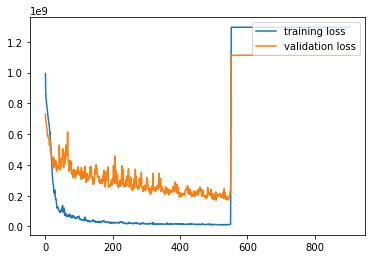

In [13]:
plt.plot(np.arange(epochs),train_loss_ep)
plt.plot(np.arange(epochs),val_loss_ep)
# plt.ylim((0,0.01))
# plt.xlim((0,150))
plt.legend(['training loss','validation loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_r2.jpg'))
plt.show()


In [13]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
np.argmin(val_loss_ep[:40])
# np.where(np.logical_not(np.isfinite(val_loss_ep[:])))
# val_loss_a_ep[8700]

18

In [14]:
imageslist={}
for s in ['disease13','disease8']:
    imageslist[s]=loadImage.loadandsplitPlaque_overlap_regrs(plaqueMaskImg,areaThresh,plaqueCentroids[s][['Y','X']].to_numpy().astype(int),plaqueCutoffRadius,sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,returnPos=True)
for s in ['control13','control8']:
    imageslist[s]=loadImage.loadandsplit(sampleidx[s],datadir,diamThresh_mul,0,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,clf=True,returnPos=True)
    

(22210, 22344)
plaque965
no plaque3648
(22294, 19552)
plaque397
no plaque4563
(22355, 18953)
no cells
no cells
(22452, 19616)


In [15]:
def plotExprs(exprs,exprs2,savename,embedding,embedding2,savepath,savenameAdd=''):
#     fig, ax = plt.subplots(dpi=400)
    if not exprs is None:
        plt.scatter(embedding[:,0],embedding[:,1],c=exprs,cmap='Greys',edgecolors='blue',linewidth=1,alpha=1,marker='o',vmin=0,vmax=4)
    if not exprs2 is None:
        plt.scatter(embedding2[:,0],embedding2[:,1],c=exprs2,cmap='Greys',edgecolors='green',linewidth=1,alpha=1,marker='^',vmin=0,vmax=4)
    plt.colorbar(orientation='vertical', shrink = 0.5)
    plt.gca().set_aspect('equal', 'datalim')
#     fig.set_figheight(5)
#     fig.set_figwidth(5)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'),dpi=400)
#     plt.show()
    
#     fig.clf()
    plt.close('all')

In [17]:
def plotLoss(inputNp,labelsNp,coordNp,name,savenameAdd=''):
    loss_test_all=np.zeros(inputNp.shape[0])
    for i in range(inputNp.shape[0]):
        testInput=inputNp[[i]]
        labels=labelsNp[[i]]
        if use_cuda:
            testInput=torch.tensor(testInput).cuda().float()
            labels=torch.tensor(labels).cuda().float()
        pred = model(testInput)
        loss_test_all[i]=lossCE(pred.flatten(),labels).item()
    
    posidx=(labelsNp>0)
    negidx=labelsNp==0
    loss_test_posLoss=np.sum(loss_test_all[posidx])/np.sum(posidx)
    loss_test_negLoss=np.sum(loss_test_all[negidx])/np.sum(negidx)
    print(name+' results',
          'loss positive: {:.4f}'.format(loss_test_posLoss),
         'loss negative: {:.4f}'.format(loss_test_negLoss))
    
    plotExprs(loss_test_all[posidx],loss_test_all[negidx],name+'loss'+s,coordNp[posidx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd)
    plotExprs(loss_test_all[posidx],None,name+'loss'+s+'_positive',coordNp[posidx],None,plotsavepath,savenameAdd=savenameAdd)
    plotExprs(None,loss_test_all[negidx],name+'loss'+s+'_negative',None,coordNp[negidx],plotsavepath,savenameAdd=savenameAdd)


testepoch=30
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
plotepoch='epoch30'
for s in sampleidx.keys():
    print(s)
    trainInputnp, valInputnp, testInputnp, trainLabelsnp,valLabelsnp,testLabelsnp,trainCoordnp,valCoordnp,testCoordnp=imageslist[s]
    plotLoss(testInputnp,testLabelsnp,testCoordnp,'test',plotepoch)
    plotLoss(trainInputnp,trainLabelsnp,trainCoordnp,'train',plotepoch)
    plotLoss(valInputnp,valLabelsnp,valCoordnp,'val',plotepoch)
    plotLoss(np.concatenate((trainInputnp,valInputnp,testInputnp),axis=0),np.concatenate((trainLabelsnp,valLabelsnp,testLabelsnp)),np.concatenate((trainCoordnp,valCoordnp,testCoordnp),axis=0),'all',plotepoch)
    

disease13
test results loss positive: 0.7671 loss negative: 0.3925
train results loss positive: 0.5934 loss negative: 0.3832
val results loss positive: 0.7820 loss negative: 0.4550
all results loss positive: 0.6214 loss negative: 0.3878
control13


<ipython-input-17-43c0e3531d60>:14: RuntimeWarning: invalid value encountered in double_scalars
  loss_test_posLoss=np.sum(loss_test_all[posidx])/np.sum(posidx)


test results loss positive: nan loss negative: 0.2493
train results loss positive: nan loss negative: 0.1885
val results loss positive: nan loss negative: 0.2185
all results loss positive: nan loss negative: 0.1961
disease8
test results loss positive: 0.4443 loss negative: 0.5264
train results loss positive: 0.4622 loss negative: 0.5121
val results loss positive: 0.7741 loss negative: 0.5173
all results loss positive: 0.4698 loss negative: 0.5138
control8
test results loss positive: nan loss negative: 0.6045
train results loss positive: nan loss negative: 0.5755
val results loss positive: nan loss negative: 0.5751
all results loss positive: nan loss negative: 0.5784


In [11]:
pred.shape

torch.Size([1, 2])

In [15]:
labels=testLabelsnp[i]

In [16]:
labels

1

In [ ]:
torch.sum(result[zeroidx])

In [ ]:
# model.pi.weight[:8,:8]
model_str